# Heart Disease Prediction

## Introduction

Heart Disease Dataset (also known as the Cleveland Dataset) is a classic dataset collected in 1988 by a team of researchers led by Dr. Robert Detrano at the Cleveland Clinic Foundation (USA). The goal of the project was to develop an algorithm capable of automatically predicting the presence of heart disease (primarily coronary-related conditions) based on non-invasive clinical indicators and diagnostic test results.

The data was collected from real patients undergoing examination in cardiology departments. Medical institutions from Hungary, Switzerland, and the USA also participated in the project. The complete dataset included four subsets: Cleveland, Hungary, Switzerland, and Long Beach VA — totaling approximately 920 records. However, only the Cleveland subset (303 records) contains sufficiently complete and high-quality data and has become a standard in research and education. The full dataset includes 76 features, but in practice, a reduced version with 14 features (13 clinical variables + 1 target variable) is commonly used.

Key features:
* Data source: real clinical indicators of patients referred for diagnostic evaluation of suspected heart disease.
* Purpose of collection: to predict the presence of heart disease prior to invasive coronary angiography.
* Task type: classification (typically binary: 0 — no disease, 1 — disease present).

Scientific significance

The Cleveland Dataset has become a benchmark for tasks in medical data analytics, machine learning classification, and interpretable AI. It has been widely used in scientific publications, educational settings, and applied healthcare research for over 30 years. Its popularity is due to a combination of:
* high data quality,
* clinical relevance of features,
* and practical applicability of models built using this data.

## Description of Variables

age — Patient's age (in years). A key risk factor for heart disease. Risk increases after 45 for men and 55 for women.    
sex — Patient's sex (1 = male, 0 = female). Heart disease is more common in men and manifests earlier.    
cp — Chest pain type:    
* 0 – Typical angina.    
* 1 – Atypical angina.    
* 2 – Non-anginal pain.    
* 3 – Asymptomatic.    
trestbps — Resting blood pressure (in mm Hg). Elevated values are associated with an increased risk of CAD.    
chol — Serum total cholesterol level (in mg/dl). Values >200 are considered elevated.    
fbs — Fasting blood sugar (1 = >120 mg/dl, 0 = ≤120 mg/dl). Diabetes increases the risk of heart disease.    
restecg — Resting electrocardiographic results:    
* 0 – Normal.    
* 1 – ST-T wave abnormality.    
* 2 – Left ventricular hypertrophy.    
thalach — Maximum heart rate achieved during exercise (in beats/min). Low values may be a marker of ischemia.    
exang — Exercise-induced angina (1 = yes, 0 = no). A sign of ischemia.    
oldpeak — ST depression induced by exercise relative to rest (in mm). Higher values indicate a higher risk of ischemia.    
slope — The slope of the peak exercise ST segment:    
* 0 – Downsloping.    
* 1 – Flat.    
* 2 – Upsloping (normal).    
ca — Number of major vessels (0–3) colored by fluoroscopy. Higher count means higher risk.    
thal — Thallium stress test results (radioisotope diagnosis):    
* 1 – Normal.    
* 2 – Fixed defect.    
* 3 – Reversible defect.    
target — Target variable:    
* 0 – No heart disease.    
* 1–4 – Different degrees of disease (simplified to binary in this dataset: 0 — healthy, 1 — sick).     

## Problem Statement

Cardiovascular diseases (CVDs) remain the leading cause of mortality worldwide, and Coronary Artery Disease (CAD), a common and dangerous manifestation of this group of pathologies, is a major concern. Early diagnosis of CAD is critically important for timely treatment, and modern machine learning methods allow for the identification of hidden patterns in medical data, thereby improving prediction accuracy.

The goal of this project is to build a model capable of predicting the presence of CAD in a patient based on a set of clinical features (laboratory tests, ECG results, physical exercise data, etc.) provided in the Cleveland Heart Disease Dataset.

The project will include in-depth feature analysis, investigation of feature importance, as well as the construction and evaluation of classification models.

## Helper Variables

In [18]:
features_to_drop = {}
palette = {'0': '#2CA02C', '1': '#F4511E'}
DEFAULT_NORMS = {
    "trestbps": 140,    # Resting Blood Pressure (mm Hg)
    # ≥140 — Hypertension according to JNC7 (2003) and ESC 2013 (Outdated)
    # MODERN standard (ACC/AHA 2017): ≥130/80 mm Hg
    # Note: 120-129/<80 — Elevated
    
    "chol": 240,        # Total Cholesterol (mg/dL)
    # ≥240 — High risk according to NCEP ATP III (2002, Outdated)
    # MODERN guidelines (ESC 2021):
    # - Optimal: <190 mg/dL
    # - For High Risk: <175 mg/dL
    # - With Confirmed CAD: <155 mg/dL
    
    "thalach": None,    # Maximum Heart Rate Achieved During Exercise (Max HR)
    # Age-dependent norm: 85% of (220 - age)
    # Example for 60 years old: (220-60)*0.85 = 136 beats/min
    # Failure to achieve (<85%) — Chronotropic Incompetence
    # Exceeding (>100%) may indicate anemia/hyperthyroidism
    
    "oldpeak": 1.0      # ST Depression on ECG after exercise (mm)
    # >1.0 mm — Clinically significant (ESC 2023)
    # Especially important with:
    # - Horizontal/Downsloping morphology
    # - Duration >1 min after exercise
    # Outdated threshold (1980s): >2.0 mm    # Устаревший порог (1980-е): >2.0 мм
}

legend_dict = {
    'target': ['No Disease (0)', 'Heart Disease (1)'],
    'sex': ['Female (0)', 'Male (1)'],
    'cp': ['Typical Angina (0)', 'Atypical Angina (1)', 'Non-Anginal Pain (2)', 'Asymptomatic (3)'],
    'fbs': ['FBS ≤ 120 mg/dl (0)', 'FBS > 120 mg/dl (1)'],
    'restecg': ['Normal (0)', 'ST-T Abnormality (1)', 'Left Ventricular Hypertrophy (2)'],
    'exang': ['No (0)', 'Yes (1)'],
    'slope': ['Upsloping (0)', 'Flat (1)', 'Downsloping (2)'],
    'thal': ['Unknown/None (0)', 'Normal (1)', 'Fixed Defect (2)', 'Reversible Defect (3)'],
    'ca': [
        '0: No significant vessel narrowing',
        '1: One vessel narrowed',
        '2: Two vessels narrowed',
        '3: Three vessels narrowed',
        '4: All four vessels narrowed (severe)'
    ]
}

## Functions

### Plot Target Distribution

Usage:
plot_target_distribution(data, target='stars')

In [19]:
def plot_target_distribution(data, target='stars', legend_labels=None):
    '''
    Visualizes the class distribution (barplot + pie chart) for a target variable with 5 classes.

    Parameters:
        data (pd.DataFrame): the dataset
        target (str): the name of the column containing class labels (default is 'stars')
        legend_labels (list): список подписей для легенды (по умолчанию ['No Disease (0)', 'Heart Disease (1)'])
    '''
    class_counts = data[target].value_counts().sort_index()
    # labels = ['No Disease (0)', 'Heart Disease (1)']
    sizes = class_counts.values
    labels = class_counts.index.tolist()

    # Значения по умолчанию для легенды
    if legend_labels is None:
        legend_labels = ['No Disease (0)', 'Heart Disease (1)']
    
    # Colors:  green',    'orange' 
    # colors = ['#4CAF50', '#FF9800'] 
    #colors = ['#8BC34A', '#F44336']
    # colors = ['#32CD32', '#FF8C00']
    # Автоматическая цветовая палитра
    n_classes = len(labels)
    colors = sns.color_palette("Set2", n_classes)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Barplot ---
    order = sorted(data[target].dropna().unique(), key=lambda x: float(x) if x != 'nan' else float('inf'))
    sns.countplot(x=target, data=data, ax=axes[0], hue=target, palette=colors, legend=False, order=order)
    axes[0].set_title('Distribution of {}'.format(target.capitalize()))
    axes[0].set_xlabel(target.capitalize())
    axes[0].set_ylabel('Count')
    
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].text(
            p.get_x() + p.get_width() / 2.,
            height + max(sizes) * 0.01,
            '{:.0f}'.format(height),
            ha='center', fontsize=10,
            # order=labels
        )
    
    # --- Pie chart ---
    patches, texts, autotexts = axes[1].pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=[0.03]*len(sizes),
        shadow=True
    )
    axes[1].set_title('{} Distribution (%)'.format(target.capitalize()))
    axes[1].axis('equal')
    
    # Добавляем легенду к pie chart
    axes[1].legend(patches, legend_labels[:len(sizes)], loc='best', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### Function to Visualize Pearson and Spearman Correlation Heatmaps

Usage:
plot_correlation_heatmaps(data, columns=None)

In [20]:
def plot_correlation_heatmaps(data, columns=None):
    '''
    Plots two correlation heatmaps: Pearson and Spearman.

    Parameters:
        data (pd.DataFrame): the dataset
        columns (list, optional): List of numeric columns to calculate correlation. If None, all numeric columns will be used

    Returns:
        tuple: (pearson_corr, spearman_corr) — two correlation matrices.
    '''

    # If columns is not specified, select all numeric columns
    if columns is None:
        columns = data.select_dtypes(include='number').columns.tolist()
    
    # Compute correlation matrices
    pearson_corr = data[columns].corr(method='pearson')
    spearman_corr = data[columns].corr(method='spearman')

    # Create side-by-side heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Pearson heatmap
    sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0], square=True)
    axes[0].set_title('Pearson Correlation Matrix')

    # Spearman heatmap
    sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1], square=True)
    axes[1].set_title('Spearman Correlation Matrix')

    plt.tight_layout()
    plt.show()

    return pearson_corr, spearman_corr

### Function to Detect Multicollinearity

Usage:
detect_multicollinearity_pairs(data, threshold)

In [21]:
def detect_multicollinearity_pairs(data, threshold):
    '''
        Detect multicollinearity between independent variables.
        
        Parameters:
            - data: pd.DataFrame
                Dataset containing numeric variables.
            - threshold: float
                Correlation threshold above which variables are considered collinear (e.g., 0.7).

        Returns:
            - pd.DataFrame with pairs of variables whose correlation exceeds the threshold,
              showing Pearson correlation on the left and Spearman correlation on the right.
    '''
    
    # Calculate Pearson correlation matrix (numeric variables only)
    corr_matrix_pearson = data.corr(numeric_only = True).round(3)
    # Calculate Spearman correlation matrix (numeric variables only)
    corr_matrix_spearman = data.corr(numeric_only = True, method='spearman').round(3)
    # Lists to hold Pearson correlation results
    var_1_p = []
    var_2_p = []
    value_p = []
    vs = []
    # Lists to hold Spearman correlation results
    var_1_s = []
    var_2_s = []
    value_s = []
    # Loop through Pearson matrix to find highly correlated pairs
    for i in range(len(corr_matrix_pearson.columns)):
        for j in range(i):
            if abs(corr_matrix_pearson.iloc[i, j]) > threshold:
                var_1_p.append(corr_matrix_pearson.columns[i])
                var_2_p.append(corr_matrix_pearson.columns[j])
                value_p.append(corr_matrix_pearson.iloc[i, j])
                vs.append('|')
    # Loop through Spearman matrix to find highly correlated pairs
    for i in range(len(corr_matrix_spearman.columns)):
        for j in range(i):
            if abs(corr_matrix_spearman.iloc[i, j]) > threshold:
                var_1_s.append(corr_matrix_spearman.columns[i])
                var_2_s.append(corr_matrix_spearman.columns[j])
                value_s.append(corr_matrix_spearman.iloc[i, j])
    # Create DataFrames from collected data
    multicoll_data_pearson = pd.DataFrame({'Var_1': var_1_p, 'Var_2': var_2_p, 'Corr_pearson': value_p, 'VS': vs})
    multicoll_data_spearman = pd.DataFrame({'Var_1': var_1_s, 'Var_2': var_2_s, 'Corr_spearman': value_s})
    # Concatenate Pearson and Spearman results side by side
    multicoll_data = pd.concat([multicoll_data_pearson, multicoll_data_spearman], axis=1)
    return multicoll_data

### Missing Values Analysis Function

Usage:
check_missing_values(df)

In [22]:
def check_missing_values(df):
    """
    Calculate and display missing values per column and overall dataset stats.

    Parameters
    ----------
    df : DataFrame

    Returns
    -------
    pandas.DataFrame
        A dataframe with columns:
        - 'Missing Values' : number of NaNs per column
        - 'Percentage'     : share of NaNs per column in %
    """
    # Per-column missing counts and percentages
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100

    # Table of columns with missing values
    missing_df = (
        pd.DataFrame({
            'Missing Values': missing_count,
            'Percentage': missing_percent.round(2)
        })
        .loc[lambda x: x['Missing Values'] > 0]
        .sort_values(by='Missing Values', ascending=False)
    )

    # Overall stats
    total_missing = int(missing_count.sum())
    total_cells = int(df.shape[0] * df.shape[1])
    overall_pct = (total_missing / total_cells) * 100

    print()
    print('-'*45)
    print('Missing values are present in {} columns'.format(len(missing_df)))
    print('Total number of missing values: {}'.format(total_missing))
    print('Overall percentage of missing values: {:.2f}%'.format(overall_pct))
    print('-'*45)
    print()

    return missing_df

### Missing values report and plots

Usage:
missing_values_report_plot(df, col, target='target', alpha=0.05)

In [23]:
def missing_values_report_plot(df, col, target='target', alpha=0.05):
    """
    One-stop missingness report:
      - prints count/% of missing in `col`
      - shows class-wise percentages of missing by `target`
      - runs Chi-square test: missing(col) ~ target
      - plots a bar chart of % missing by target

    Parameters
    ----------
    df : pd.DataFrame
    col : str
        Column to analyze.
    target : str
        Target column name.
    alpha : float
        Significance level for Chi-square test.
    """

    print("===== Missing Values Analysis for: {} =====".format(col))

    # 1) Количество и процент пропусков
    n_miss = df[col].isna().sum()
    pct_miss = n_miss / len(df) * 100.0
    print("Missing in {}: {} ({:.2f}%)".format(col, n_miss, pct_miss))
    print("Percentage is calculated relative to the total number of rows in the dataset.")

    # 3) Доли пропусков по target
    miss_flag = df[col].isna().astype(int)
    by_target = (pd.crosstab(df[target], miss_flag, normalize='index') * 100.0).round(1)
    # переименуем столбцы
    if 0 in by_target.columns and 1 in by_target.columns:
        by_target.columns = ['No Missing', 'Missing']
    print("\nPercentage of missing values by target class {} (%):".format(target))
    print(by_target)
    print("Percentages are calculated relative to the number of rows in each target class.")

    # 4) χ²-тест зависимости пропусков от target
    chi2_tbl = pd.crosstab(df[target], miss_flag)
    chi2, p, dof, _ = stats.chi2_contingency(chi2_tbl)
    print("\nChi-square p-value (missing ~ {}): {:.5f}".format(target, p))

    # 5) Интерпретация результата
    if n_miss == 0:
        inference = "No missing values detected."
    elif p < alpha:
        inference = "Missing values are likely NOT MCAR (depend on target). Possible MAR or MNAR."
    else:
        inference = "Missing values may be MCAR (no significant relation to target)."
    print("\n{}".format(inference))
    print("="*50)

    # 6) График (% пропусков по классам target)
    plot_df = (pd.crosstab(df[target], miss_flag, normalize='index') * 100.0)
    plot_df.columns = ['Filled', 'Missing']

    ax = plot_df[['Missing']].plot(kind='bar', color='#FF7043', legend=False, figsize=(6, 4))
    ax.set_title("Share of Missing Values in '{}' by {}".format(col, target))
    ax.set_ylabel('% Missing')
    ax.set_xlabel(target)
    ax.set_ylim(0, 100)
    for i, val in enumerate(plot_df['Missing']):
        ax.text(i, val + 1, "{:.1f}%".format(val), ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

### Diagnostic plots

Usage:
diagnostic_plots(data, variable)

In [24]:
def diagnostic_plots(df, variable):
    """
    Displays three diagnostic plots (Histogram, Q-Q Plot, and Boxplot) side by side for a given variable.

    Parameters:
    - data: pd.DataFrame
        The dataset containing the variable.
    - variable: str
        The name of the variable to be visualized.

    The function creates:
    1. Histogram — to visualize the distribution of the variable.
    2. Q-Q Plot — to assess normality by comparing the quantiles to a normal distribution.
    3. Boxplot — to detect outliers and understand the spread of the variable.
    """

    data = df.copy()
    data[variable] = pd.to_numeric(data[variable], errors='coerce')
    data = data.dropna(subset=[variable])
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data[variable], bins=30, kde=True)
    plt.title('Histogram of {}'.format(variable))

    # Q-Q Plot
    # plt.subplot(1, 3, 2)
    # stats.probplot(data[variable], dist='norm', plot=plt)
    # plt.title('Q-Q Plot of {}'.format(variable))
    # plt.ylabel('Sample Quantiles')

    # Q-Q Plot
    plt.subplot(1, 3, 2)
    stats.probplot(data[variable].dropna(), dist='norm', plot=plt)
    plt.title('Q-Q Plot of {}'.format(variable))
    plt.ylabel('Sample Quantiles')

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=data[variable])
    plt.title('Boxplot of {}'.format(variable))

    plt.tight_layout()
    plt.show()

### Diagnostic plots for discrete

Usage:
plot_discrete_distribution(data: pd.DataFrame, feature: str)

In [25]:
def plot_discrete_distribution(data: pd.DataFrame, feature: str):
    # Преобразуем в строку — строго категориальные
    data[feature] = data[feature].astype(str)

    # Подсчёт количества категорий
    counts = data[feature].value_counts().sort_index()
    
    # Подготовка данных для boxplot (распределение частот)
    count_values = counts.values
    
    # Построение графиков
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ==== ГРАФИК 1: Столбчатая диаграмма ====
    order = sorted(data[feature].dropna().unique(), key=lambda x: float(x) if x != 'nan' else float('inf'))
    sns.countplot(x=feature, data=data, ax=axes[0], palette='Set2', order=order)

    # Подписи значений над столбцами
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%d', padding=3)

    axes[0].set_title(f"Distribution of {feature}")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Count")

    # ==== ГРАФИК 2: boxplot частот ====
    sns.boxplot(y=count_values, ax=axes[1], color="skyblue", width=0.5)
    axes[1].set_title("Category Frequency Outliers")
    axes[1].set_ylabel("Count")

    # ==== Обнаружение выбросов (по IQR) ====
    q1 = counts.quantile(0.25)
    q3 = counts.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = counts[(counts < lower) | (counts > upper)]

    # Вывод информации о выбросах
    if not outliers.empty:
        print(f"\nНайдены выбросы по количеству значений в {feature}:")
        for k, v in outliers.items():
            print(f"  - Категория '{k}' имеет {v} наблюдений")
    else:
        print(f"\nНет выбросов по количеству категорий в {feature}")

    plt.tight_layout()
    plt.show()

### Feature–Target Visualization

Usage:
analyze_feature(df, 'feature_name', target='target')

In [26]:
"""
Feature–Target Visualization Toolkit
--------------------------------------

A set of functions for automated creation of informative plots when analyzing features 
(both discrete and continuous) in the context of a binary target variable.

Capabilities:
-------------
1. Automatic feature type detection:
   - The is_discrete() function classifies a feature as categorical/discrete or continuous 
     based on the unique value threshold (Cat_Cardinality_Threshold).

2. Plotting for discrete features (plot_discrete):
   - Countplot: number of observations per category, split by target.
   - Stacked bar chart: percentage distribution of target within each category of the feature.
   - Strip plot: visualization of category spread by target.

3. Plotting for continuous features (plot_continuous):
   - KDE density plots for target=0 and target=1.
   - Boxplot: comparison of feature distributions between target groups.
   - Scatter/strip plot: data points of the feature by target.

4. Universal wrapper analyze_feature():
   - Determines the feature type (discrete or continuous) and calls the appropriate plotting function.

Customization:
--------------
- Cat_Cardinality_Threshold: controls how many unique values qualify as a discrete feature.
- colors: dictionary of colors for target=0 (green) and target=1 (orange).

Usage:
------
analyze_feature(df, 'feature_name', target='target')

Parameters:
-----------
df : pandas.DataFrame
    Dataset containing the analyzed features and the target column.
col : str
    Name of the feature to analyze.
"""

# Порог: для определения дискретных переменных
Cat_Cardinality_Threshold = 10
colors = {0: '#2CA02C', 1: '#F4511E'}

def is_discrete(df, col):
    s = df[col]
    return (s.dtype == 'O') or (s.nunique(dropna=True) <= Cat_Cardinality_Threshold)

# --- Графики для категориальных переменных
def plot_discrete(df, col, target='target'):

    palette = {0: '#2CA02C', 1: '#F4511E'}
    d = df[[col, target]].dropna()
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

    # 1) Countplot
    sns.countplot(data=d, x=col, hue=target, palette=palette, ax=axes[0])
    axes[0].set_title(f'Count of {col} by {target}')
    axes[0].grid(axis='y', alpha=0.2)

    # Добавляем числа на столбцы
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(f'{int(height)}', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=9)

    # 2) Столбцы с накоплением (% внутри категории col)
    share = (
        d.groupby([col, target]).size()
          .groupby(level=0).apply(lambda x: x / x.sum() * 100)
          .unstack(fill_value=0)
    )

    # Удаляем мультииндекс, если вдруг возник
    if isinstance(share.index, pd.MultiIndex):
        share.index = share.index.get_level_values(0)
    
    share.plot(kind='bar', stacked=True, ax=axes[1], legend=False, color=palette)
    axes[1].set_ylabel('% within ' + col)
    axes[1].set_title(f'Share of {target} within {col}')
    axes[1].grid(axis='y', alpha=0.2)

    # Добавляем проценты на сегменты
    for c in axes[1].containers:
        axes[1].bar_label(c, fmt='%.0f%%', label_type='center', fontsize=9)

    # 3) Strip Plots
    sns.stripplot(data=d, x=target, y=col, hue=target, palette=palette,
                  dodge=False, size=4, legend=False, ax=axes[2])
    axes[2].set_title(f'Strip of {col} by {target}')
    axes[2].grid(axis='y', alpha=0.2)

    plt.show()

# --- Графики для непрерывных
def plot_continuous(df, col, target='target'):

    palette = {0: '#2CA02C', 1: '#F4511E'}
    d = df[[col, target]].dropna()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

    # 1) KDE target=0 vs target=1 (один график)
    sns.kdeplot(data=d, x=col, hue=target, ax=axes[0], palette=palette, common_norm=False, fill=True, alpha=0.35)
    axes[0].set_title(f'Distribution density of {col}')
    axes[0].grid(axis='y', alpha=0.2)

    # 2) Boxplot по target
    sns.boxplot(data=d, x=target, y=col, hue=target, palette=palette, legend=False, ax=axes[1])
    axes[1].set_title(f'Boxplot of {col} by {target}')
    axes[1].grid(axis='y', alpha=0.2)

    # 3) Scatter target vs col
    sns.stripplot(data=d, x=target, y=col, jitter=True, hue=target, legend=False, palette=palette, alpha=0.6, ax=axes[2])
    axes[2].set_title(f'Scatter of {col} by {target}')

    plt.show()

# --- Начальная функция. Определяет дискретная переменная или продолжительная и направляет на нужную функцию отрисовки
def analyze_feature_vs_target(df, col, target='target'):
    if is_discrete(df, col):
        plot_discrete(df, col, target)
    else:
        plot_continuous(df, col, target)

### Feature Analysis by Age Groups: Continuous and Discrete Variables

Usage:    
plot_continuous_vs_target_by_age(df, feature='thalach', target='target')      
plot_discrete_vs_target_by_age(df, discrete_col='cp', target='target')

In [27]:
"""
Age–Stratified Feature–Target Analysis
---------------------------------------

A set of functions for analyzing and visualizing relationships between features 
(continuous and discrete) and a binary target variable across predefined age groups.

Capabilities:
-------------
1. Abnormality detection (is_abnormal):
   - Checks whether a given feature value lies outside a clinically relevant threshold.
   - For 'thalach' (maximum heart rate), the threshold is calculated as 85% of (220 − age).
   - Returns a Boolean flag (True = abnormal, False = normal) or NaN if evaluation is not possible.

2. Continuous feature visualization (plot_continuous_vs_target_by_age):
   - Left panel: Scatter plot of age vs. the feature, colored by target class, with normal range guides.
   - Right panel: Grouped bar chart showing the percentage distribution of 
     (Health status: Healthy/Sick × Measurement status: Normal/Abnormal) 
     within each age group.
   - Highlights how the frequency of abnormal readings changes with age and disease presence.

3. Discrete feature visualization (plot_discrete_vs_target_by_age):
   - One bar chart per age group (≤50, 51–60, >60 by default).
   - Within each chart: percentage of target=0 and target=1 for each category of the discrete feature.
   - Performs a Chi-square test of independence for the feature vs. target in each age group.
   - Optionally returns raw count/percentage tables for further analysis.

Customization:
--------------
- age_bins, age_labels: control how age groups are defined.
- norms: dictionary of normal thresholds for continuous features.
- palette/bar_palette: custom colors for target classes and category segments.
- return_tables: if True, returns intermediate computation tables.

Usage:
------
plot_continuous_vs_target_by_age(df, feature='thalach', target='target')
plot_discrete_vs_target_by_age(df, discrete_col='cp', target='target')

Parameters:
-----------
df : pandas.DataFrame
    Dataset containing the analyzed features, age, and target columns.
feature / discrete_col : str
    Name of the feature to analyze (continuous or discrete).
target : str
    Name of the binary target variable (default: 'target').
age_bins : tuple
    Boundaries for age grouping.
age_labels : tuple
    Labels for age groups.

Purpose:
--------
These functions help detect age-dependent patterns in feature distribution and 
their association with the target, supporting both exploratory data analysis 
and hypothesis testing.
"""

def is_abnormal(row, feature, norms):
    """Простая проверка выхода значения за норму для строки row."""
    val = row[feature]
    if pd.isna(val):
        return np.nan

    if feature == "thalach":
        age = row["age"]
        if pd.isna(age):
            return np.nan
        thr = 0.85 * (220 - age)          # 85% от прогнозного максимума
        return bool(val < thr)            # ниже порога — ненормально

    thr = norms.get(feature)
    if thr is None:
        return np.nan

    if feature in ("trestbps", "chol"):
        return bool(val >= thr)           # выше/равно порогу — ненормально
    if feature == "oldpeak":
        return bool(val > thr)            # строго больше порога
    return np.nan


def plot_continuous_vs_target_by_age(
    df,
    feature,
    target="target",
    # границы возрастных групп и их подписи
    age_bins=(-np.inf, 50, 60, np.inf), 
    age_labels=("<50", "50–59", "≥60"),
    norms=DEFAULT_NORMS,
    scatter_palette={0: "#2CA02C", 1: "#F4511E"},   # 0 — зелёный, 1 — оранжево-красный
    bar_palette={
        ("Healthy","Normal"):   "#3CB371",
        ("Healthy","Abnormal"): "#98FB98",
        ("Sick","Normal"):      "#FFA500",
        ("Sick","Abnormal"):    "#FF6347",
    },
    add_guides=True
):
    """Слева: scatter age vs feature (раскраска по target).
       Справа: % распределения (Healthy/Sick × Normal/Abnormal) по 3 возрастным группам.
    """
    d = df.copy().dropna(subset=["age", feature, target])

    # Создаем новую переменную поделив переменную age на 3 возрастные группы
    d["age_group"] = pd.cut(d["age"], bins=age_bins, labels=age_labels, right=False, ordered=True)

    groups = [group[feature].values for name, group in d.groupby("age_group")]

    # Проверка, что в каждой группе достаточно данных (хотя бы 2)
    if all(len(g) > 1 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        print()
        print(f"\nOne-way ANOVA for '{feature}' by age group:")
        print(f"F = {f_stat:.3f}, p = {p_val:.4f}")
    else:
        print(f"\nНедостаточно данных для ANOVA по возрастным группам для признака '{feature}'")

    # Создаем новую переменную значения которые булевые значения обозначающие нормальные или ненормальные показания
    d["abnormal"] = d.apply(lambda r: is_abnormal(r, feature, norms), axis=1)
    d = d.dropna(subset=["abnormal"])

    # Создаем переменную Health значения которых Sick и Healthy соответственно таргету больной или нет
    d["Health"] = np.where(d[target].astype(int) == 1, "Sick", "Healthy")
    # Создаем переменную значения которой означают показатели в норме или нет
    d["Norm"] = np.where(d["abnormal"], "Abnormal", "Normal")

    # --- Рисуем
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # 1) Scatter слева
    ax0 = axes[0]
    sns.scatterplot(
        data=d, x="age", y=feature, hue=target,
        palette=scatter_palette, alpha=0.75, edgecolor="none", ax=ax0
    )
    ax0.set_title(f"age vs {feature}")
    ax0.grid(True, alpha=0.3)

    if add_guides:
        # Вертикальные линии на границах групп (50 и 60 по умолчанию)
        for b in age_bins[1:-1]:
            ax0.axvline(b, color="purple", linestyle="--", linewidth=1)
        # Горизонтальная/кривая норма по признаку
        if feature == "thalach":
            ages = np.linspace(d["age"].min(), d["age"].max(), 200)
            norm_th = 0.85 * (220 - ages)
            ax0.plot(ages, norm_th, color="orange", linestyle="--", linewidth=1,
                     label="Norm thalach (85% of 220-age)")
        else:
            thr = norms.get(feature, None)
            if thr is not None:
                ax0.axhline(thr, color="orange", linestyle="--", linewidth=1,
                            label=f"Norm {feature}={thr}")
        ax0.legend(title=None, loc="best")

    # 2) Группированный bar справа
    ax1 = axes[1]
    ct = (
        d.groupby(["age_group", "Health", "Norm"], observed=False)
         .size()
         .rename("count")
         .reset_index()
    )
    
    ct["pct"] = ct.groupby("age_group", observed=False)["count"].transform(lambda x: 100 * x / x.sum())

    segment_order = [
        ("Healthy","Normal"),
        ("Healthy","Abnormal"),
        ("Sick","Normal"),
        ("Sick","Abnormal"),
    ]
    ct["segment"] = pd.Categorical(ct[["Health","Norm"]].apply(tuple, axis=1),
                                   categories=segment_order, ordered=True)

    sns.barplot(
        data=ct,
        x="age_group", y="pct", hue="segment",
        palette={seg: bar_palette[seg] for seg in segment_order},
        hue_order=segment_order,
        ax=ax1
    )
    for container in ax1.containers:
        ax1.bar_label(container, fmt="%.0f%%", label_type="edge", fontsize=9)

    ax1.set_ylabel("% of patients")
    ax1.set_xlabel("age group")
    ax1.set_title(f"{feature}: distribution by age group & normality")
    ax1.grid(axis="y", alpha=0.25)
    ax1.legend(title=None, loc="upper right")

    plt.show()


def plot_discrete_vs_target_by_age(
    df,
    discrete_col,                 # напр.: 'sex', 'cp', 'thal', 'restecg'
    target='target',              
    age_bins=(0, 50, 60, np.inf), # границы групп возраста: ≤50, 51–60, >60
    age_labels=('≤50', '51–60', '>60'),
    order=None,                   # порядок уровней дискретной переменной (опц.)
    palette=None,                 # цвета для target-классов
    return_tables=False
):
    """
    ТРИ барчарта по возрастным группам: ≤50, 51–60, >60.
    На каждом — % target=0 и % target=1 внутри каждого уровня дискретного признака.
    Печатает p-value χ²-теста зависимости (discrete_col ~ target) в каждой возрастной группе.
    """
    if palette is None:
        palette = {0: '#2CA02C', 1: '#F4511E'}  

    # Базовая подготовка
    d = df.copy().dropna(subset=['age', discrete_col, target])
    d['age_group'] = pd.cut(d['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

    # Порядок уровней дискретной переменной
    if order is None:
        uniq = pd.unique(d[discrete_col].dropna())
        try:
            order = sorted(uniq)
        except Exception:
            order = list(uniq)

    groups = list(age_labels)
    out_tables = {}
    print()
    # Фигура с тремя панелями
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
    
    for ax, grp in zip(axes, groups):
        sub = d[d['age_group'] == grp].copy()
        if sub.empty:
            ax.set_axis_off()
            continue

        # χ²-тест зависимости discrete_col с target в этой возрастной группе
        ct = pd.crosstab(sub[discrete_col], sub[target])
        if ct.shape[0] > 1 and ct.shape[1] > 1:
            chi2, p, dof, _ = chi2_contingency(ct)
            
            print("[{}] Chi-square p-value for {} ~ {}: {:.4g}".format(grp, discrete_col, target, p))
        else:
            print("[{}] Chi-square p-value: недостаточно уровней для теста".format(grp))

        # Подсчёты и проценты внутри уровня дискретного признака
        counts = (
            sub.groupby([discrete_col, target])
               .size()
               .reset_index(name='count')
        )
        counts['pct'] = counts.groupby(discrete_col)['count'].transform(lambda x: 100 * x / x.sum())
        n_per_level = counts.groupby(discrete_col)['count'].sum()

        # Оставим уровни, реально встречающиеся в группе
        level_order = [lvl for lvl in order if lvl in counts[discrete_col].unique()]

        # Барчарт
        sns.barplot(
            data=counts,
            x=discrete_col, y='pct',
            hue=target, hue_order=[0, 1],
            order=level_order,
            palette=palette,
            ax=ax
        )

        # Подписи процентов
        for container in ax.containers:
            ax.bar_label(container, fmt='%.0f%%', label_type='edge', fontsize=9)

        # Подпись n под категориями
        ax.set_xticks(range(len(level_order)))
        ax.set_xticklabels([
            "{}\n(n={})".format(lvl, int(n_per_level.get(lvl, np.nan)))
            for lvl in level_order
        ])

        ax.set_title("% of {} by {} — age {}".format(target, discrete_col, grp))
        ax.set_ylabel('%')
        ax.set_xlabel(discrete_col)
        ax.set_ylim(0, 100)
        ax.grid(axis='y', alpha=0.25)
        ax.legend(title=target, loc='upper right')

        out_tables[grp] = counts.copy()

    plt.show()

    if return_tables:
        return out_tables


### Feature Analysis by Sex: Continuous and Discrete Variables

Usage:    
plot_continuous_vs_target_by_sex(data: pd.DataFrame, variable: str)      
plot_discrete_vs_target_by_sex(df, variable)

In [28]:
def plot_continuous_vs_target_by_sex(data: pd.DataFrame, variable: str):

    """
    Plots detailed visualization of a continuous variable stratified by sex and target outcome.

    Function performs:
    1. Stratification by sex (male and female).
    2. Boxplot + stripplot for each sex across target groups (Healthy vs Sick).
    3. Optional reference line for "normal value" if defined.
    4. Displays p-values from one-way ANOVA (f_oneway) for each sex.
    5. Shows barplot of the proportion of "normal" vs "abnormal" values by sex and target.
    6. Annotates each boxplot with the number of observations.

    Supports variables with dynamic norms (e.g., thalach by age group).

    Parameters:
    - data: input DataFrame.
    - variable: name of the continuous variable (e.g., "thalach", "chol", "oldpeak").

    Requirements:
    - DEFAULT_NORMS: dictionary of thresholds defining "normal" for each variable.
    - palette: dictionary mapping target labels (Healthy/Sick) to colors.
    """

    
    df = data.copy()

    if variable not in DEFAULT_NORMS:
        raise ValueError(f"Переменная {variable} не указана в DEFAULT_NORMS")

    fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

    # Метка пола
    df["sex_label"] = df["sex"].map({0: "Female", 1: "Male"})

    # Определим нормальность
    if variable == "thalach":
        df["thalach_norm"] = (220 - df["age"]) * 0.85
        df["normality"] = df[variable] >= df["thalach_norm"]
        thalach_norm = (220 - df["age"].median()) * 0.85
        axes[0].axhline(y=thalach_norm, linestyle='--', color='green', label='Norm')
        axes[2].axhline(y=thalach_norm, linestyle='--', color='green', label='Norm')
    else:
        norm_value = DEFAULT_NORMS[variable]
        df["normality"] = df[variable] <= norm_value
        for ax in [axes[0], axes[2]]:
            ax.axhline(y=norm_value, linestyle='--', color='green', label='Norm')

    df["normality_label"] = df["normality"].map({True: "Normal", False: "Abnormal"})
    df["target_label"] = df["target"].map({0: "Healthy", 1: "Sick"})
    df["group"] = df["sex_label"] + " | " + df["target_label"]

    df_female = df[df["sex"] == 0]
    df_male = df[df["sex"] == 1]

    # ANOVA для женщин
    fem_0 = df_female[df_female['target'] == 0][variable].dropna()
    fem_1 = df_female[df_female['target'] == 1][variable].dropna()
    if len(fem_0) > 1 and len(fem_1) > 1:
        f_female, p_female = f_oneway(fem_0, fem_1)
        print(f"\nOne-way ANOVA for '{variable}' by sex:")
        print(f"Female F = {f_female:.3f}, p = {p_female:.4f}")
    else:
        p_female = np.nan
    
    # ANOVA для мужчин
    male_0 = df_male[df_male['target'] == 0][variable].dropna()
    male_1 = df_male[df_male['target'] == 1][variable].dropna()
    if len(male_0) > 1 and len(male_1) > 1:
        f_male, p_male = f_oneway(male_0, male_1)
        print(f"Male F = {f_male:.3f}, p = {p_male:.4f}")
    else:
        p_male = np.nan

    # -------- График 1: Женщины --------
    sns.boxplot(data=df_female, x='target', y=variable, palette=palette, ax=axes[0])
    sns.stripplot(data=df_female, x='target', y=variable, ax=axes[0], color='#4C4C4C', size=4, jitter=True)
    axes[0].set_title(f'{variable} by target (females)')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].text(0.5, 0.95, f"p = {p_female:.4f}", ha="center", va="center", transform=axes[0].transAxes)

    female_counts = df_female['target'].value_counts().sort_index()
    for idx, count in female_counts.items():
        y_min, y_max = axes[0].get_ylim()
        text_y = y_min - 0.1 * (y_max - y_min)
        axes[0].text(
            x=idx,
            # y=axes[0].get_ylim()[0] -1,
            y=text_y,
            s=f"n={count}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

    # -------- График 2: Барплот по группам --------
    grouped = df.groupby(["group", "normality_label"]).size().reset_index(name="count")
    grouped["percent"] = grouped.groupby("group")["count"].transform(lambda x: 100 * x / x.sum())

    sns.barplot(
        data=grouped,
        x="group",
        y="percent",
        hue="normality_label",
        palette={"Normal": "#2CA02C", "Abnormal": "#F4511E"},
        ax=axes[1]
    )
    axes[1].set_title(f"Normal vs Abnormal {variable} by Sex and Health")
    axes[1].set_ylabel("Percent (%)")
    axes[1].set_xlabel("Sex and Health Status")
    axes[1].set_ylim(0, 100)
    axes[1].grid(axis='y', alpha=0.3)

    for i, row in grouped.iterrows():
        x_index = i // 2 + (i % 2) * 0.2 - 0.1
        axes[1].text(
            x=x_index,
            y=row["percent"] + 1,
            s=f"{row['percent']:.0f}%",
            ha="center",
            fontsize=9
        )
    axes[1].legend(title="Normality")

    # -------- График 3: Мужчины --------
    sns.boxplot(data=df_male, x='target', y=variable, palette=palette, ax=axes[2])
    sns.stripplot(data=df_male, x='target', y=variable, ax=axes[2], color='#4C4C4C', size=4, jitter=True)
    axes[2].set_title(f'{variable} by target (males)')
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].text(0.5, 0.95, f"p = {p_male:.4f}", ha="center", va="center", transform=axes[2].transAxes)

    male_counts = df_male['target'].value_counts().sort_index()
    
    for idx, count in male_counts.items():
        y_min, y_max = axes[2].get_ylim()
        text_y = y_min - 0.1 * (y_max - y_min)
        axes[2].text(
            x=idx,
            # y=axes[2].get_ylim()[0] -1,
            y=text_y,
            s=f"n={count}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

    plt.suptitle(f"Analysis of {variable}", fontsize=16, y=1.03)
    plt.show()


def plot_discrete_vs_target_by_sex(df, variable):

    """
    Plots visualization of a categorical (discrete) variable stratified by sex and target outcome.

    Function performs:
    1. Splits data by sex (male and female).
    2. Plots barplots showing the percentage distribution of target (Healthy vs Sick) across variable levels.
    3. Adds percentage labels and absolute counts below x-axis.
    4. Displays p-values from Chi-Squared test (chi2_contingency) for each sex.

    Useful for analyzing features such as 'cp', 'restecg', 'slope', etc.

    Parameters:
    - df: input DataFrame.
    - variable: name of the categorical variable.

    Uses a fixed color palette:
    - "Healthy" (target=0): green
    - "Sick" (target=1): orange
    """
    
    palette = {
        "Healthy": "#2CA02C",
        "Sick": "#F4511E"
    }

    df = df.copy()
    df["target_label"] = df["target"].map({0: "Healthy", 1: "Sick"})

    df_male = df[df["sex"] == 1]
    df_female = df[df["sex"] == 0]

    # Chi-square
    contingency_female = pd.crosstab(df_female[variable], df_female["target"])
    contingency_male = pd.crosstab(df_male[variable], df_male["target"])
    _, p_female, _, _ = chi2_contingency(contingency_female)
    _, p_male, _, _ = chi2_contingency(contingency_male)

    # Кол-во наблюдений
    n_female = len(df_female)
    n_male = len(df_male)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle(f"Analysis of {variable} (categorical)", fontsize=16)

    # ---------- FEMALES ----------
    female_plot_data = (
        df_female.groupby([variable, "target_label"])
        .size()
        .reset_index(name="count")
    )
    female_plot_data["percent"] = (
        female_plot_data.groupby(variable)["count"].transform(lambda x: 100 * x / x.sum())
    )

    # Подписи x с числом наблюдений
    female_counts = df_female[variable].value_counts().sort_index()
    female_xticks = [f"{val}\n(n={female_counts[val]})" for val in female_counts.index]
    female_plot_data["x_tick"] = female_plot_data[variable].map(lambda val: f"{val}\n(n={female_counts[val]})")

    sns.barplot(
        data=female_plot_data,
        x="x_tick",
        y="percent",
        hue="target_label",
        ax=axes[0],
        palette=palette
    )

    for container in axes[0].containers:
        axes[0].bar_label(container, fmt="%.1f", label_type="edge", fontsize=8)

    axes[0].set_title(f"{variable} by target (Females, n={n_female})\nChi² p = {p_female:.4f}")
    axes[0].set_ylabel("Percent (%)")
    axes[0].set_xlabel(variable)

    # ---------- MALES ----------
    male_plot_data = (
        df_male.groupby([variable, "target_label"])
        .size()
        .reset_index(name="count")
    )
    male_plot_data["percent"] = (
        male_plot_data.groupby(variable)["count"].transform(lambda x: 100 * x / x.sum())
    )

    male_counts = df_male[variable].value_counts().sort_index()
    male_plot_data["x_tick"] = male_plot_data[variable].map(lambda val: f"{val}\n(n={male_counts[val]})")

    sns.barplot(
        data=male_plot_data,
        x="x_tick",
        y="percent",
        hue="target_label",
        ax=axes[1],
        palette=palette
    )

    for container in axes[1].containers:
        axes[1].bar_label(container, fmt="%.1f", label_type="edge", fontsize=8)

    axes[1].set_title(f"{variable} by target (Males, n={n_male})\nChi² p = {p_male:.4f}")
    axes[1].set_ylabel("")
    axes[1].set_xlabel(variable)

    plt.tight_layout()
    plt.show()

### Feature Anallysis by Chol

In [29]:
def plot_cholesterol_boxplots(data, split_variable='fbs', ylabel='Cholesterol (mg/dl)'):
    """
    Строит два boxplot-графика уровня холестерина по target (болен/здоров), 
    разделяя по значению бинарной переменной (например, fbs или exang).
    
    Parameters:
        data (pd.DataFrame): Исходный DataFrame
        split_variable (str): Название переменной для разделения (по умолчанию 'fbs')
        ylabel (str): Подпись оси Y
    """
    group1 = data[data[split_variable] == 0]
    group2 = data[data[split_variable] == 1]

    # Цвета для target
    palette = {'0': '#2CA02C', '1': '#F4511E'}

    # Создаём подграфики
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # График 1 — переменная == 0
    sns.boxplot(x='target', y='chol', data=group1, ax=axes[0], palette=palette)
    axes[0].set_title(f"Cholesterol vs Target ({split_variable} = 0)")
    axes[0].set_xlabel("Target (0 = No Disease, 1 = Disease)")
    axes[0].set_ylabel(ylabel)
    axes[0].axhline(y=200, color='green', linestyle='--', linewidth=1, label='< 200 — Low risk')
    axes[0].axhline(y=239, color='orange', linestyle='--', linewidth=1, label='200–239 — Borderline')
    axes[0].axhline(y=240, color='red', linestyle='--', linewidth=1, label='≥ 240 — High')
    axes[0].axhline(y=300, color='purple', linestyle='--', linewidth=1, label='> 300 — Critical')
    axes[0].legend(loc='upper left', fontsize=8)

    for i, target_value in enumerate([0, 1]):
        count = (group1['target'] == target_value).sum()
        axes[0].text(i, group1['chol'].min() - 20, f'n = {count}', ha='center', fontsize=10)

    # График 2 — переменная == 1
    sns.boxplot(x='target', y='chol', data=group2, ax=axes[1], palette=palette)
    axes[1].set_title(f"Cholesterol vs Target ({split_variable} = 1)")
    axes[1].set_xlabel("Target (0 = No Disease, 1 = Disease)")
    axes[1].axhline(y=200, color='green', linestyle='--', linewidth=1, label='< 200 — Low risk')
    axes[1].axhline(y=239, color='orange', linestyle='--', linewidth=1, label='200–239 — Borderline')
    axes[1].axhline(y=240, color='red', linestyle='--', linewidth=1, label='≥ 240 — High')
    axes[1].axhline(y=300, color='purple', linestyle='--', linewidth=1, label='> 300 — Critical')
    axes[1].legend(loc='upper right', fontsize=8)

    for i, target_value in enumerate([0, 1]):
        count = (group2['target'] == target_value).sum()
        axes[1].text(i, group2['chol'].min() - 20, f'n = {count}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

## Import Libraries and Tools

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
import missingno as msno

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="missingno")
warnings.filterwarnings("ignore", category=FutureWarning)

## Load and Explore the Dataset

In [31]:
data = pd.read_csv('heartDisease_dataset_TP.csv')

data.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0      NaN    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0       1  
1    0.0  0.0   2.0       1  
2    2.0  0.0   2.0       1  
3    2.0  NaN   2.0       1  
4    2.0  0.0   2.0       1

In [32]:
data.tail()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
298  57.0  0.0  0.0     140.0  241.0  0.0      1.0    123.0    1.0      0.2   
299  45.0  1.0  3.0     110.0  264.0  0.0      1.0    132.0    0.0      1.2   
300  68.0  1.0  0.0     144.0  193.0  1.0      1.0    141.0    0.0      3.4   
301  57.0  1.0  0.0     130.0  131.0  0.0      1.0    115.0    1.0      1.2   
302  57.0  0.0  1.0     130.0  236.0  0.0      0.0    174.0    0.0      0.0   

     slope   ca  thal  target  
298    1.0  0.0   3.0       0  
299    1.0  0.0   3.0       0  
300    1.0  2.0   3.0       0  
301    1.0  1.0   3.0       0  
302    1.0  1.0   2.0       0

In [33]:
data.shape

(303, 14)

The dataset consists of 303 observations and 14 variables, each of which represents a numerical clinical indicator (e.g., age, blood pressure, cholesterol, ECG, physical exercise). Missing values are present in the data. It can also be noticed that target = 1 occurs more frequently at the beginning of the table, and target = 0 at the end, which may indicate preliminary sorting by the target variable. This assumption requires additional verification, as such sorting can affect the correctness of model training and evaluation. Specifically, when splitting into training and test samples without shuffling (e.g., with shuffle=False), there is a risk that one of the samples will contain only one class, which will lead to distorted metrics and an overestimation of model quality. To avoid overfitting and ensure the model's ability to generalize, it is important to shuffle the data beforehand or ensure the absence of sorting by the target variable.

## Exploratory Data Analysis

### Info

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    float64
 1   sex       300 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  299 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       299 non-null    float64
 6   restecg   300 non-null    float64
 7   thalach   291 non-null    float64
 8   exang     298 non-null    float64
 9   oldpeak   300 non-null    float64
 10  slope     297 non-null    float64
 11  ca        298 non-null    float64
 12  thal      300 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


Analysis of the data.info() output confirms the presence of missing values: in 13 out of 14 variables, the number of non-null values is less than the total number of rows (303), which indicates the presence of missing data. Only the target variable, target, is completely filled. All features, except for target, are represented in the float64 format, which may be due to automatic type casting by pandas when NaN values are present. The target itself has the int64 type, as it contains no missing values. The info() output also provides insight into the overall data structure and memory usage, which is useful for estimating the resources needed for further processing.

### Describe

In [35]:
data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  294.000000  300.000000  297.000000  299.000000  297.000000  299.000000   
mean    54.394558    0.683333    0.966330  131.505017  246.084175    0.147157   
std      9.106168    0.465953    1.035947   17.502516   52.016723    0.354856   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.250000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.000000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  300.000000  291.000000  298.000000  300.000000  297.000000  298.000000   
mean     0.526667  149.505155    0.328859    1.046000    1.404040    0.734899   
std      0.526192   22.824574    0.470589    1.163729    0.613792    1.028315   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  195.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  300.000000  303.000000  
mean     2.310000    0.544554  
std      0.612495    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

Analysis of the descriptive statistics (.describe()) confirms the presence of missing values: almost all features, except for target, have an incomplete number of observations. The features are in different ranges. This indicates the need for data scaling when using models sensitive to scale (such as KNN or SVM). Potential outliers are noticeable in some features, such as chol and oldpeak—their maximum values significantly exceed the upper quartile, which requires further analysis. The distribution of most features exhibits right skewness, however, more symmetric (e.g., age) or discrete (e.g., cp, restecg, thal) distributions are also present. Also, based on the median and mean values of the target variable, it can be assumed that there are slightly more observations with a positive diagnosis (target = 1) in the sample; confirmation of this will require looking at the exact class distribution.

### Checking for Duplicate Records

In [36]:
data.duplicated().sum()

1

In [37]:
data[data.duplicated()]

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
164  38.0  1.0  2.0     138.0  175.0  0.0      1.0    173.0    0.0      0.0   

     slope   ca  thal  target  
164    2.0  4.0   2.0       1

In [38]:
data[data.duplicated(keep=False)]

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
163  38.0  1.0  2.0     138.0  175.0  0.0      1.0    173.0    0.0      0.0   
164  38.0  1.0  2.0     138.0  175.0  0.0      1.0    173.0    0.0      0.0   

     slope   ca  thal  target  
163    2.0  4.0   2.0       1  
164    2.0  4.0   2.0       1

In [39]:
data = data.drop_duplicates().reset_index(drop=True)

As a result of the check, 1 pair of completely identical records was found (a full duplicate across all features, including the target). Full duplicates can distort the data distribution, unnecessarily amplify the weight of individual observations during model training, which increases the risk of overfitting, and also affect the correctness of statistical analysis. In our case, the number of such records is minimal, so removal is not performed at this stage of the analysis—it will be carried out during the feature engineering phase as part of the final data preparation pipeline.

### Target variable

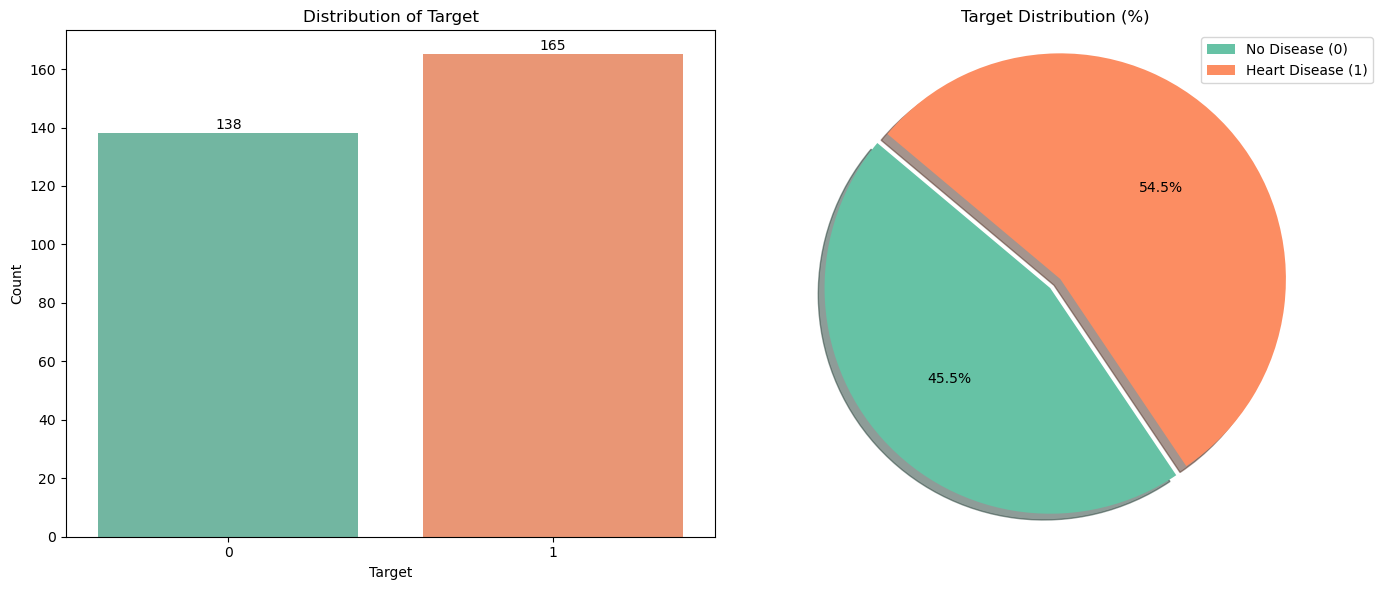

In [40]:
plot_target_distribution(data, 'target')

Analysis of the target variable distribution showed that cases with heart disease ($target = 1$) occur slightly more frequently—54.5%—than cases without disease ($target = 0$)—45.5%. The class balance is close to equal, but the slight prevalence of the positive class should be taken into account when building models and selecting evaluation metrics.

In [41]:
data['target'].unique()

array([1, 0])

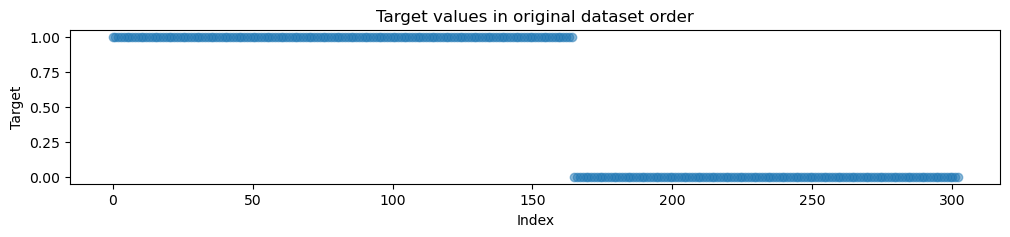

In [42]:
plt.figure(figsize=(12, 2))
plt.plot(data['target'].values, marker='o', linestyle='', alpha=0.5)
plt.title("Target values in original dataset order")
plt.xlabel("Index")
plt.ylabel("Target")
plt.show()

The plot shows that the values of the target variable, target, are ordered: first come all instances with label 1, and then those with label 0. This means that the data is initially sorted by the target variable, and without shuffling (shuffle=False), splitting the sample could result in distorted training and test sets. However, in the train_test_split function, the shuffle parameter is set to True by default, so shuffling is performed automatically. Nevertheless, we additionally verified this manually to ensure correctness.

In [43]:
df_split_test = data.copy()

X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(
    df_split_test.drop(['target'], axis=1),
    df_split_test['target'],
    test_size=0.2,
    random_state=0,
    stratify=df_split_test['target']
)

X_train_sp.shape, X_test_sp.shape

((242, 13), (61, 13))

In [45]:
X_test_sp

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
24   40.0  1.0  3.0     140.0  199.0  0.0      1.0    178.0    1.0      1.4   
67   45.0  0.0  1.0     130.0  234.0  0.0      0.0    175.0    0.0      0.6   
13   64.0  1.0  3.0     110.0  211.0  0.0      0.0    144.0    1.0      1.8   
112  64.0  0.0  2.0     140.0  313.0  0.0      1.0    133.0    0.0      0.2   
80   41.0  1.0  2.0     112.0  250.0  0.0      1.0    179.0    0.0      0.0   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
160  56.0  1.0  1.0     120.0  240.0  0.0      1.0    169.0    0.0      0.0   
234  70.0  1.0  0.0     130.0  322.0  0.0      0.0    109.0    0.0      2.4   
110  64.0  0.0  0.0     180.0  325.0  0.0      1.0      NaN    1.0      0.0   
190  51.0  0.0  0.0     130.0  305.0  0.0      1.0    142.0    1.0      1.2   
253  67.0  1.0  0.0     100.0  299.0  0.0      0.0    125.0    1.0      0.9   

     slope   ca  thal  
24     2.0  0.0   3.0  
67     1.0  0.0   2.0  
13     1.0  0.0   2.0  
112    2.0  0.0   3.0  
80     2.0  0.0   2.0  
..     ...  ...   ...  
160    0.0  0.0   2.0  
234    1.0  3.0   2.0  
110    2.0  0.0   2.0  
190    1.0  0.0   3.0  
253    1.0  2.0   2.0  

[61 rows x 13 columns]

In [696]:
y_test_sp.value_counts()

target
1    33
0    28
Name: count, dtype: int64

In [697]:
y_train_sp.value_counts()

target
1    132
0    110
Name: count, dtype: int64

In [698]:
print(y_train_sp.value_counts(normalize=True) * 100)
print(y_test_sp.value_counts(normalize=True) * 100)

target
1    54.545455
0    45.454545
Name: proportion, dtype: float64
target
1    54.098361
0    45.901639
Name: proportion, dtype: float64


After splitting the sample, taking into account shuffling ($shuffle=True$ by default) and the parameter $stratify=y$, the class ratio in the training and test sets remained almost the same as in the original dataset. This confirms that the stratified split was performed correctly—there is no data leakage or class imbalance skew.

### Correlation Matrices

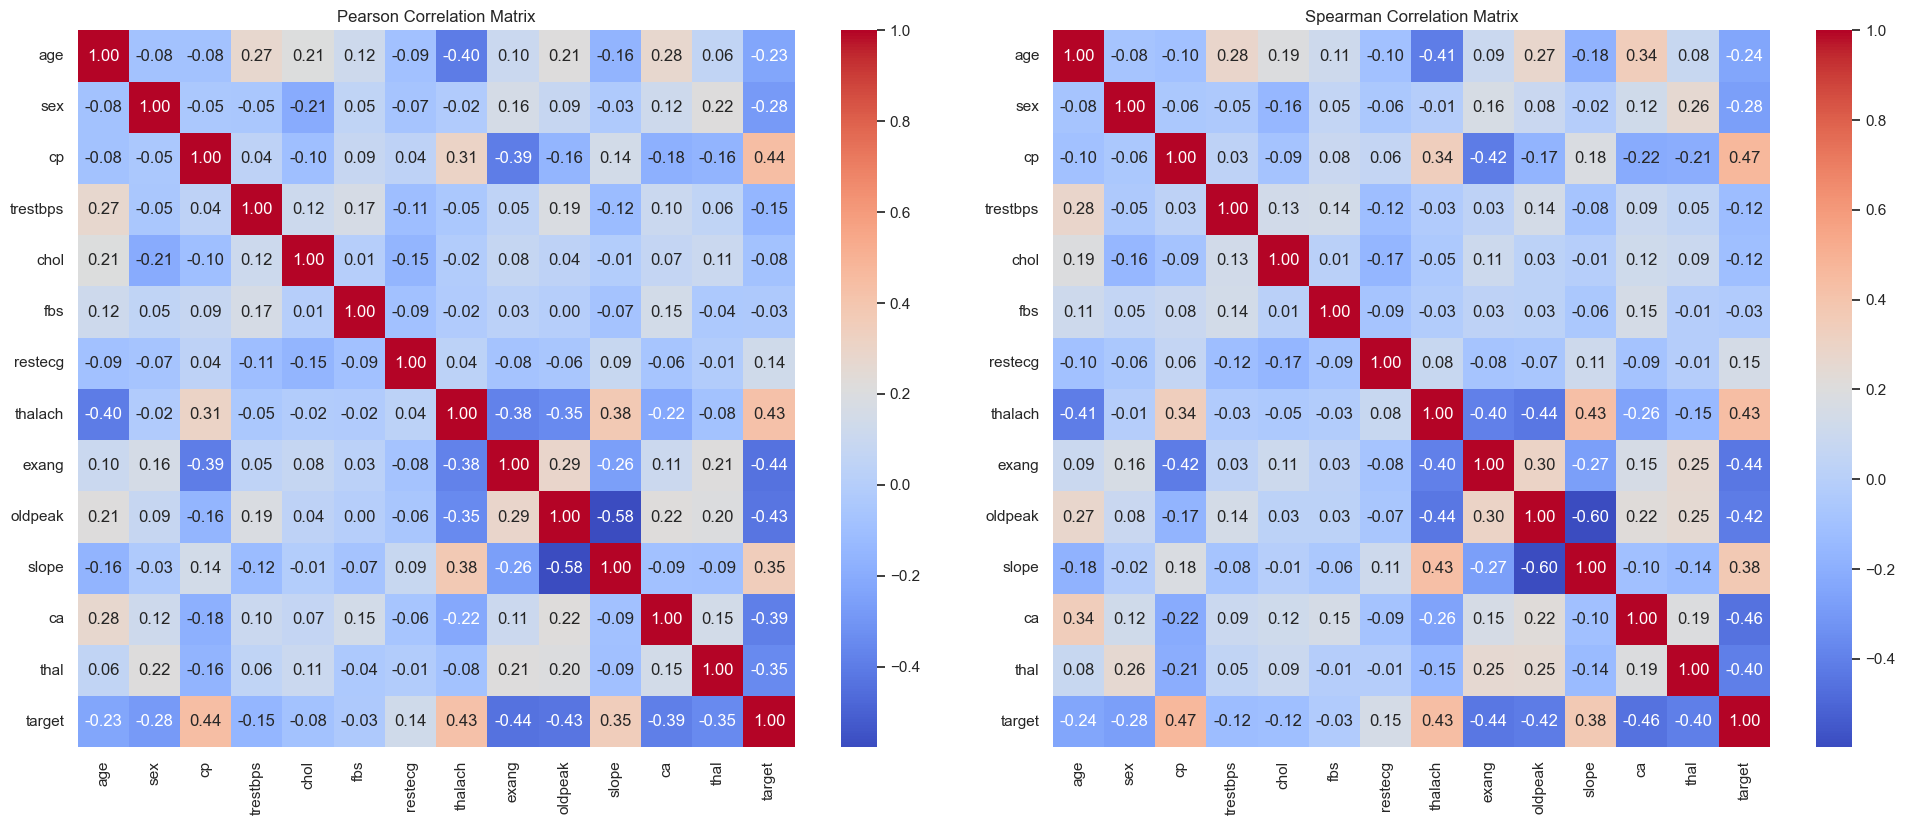

In [699]:
corr_matrix_pear, corr_matrix_spear = plot_correlation_heatmaps(data)

In [700]:
corr_matrix_pear['target'].sort_values(ascending=False)

target      1.000000
cp          0.439660
thalach     0.426427
slope       0.352365
restecg     0.135974
fbs        -0.034854
chol       -0.081018
trestbps   -0.150134
age        -0.228330
sex        -0.278841
thal       -0.345058
ca         -0.389066
oldpeak    -0.428600
exang      -0.439143
Name: target, dtype: float64

In [701]:
corr_matrix_spear['target'].sort_values(ascending=False)

target      1.000000
cp          0.466564
thalach     0.433151
slope       0.375686
restecg     0.147345
fbs        -0.034854
chol       -0.116191
trestbps   -0.124773
age        -0.241963
sex        -0.278841
thal       -0.404358
oldpeak    -0.419874
exang      -0.439143
ca         -0.455171
Name: target, dtype: float64

Based on the analysis of the correlation matrices (Pearson and Spearman), it can be concluded that none of the variables demonstrates a strong relationship with the target variable (target). Even the most correlated features, such as cp (chest pain type), thalach (maximum heart rate achieved), slope (the slope of the ST segment), oldpeak (ST depression), exang (exercise-induced angina), and ca (number of vessels colored by fluoroscopy), show only a moderate correlation (coefficient less than 0.7).

Nevertheless, variables with moderate correlation, such as cp (chest pain type), thalach (max heart rate), slope (ST segment slope), oldpeak (ST segment depression), exang (angina upon exertion), and ca (number of diseased vessels with contrast), may still be informative, especially in the context of complex models capable of identifying non-linear dependencies. It should also be noted that low correlation does not necessarily mean low importance—some features may be important in combination with others (interactions, non-linearities, etc.).

### Detect Multicollinearity

In [702]:
detect_multicollinearity_pairs(data, 0.7)

Empty DataFrame
Columns: [Var_1, Var_2, Corr_pearson, VS, Var_1, Var_2, Corr_spearman]
Index: []

In [703]:
detect_multicollinearity_pairs(data, 0.6)

Empty DataFrame
Columns: [Var_1, Var_2, Corr_pearson, VS, Var_1, Var_2, Corr_spearman]
Index: []

In [704]:
detect_multicollinearity_pairs(data, 0.5)

Var_1    Var_2  Corr_pearson VS  Var_1    Var_2  Corr_spearman
0  slope  oldpeak        -0.578  |  slope  oldpeak         -0.597

The dataset contains no features with strong multicollinearity at standard thresholds (0.7 and above). At a lower threshold (0.5), a moderate negative correlation was found between slope and oldpeak.

This level of relationship is not critical for most models but may be taken into account during the feature engineering stage—for example, one might test the exclusion of one of the features when working with linear models (Logistic Regression, Linear Regression) to reduce the potential influence of multicollinearity on coefficient stability.

### Missing Values

In [705]:
check_missing_values(data)


---------------------------------------------
Missing values are present in 13 columns
Total number of missing values: 69
Overall percentage of missing values: 1.63%
---------------------------------------------



Missing Values  Percentage
thalach               12        3.96
age                    9        2.97
cp                     6        1.98
chol                   6        1.98
slope                  6        1.98
exang                  5        1.65
ca                     5        1.65
trestbps               4        1.32
fbs                    4        1.32
sex                    3        0.99
restecg                3        0.99
oldpeak                3        0.99
thal                   3        0.99

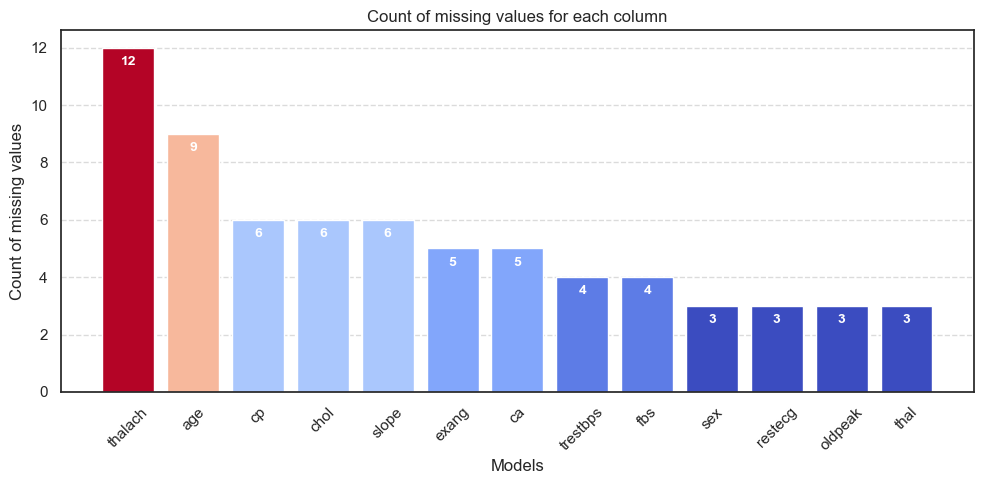

In [706]:
missing = data.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
norm = Normalize(vmin=missing.min(), vmax=missing.max())
colors = cm.coolwarm(norm(missing.values))

plt.figure(figsize=(10, 5))
bars = plt.bar(missing.index, missing.values, color=colors)
plt.title('Count of missing values for each column')
plt.ylabel('Count of missing values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Models')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.5, int(height), 
             ha='center', va='center', color='white', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

As a result of checking for missing values, it was revealed that 13 variables contain missing values, totaling 69 values, or 1.63% of all data points. The highest number of missing values is observed in the variable thalach—12 values (3.96%), followed by age with 9 missing values (2.97%), and cp, chol, and slope, each having 6 missing values (1.98%). The minimum number of missing values—3 values (0.99%)—is recorded in the variables sex, restecg, oldpeak, and thal.

Although the proportion of missing values in each variable does not exceed 5% and, according to generally accepted statistical guidelines, does not pose a critical threat to the analysis, even this level can be significant in medical data, as each missing value is potentially related to important clinical information. The next step should be to check whether the missing values are related to the target variable (target) or other features to determine their nature (MCAR, MAR, or MNAR) and make an informed decision about the handling methods.

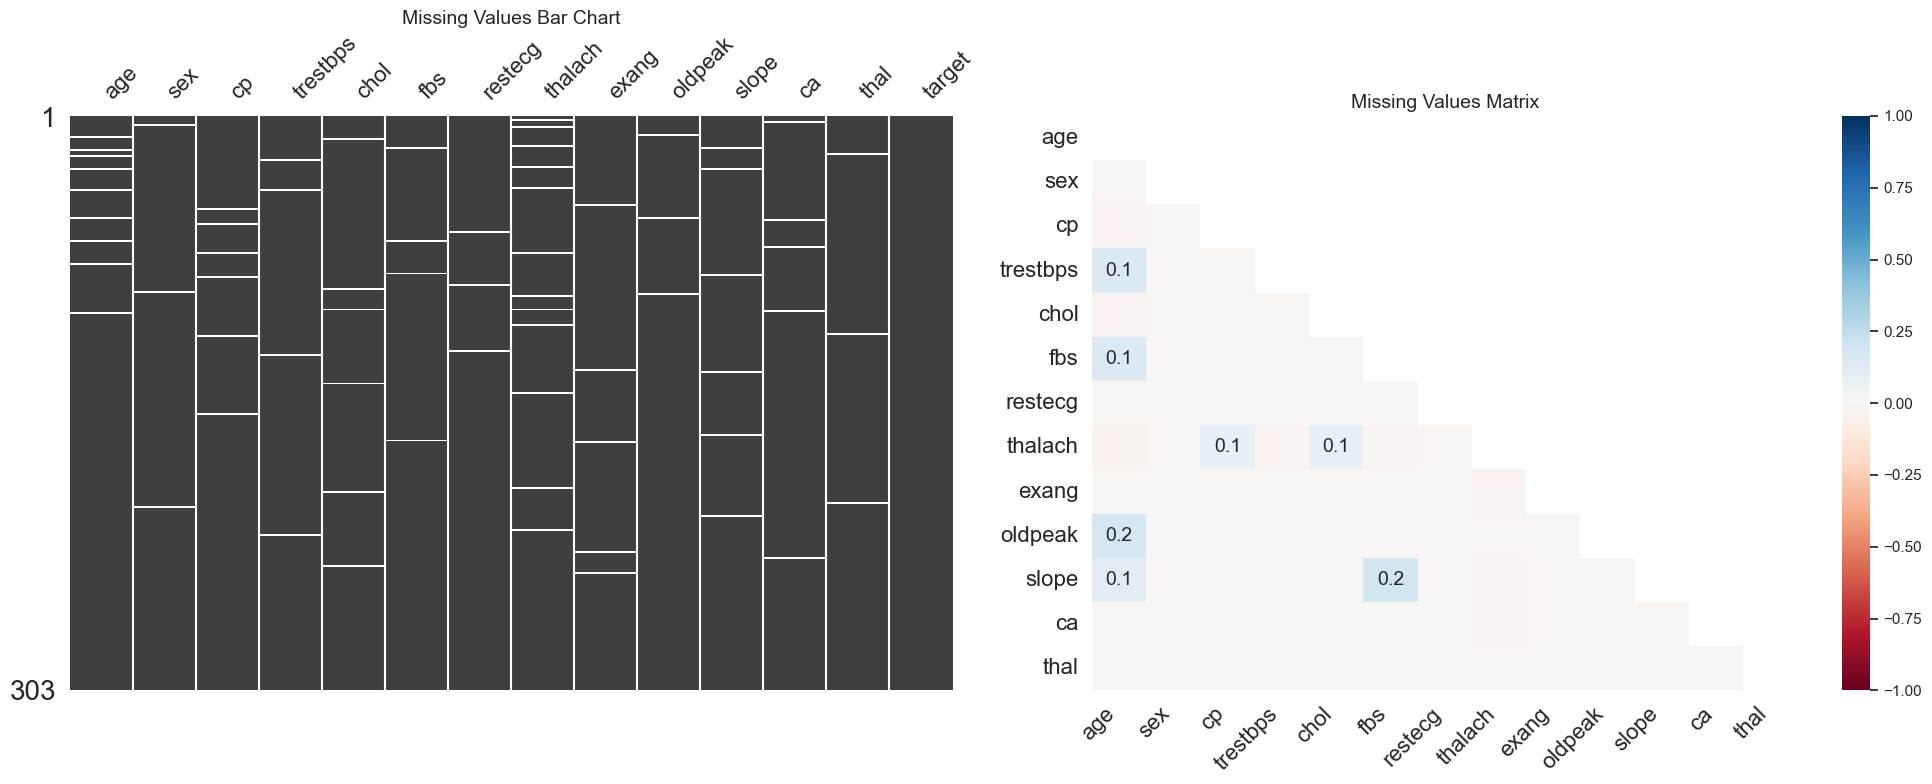

In [707]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Матрица пропусков
msno.matrix(data, ax=axes[0])
axes[0].set_title("Missing Values Bar Chart", fontsize=14)

# Тепловая карта корреляции пропусков
msno.heatmap(data, ax=axes[1])
axes[1].set_title("Missing Values Matrix", fontsize=14)

plt.tight_layout()
plt.show()

In the dataset, missing values are predominantly distributed randomly, with no pronounced dependency between variables: correlation coefficients in the missingness matrix do not exceed 0.2, which indicates a weak association. This distribution suggests that the missing values belong to the MCAR (Missing Completely At Random) or MAR (Missing At Random) categories and arise due to technical reasons: incomplete information entry, data collection errors, or lack of measurements for some observations. The probability of MNAR (Missing Not At Random) is low, but it cannot be entirely ruled out without further analysis.

### Feature-wise Analysis

In [708]:
data.columns.tolist()

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

#### The Age Variable

Age — patient's age in years.

Age is one of the most significant risk factors for cardiovascular diseases (CVD) and has been extensively studied in clinical research. According to the American Heart Association (AHA), the risk of developing cardiovascular disease triples with every passing decade of life. Based on the Framingham Heart Study, the likelihood of developing coronary artery disease (CAD), stroke, and heart failure dramatically increases after the age of 45 in men and 55 in women. This is attributed to natural age-related changes—a decrease in vascular elasticity, thickening of arterial walls, the accumulation of atherosclerotic plaques, and a reduction in the heart's reserve capacity. Furthermore, chronic low-grade inflammation ("inflammaging"), which accelerates vascular aging and increases CVD risk, intensifies with age.

In [709]:
data['age'].describe()

count    294.000000
mean      54.394558
std        9.106168
min       29.000000
25%       47.250000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

The age feature in the dataset contains 294 non-missing observations. The mean age of participants is approximately 54.4 years, and the standard deviation is about 9.1 years, which indicates a moderate dispersion of values around the mean. The minimum age is 29 years, and the maximum is 77 years, suggesting a sufficiently wide age range.

The median (56 years) is slightly higher than the mean, and the quartiles are distributed as follows: 25% of participants are younger than 47.25 years, 50% are younger than 56 years, and 75% are younger than 61 years. This may indicate a small skew of the distribution towards younger participants, but overall, the age sample is balanced with a predominance of middle-aged and elderly individuals.

##### Missing Values

===== Missing Values Analysis for: age =====
Missing in age: 9 (2.97%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0            100.0      0.0
1             94.5      5.5
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.01446

Missing values are likely NOT MCAR (depend on target). Possible MAR or MNAR.


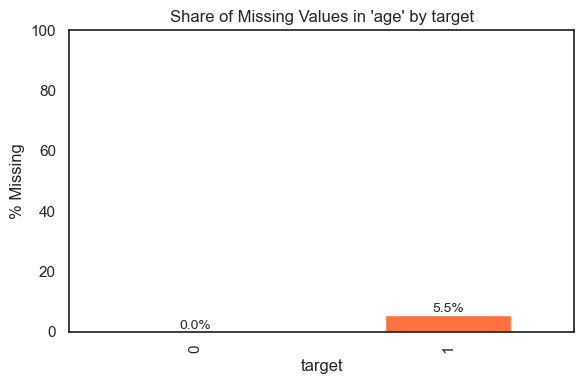

In [710]:
missing_values_report_plot(data, 'age')

Вот перевод предоставленного текста на английский язык:For the age variable, 9 missing values ($\approx 2.97\%$) were found. They are distributed unevenly across the target variable classes: there are no missing values among patients with $target=0$ ($0\%$), whereas the proportion of missing values among patients with $target=1$ is $\approx 5.5\%$. The $\chi^2$ test for the dependency of the missingness fact on target yields a $p$-value of $0.01446$, meaning the relationship is statistically significant.This may indicate that the missing values in age are not MCAR (not "Missing Completely At Random"); they are more likely to be MAR (dependent on other factors related to the disease) or MNAR (the disease/patient's condition itself might have influenced the absence of the age record).However, the effect only involves 9 rows, so the practical influence is small, but potentially informative. For imputation, one should consider multivariate imputation (KNN/MICE) using clinically related features (e.g., sex, cp, trestbps, chol, thalach), or use simple median imputation as a baseline check.

##### Distribution and Outliers

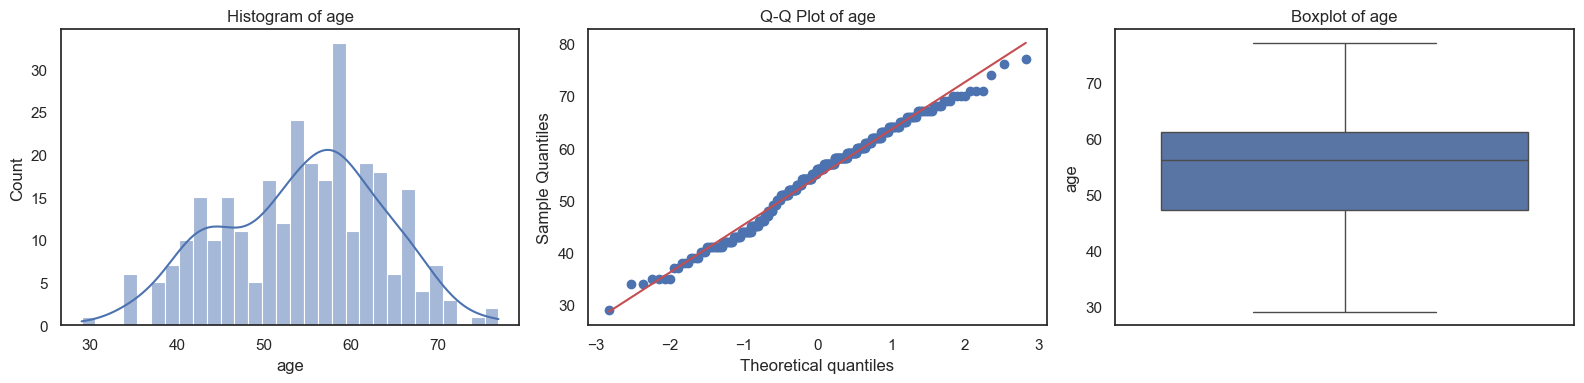

In [711]:
diagnostic_plots(data, 'age')

The age variable has an approximately normal distribution, which is confirmed by both the histogram with KDE and the Q-Q plot, where the points mostly lie on the straight line, with slight deviations in the tails of the distribution. This suggests that the age data is close to a normal distribution, but slight deviations are possible at the ends of the range. The boxplot shows that there are no outliers, and the median is approximately around 56 years, with most observations falling in the range of 47 to 61 years. Thus, the variable appears stable and does not contain anomalous values, which simplifies its further use in models.

##### Target Rate by Age

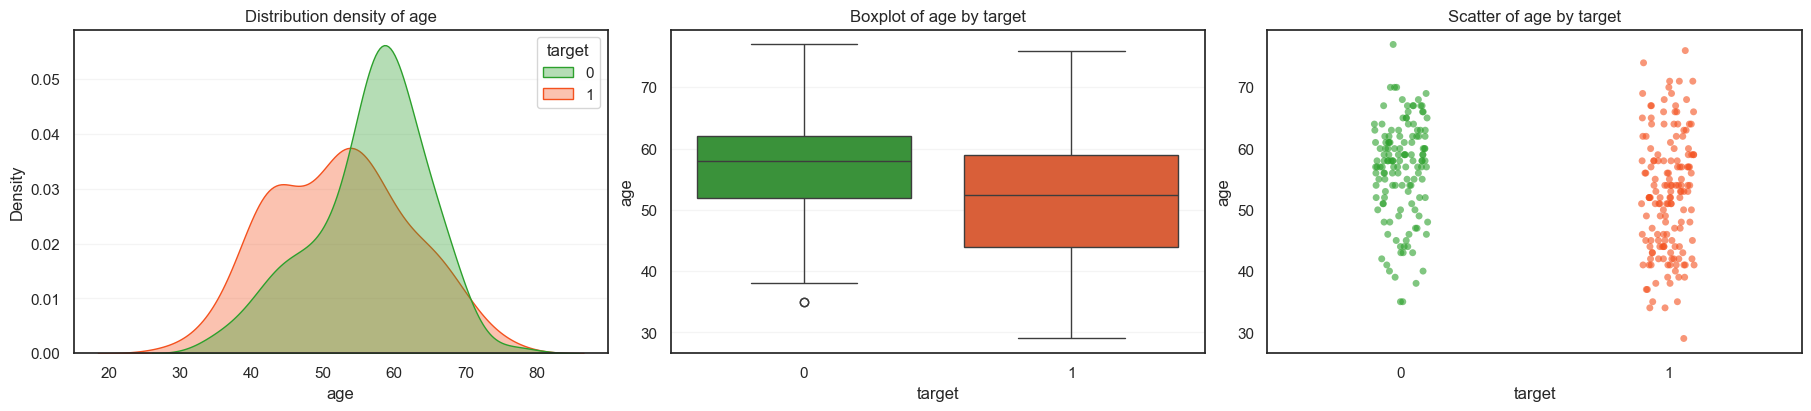

In [712]:
analyze_feature_vs_target(data, 'age')

Analysis of Age Distribution by Target Variable.    
1. Differences in Age DistributionThe kernel density estimation (KDE) plot shows that patients with heart disease (orange line, $target=1$) tend to be younger than healthy individuals (green line, $target=0$).  The peak distribution for sick patients is approximately 50–55 years, while for healthy individuals, it is closer to 60 years.
2. Dispersion and MediansThe boxplot confirms that the median age of sick patients is lower than that of healthy patients.  The group with $target=1$ also shows greater dispersion and the presence of younger patients (around 30 years), which is absent in the $target=0$ group.
3. Data StructureThe scatter plot indicates that the age groups overlap, but sick patients noticeably have more representatives under 50 years old, while healthy patients are concentrated in the 55–65 age range.

The sample shows that a significant proportion of patients with heart disease are around 50 years old, while patients without the disease are more often older. This diverges from the typical clinical picture where the risk of cardiovascular disease increases with age due to atherosclerosis, reduced vascular elasticity, and chronic inflammation ("inflammaging").

However, this structure may be explained by the specifics of the sample: the data was collected among patients who had already sought medical care, rather than from a randomly selected population. This means that younger participants were typically included in the sample precisely because of serious symptoms or an already diagnosed heart condition—that is, their visit was motivated by acute or pronounced problems. Older patients, on the other hand, might have visited for entirely different reasons: routine check-ups, chronic disease control, or preventive visits, which could lead to a larger number of relatively healthy representatives in the older age group.

Medical studies (including the Framingham Heart Study and guidelines from the American Heart Association) show that early cases of CAD and myocardial infarction (35–55 years) are often linked to aggressive risk factors—smoking, dyslipidemia, arterial hypertension, diabetes, and a strong family history. Therefore, the high proportion of affected individuals under 50 in our sample may reflect the influence of these modifiable risk factors.

To test this hypothesis, it is appropriate to analyze the distribution of key risk factors (cp—chest pain type, chol—cholesterol level, trestbps—resting blood pressure, fbs—fasting blood sugar, thalach—maximum heart rate achieved, oldpeak—ST segment depression) across three age groups.

We are dividing the age variable into three groups—<50 years, 50–59 years, and $\ge 60$ years—based on clinical and epidemiological data. According to the Framingham Heart Study, a sharp jump in cardiovascular disease risk is observed between the ages of 50–59, and after 60, the risk reaches its maximum, though the growth rate slows. The INTERHEART Study showed a significant increase in risk starting as early as 40–49 years, and AHA and ESC guidelines use 10-year age intervals in their analyses. Additionally, menopause occurs around age 50 in women, leading to a sharp increase in risk due to the decline of estrogen's cardioprotective effect, and active screening and potential statin therapy are clinically warranted for men after age 45. This division allows us to align our analysis with recognized medical standards and identify differences in significant features across key age categories.

Comparing these subgroups may reveal which risk factors primarily contribute to the early onset of the disease and whether they differ from the profile of older patients.

In [713]:
discrete_cols = data.columns[data.nunique() < 10].tolist()
discrete_cols.remove('target')
discrete_cols

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [714]:
continuous_cols = [val for val in data.columns  if val not in discrete_cols and val != 'target']
continuous_cols

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

##### Age-Stratified Feature Analysis vs Target



One-way ANOVA for 'trestbps' by age group:
F = 12.354, p = 0.0000


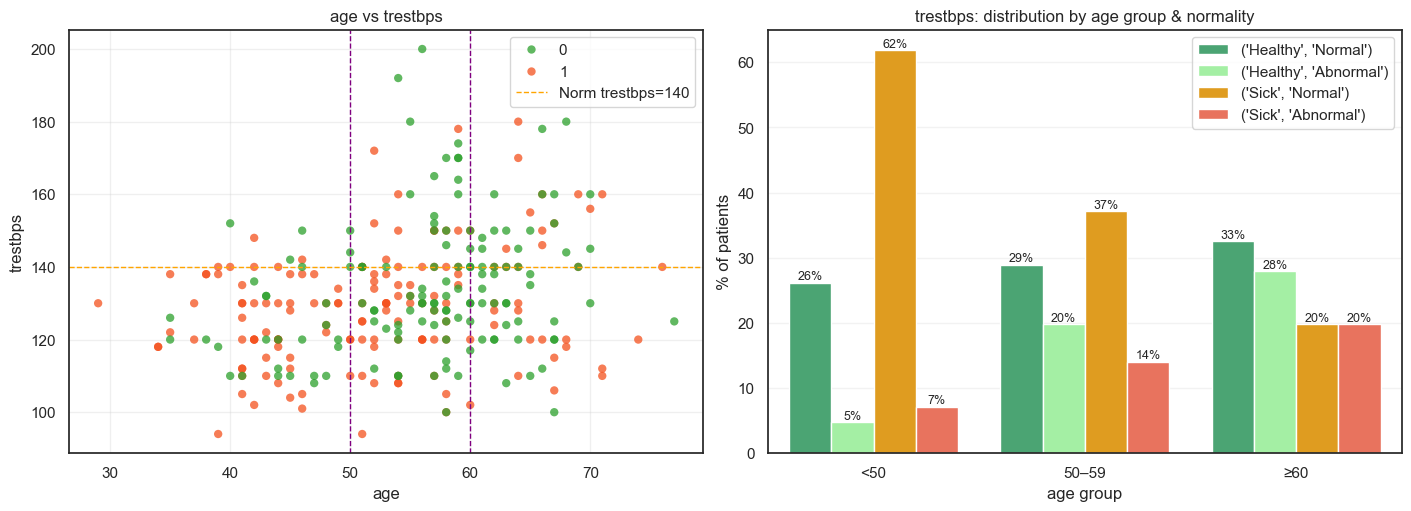



One-way ANOVA for 'chol' by age group:
F = 5.719, p = 0.0037


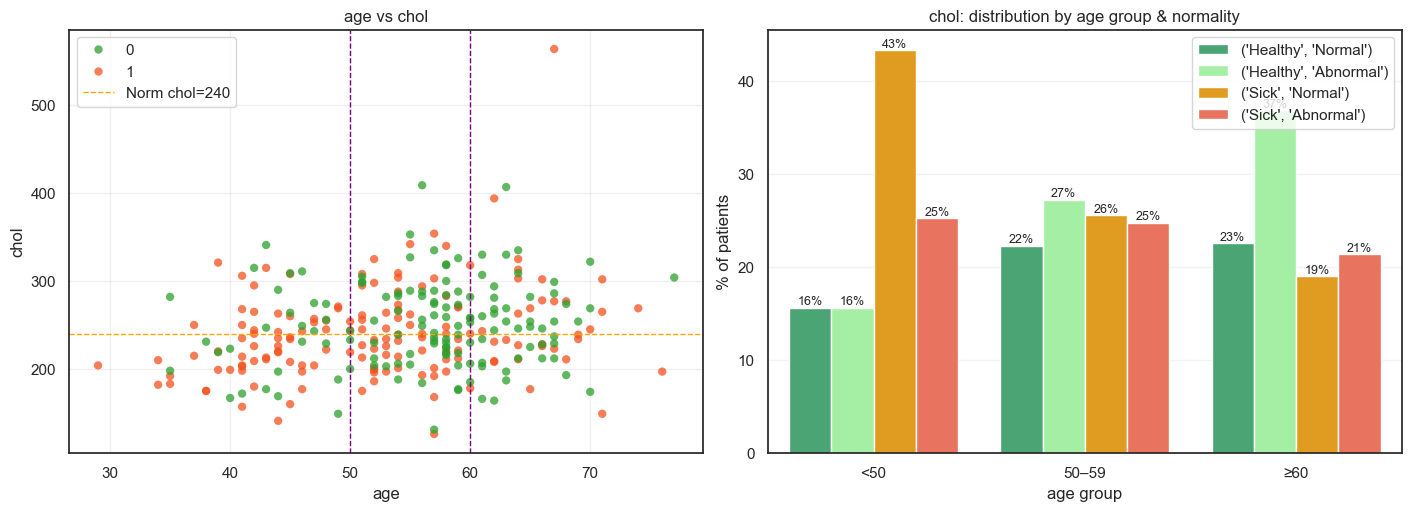



One-way ANOVA for 'thalach' by age group:
F = 22.564, p = 0.0000


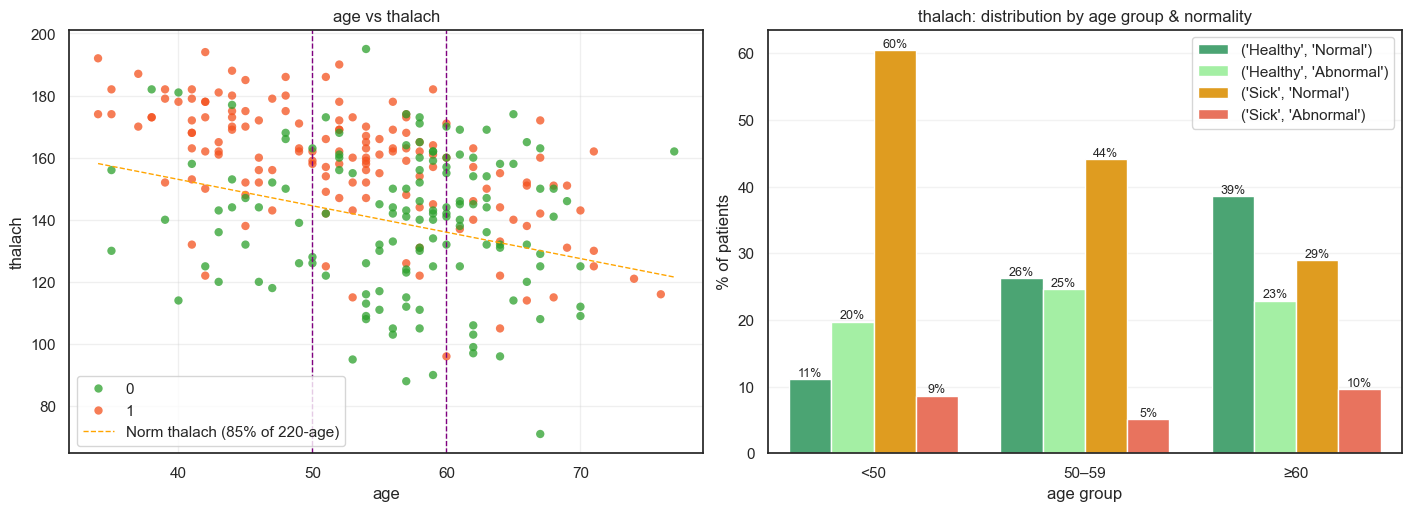



One-way ANOVA for 'oldpeak' by age group:
F = 9.901, p = 0.0001


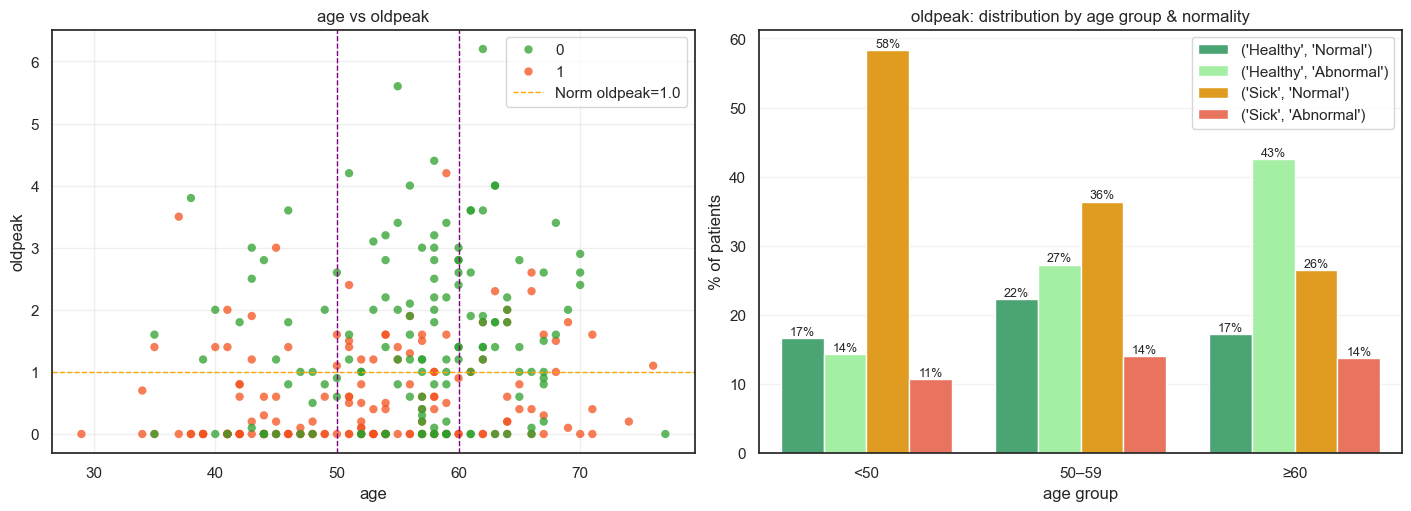

In [715]:
for val in [col for col in continuous_cols if col != 'age']:
    plot_continuous_vs_target_by_age(data, val)

Analysis of Key Clinical Risk Factors by Age Group

trestbps - Resting Blood Pressure

Despite statistically significant differences in mean resting blood pressure across age groups (ANOVA: $F = 12.354$, $p = 0.0000$), the trestbps variable does not demonstrate high diagnostic value within the age categories themselves.  In patients under 50, the vast majority (62% of sick and 26% of healthy) have normal blood pressure, while elevated pressure is rare—only 7% of sick and 5% of healthy individuals. In the 50–59 group, the differences become slightly more noticeable: elevated pressure is observed in 14% of sick and 20% of healthy patients, but this does not change the overall picture. In the oldest age group ($\ge 60$ years), the distribution becomes more uniform: among the sick, blood pressure is normal in 20% and elevated in 20%, while among the healthy, it is normal in 33% and elevated in 28%. Thus, although trestbps statistically differs across ages, it does not reliably distinguish between healthy and sick individuals within age groups and should be considered only an auxiliary parameter in a comprehensive risk assessment.

chol - Serum Cholesterol Level

Analysis of chol showed statistically significant differences across age groups (ANOVA: $F = 5.719$, $p = 0.0037$); however, within age categories, cholesterol weakly differentiates between sick and healthy individuals.  In patients under 50, the majority of sick patients (43%) have normal cholesterol, and the proportion with elevated levels is nearly the same for the sick (25%) and the healthy (16%). In the 50–59 group, differences are minimal, and among the elderly ($\ge 60$), even healthy individuals are more likely to have elevated cholesterol (37%) than the sick (21%). Thus, despite the age-related dynamic, chol is not a reliable predictor of disease within the age groups.

thalach - Maximum Heart Rate Achieved

The thalach variable demonstrates pronounced statistical differences across age groups (ANOVA: $F = 22.564$, $p = 0.0000$), reflecting the natural decrease in maximum heart rate with age.  Unlike other features, thalach shows a relatively stable association with the presence of disease: in patients under 50, 60% of sick patients have normal thalach values, while this proportion is only 11% among the healthy; in the 50–59 and $\ge 60$ groups, the differences persist, though they become less pronounced. However, it is important to consider that in elderly patients ($\ge 60$ years), the high proportion of "normal" values may not be due to objective heart function but to the limitations of the stress test itself. Maximum heart rate physiologically decreases with age, and it is often more difficult for the elderly to reach the exertion threshold necessary to detect pathology. Moreover, some older patients may undergo simplified or pharmacological versions of the stress test, or the test may be terminated before target values are reached—all of which artificially inflate the proportion of "normal" thalach among the elderly.    
Thus, while thalach remains one of the most informative features in young and middle-aged individuals, its diagnostic value in the elderly may be inflated due to peculiarities in test administration.

oldpeak - ST Depression Induced by Exercise Relative to Rest

The oldpeak variable (ST segment depression after exercise) demonstrates statistically significant differences across age groups (ANOVA: $F = 9.901$, $p = 0.0001$).  Since this indicator, like thalach, is related to stress test results, its values directly depend on the level of physical exertion the patient sustained. The group under 50 shows the most informative differences: 58% of sick patients have "normal" oldpeak values, while "abnormal" values are recorded in 11% of sick and 14% of healthy patients. In the 50–59 age group, the differences are less pronounced: the proportion with abnormal values increases among the sick (14%), and a high percentage of normal indicators persists among the healthy (22%). However, in the $\ge 60$ group, the situation changes: 43% of healthy individuals have abnormal oldpeak values, while "normal" values dominate among the sick (26%). This may be explained by the fact that elderly patients are more often assigned less intense or prematurely terminated exertion, or the test is not fully completed due to medical indications. As a result, oldpeak may be underestimated, regardless of the presence of ischemia. Additionally, age-related changes in the ECG may reduce the accuracy of ST-segment interpretation. Thus, like thalach, the oldpeak variable is less reliable in the elderly and most significant in middle age, where patients are capable of completing a full stress test.


[≤50] Chi-square p-value for sex ~ target: 0.0007269
[51–60] Chi-square p-value for sex ~ target: 0.01483
[>60] Chi-square p-value for sex ~ target: 0.01002


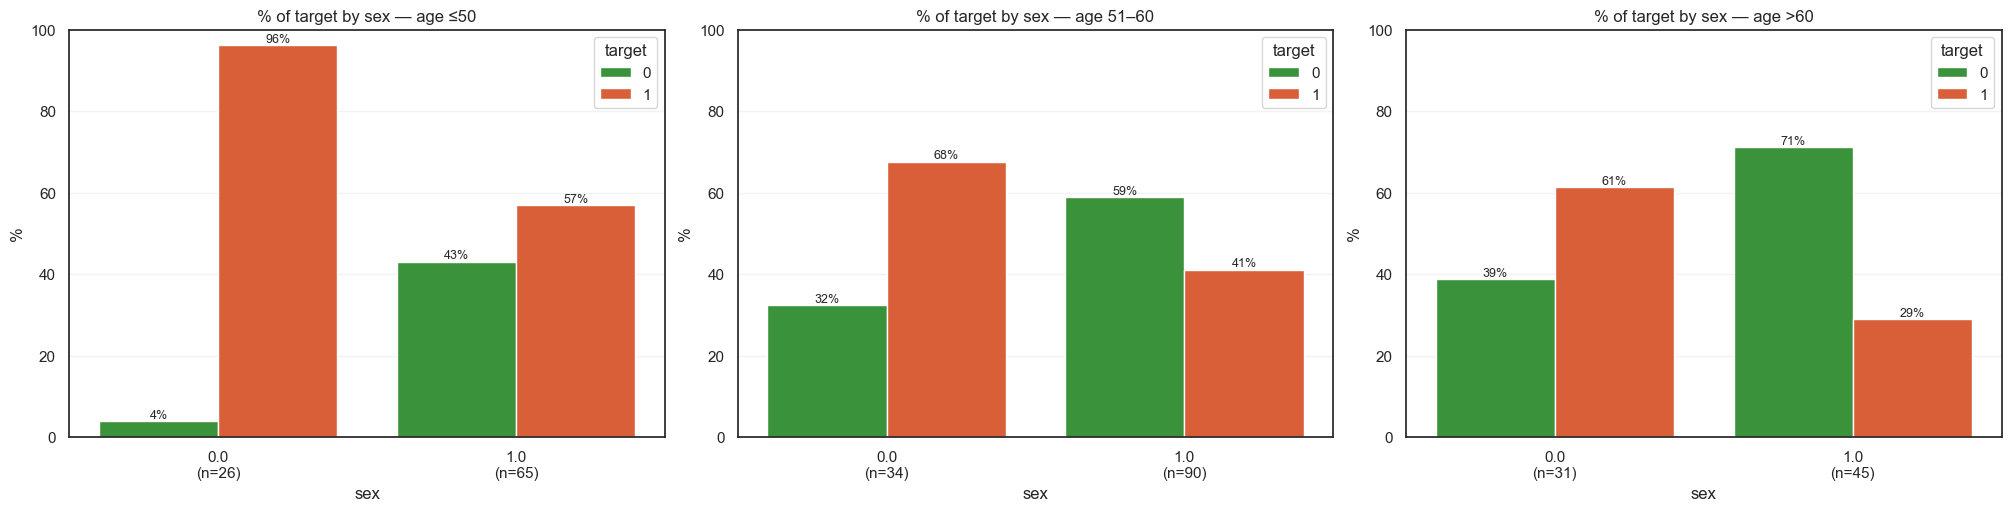


[≤50] Chi-square p-value for cp ~ target: 1.994e-05
[51–60] Chi-square p-value for cp ~ target: 3.266e-08
[>60] Chi-square p-value for cp ~ target: 0.002532


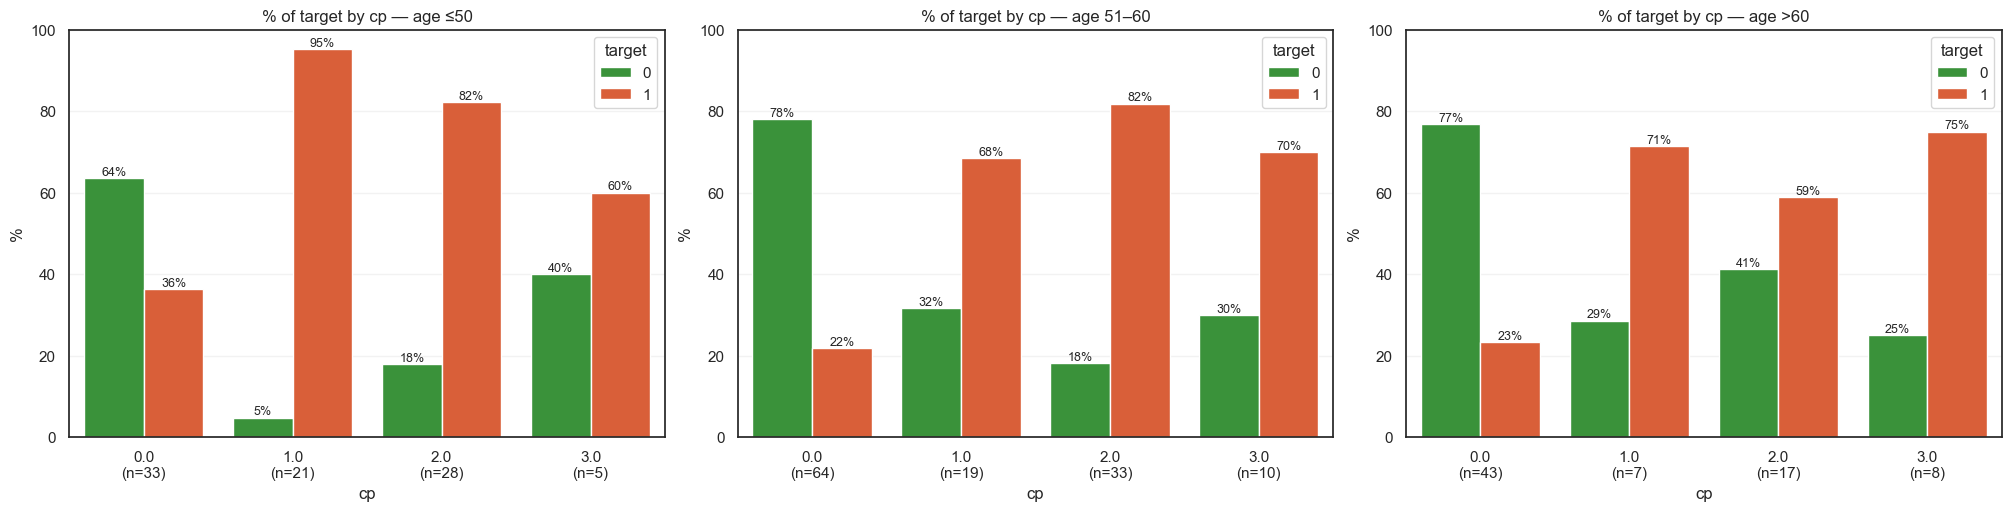


[≤50] Chi-square p-value for fbs ~ target: 0.5632
[51–60] Chi-square p-value for fbs ~ target: 1
[>60] Chi-square p-value for fbs ~ target: 1


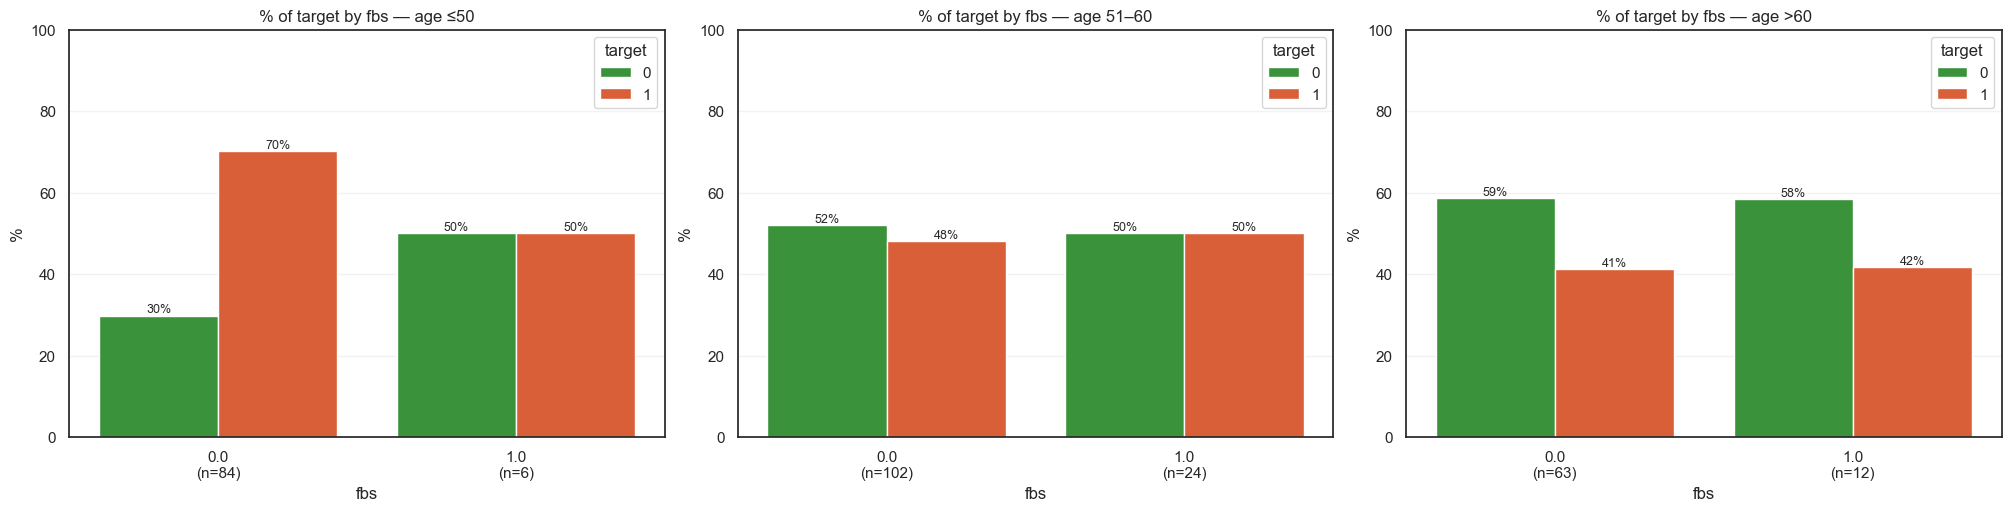


[≤50] Chi-square p-value for restecg ~ target: 0.101
[51–60] Chi-square p-value for restecg ~ target: 0.1097
[>60] Chi-square p-value for restecg ~ target: 0.2461


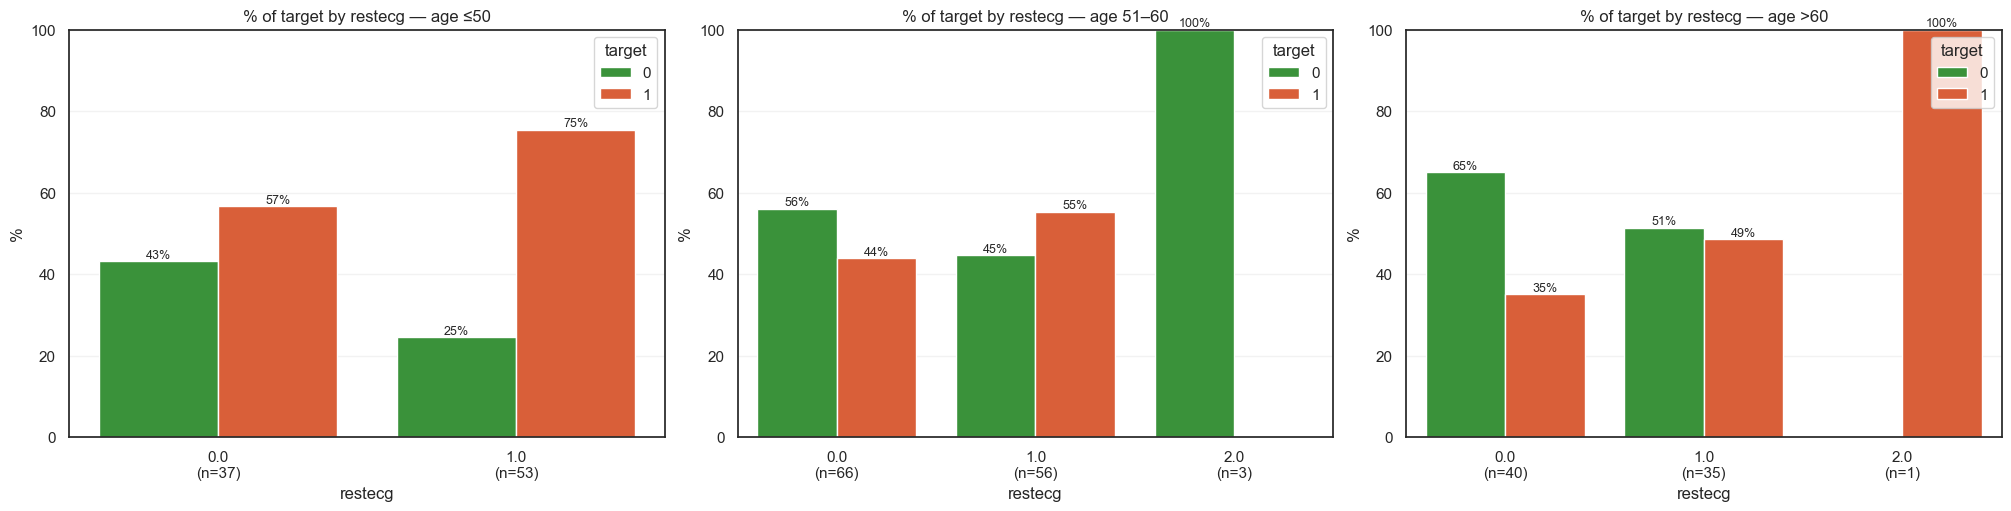


[≤50] Chi-square p-value for exang ~ target: 9.722e-05
[51–60] Chi-square p-value for exang ~ target: 4.232e-07
[>60] Chi-square p-value for exang ~ target: 0.004389


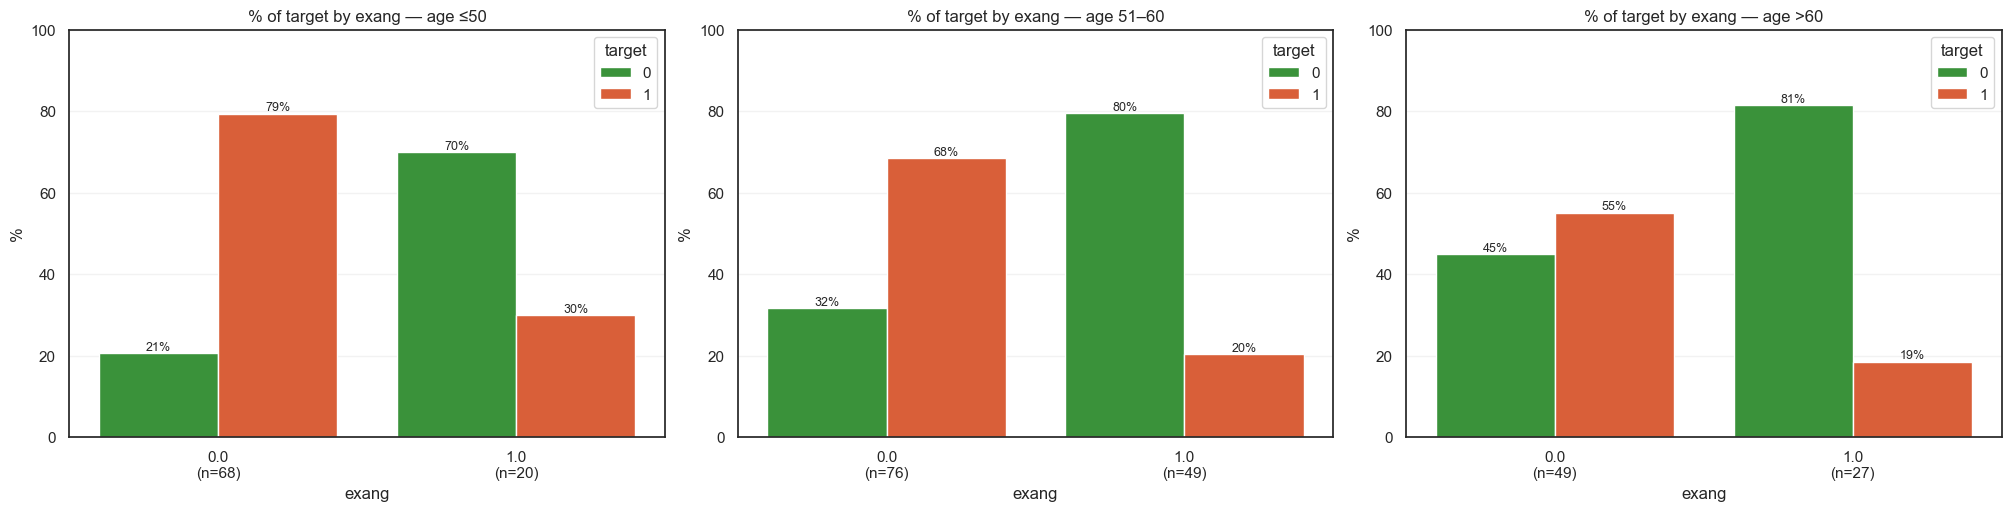


[≤50] Chi-square p-value for slope ~ target: 0.003379
[51–60] Chi-square p-value for slope ~ target: 2.946e-05
[>60] Chi-square p-value for slope ~ target: 0.02345


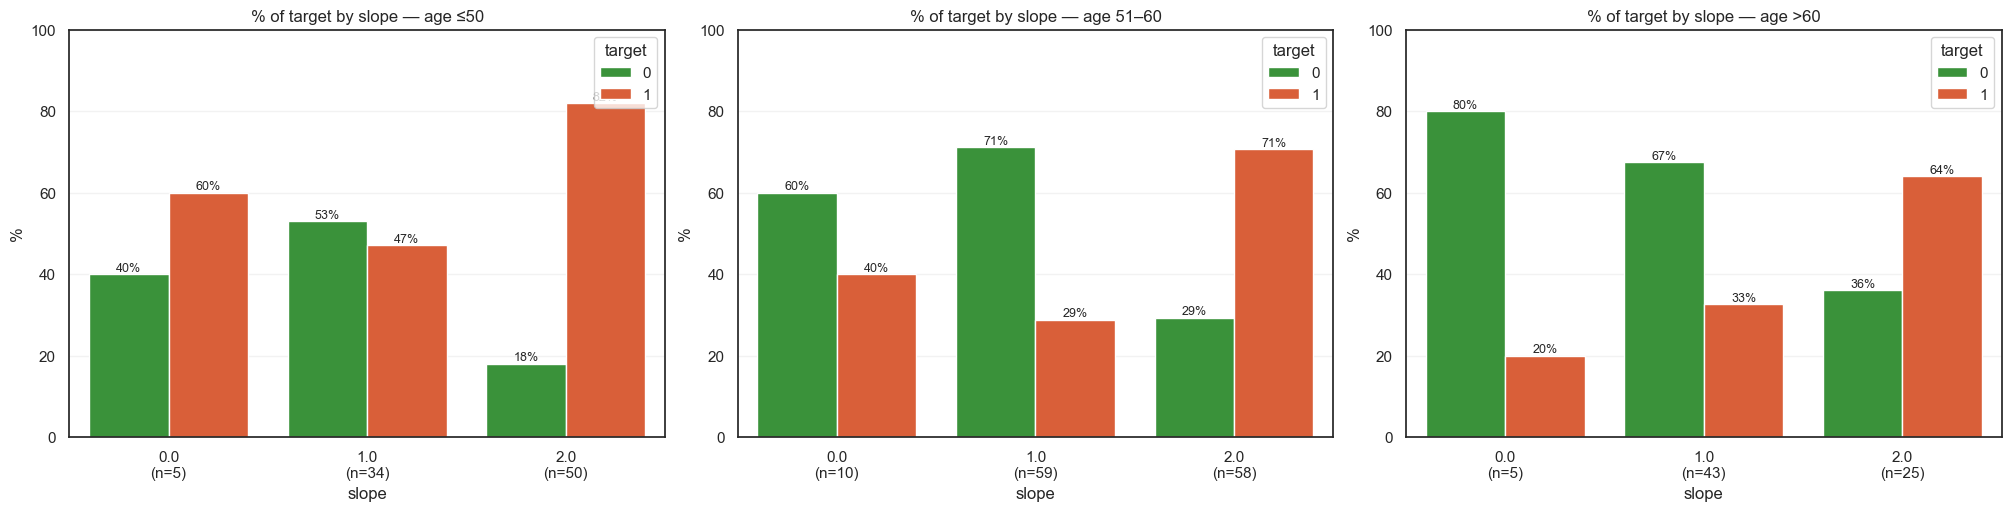


[≤50] Chi-square p-value for ca ~ target: 0.03775
[51–60] Chi-square p-value for ca ~ target: 4.935e-09
[>60] Chi-square p-value for ca ~ target: 0.008159


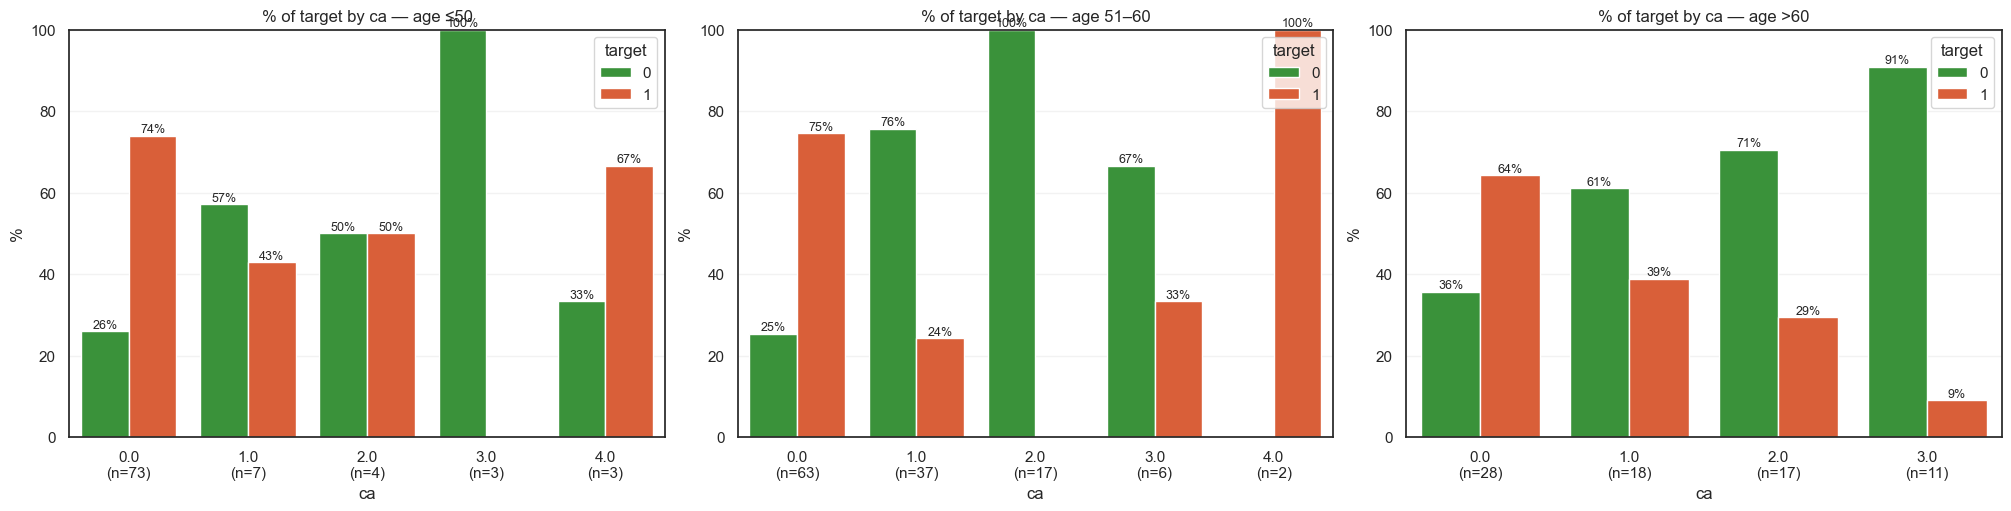


[≤50] Chi-square p-value for thal ~ target: 3.265e-10
[51–60] Chi-square p-value for thal ~ target: 8.299e-07
[>60] Chi-square p-value for thal ~ target: 0.0166


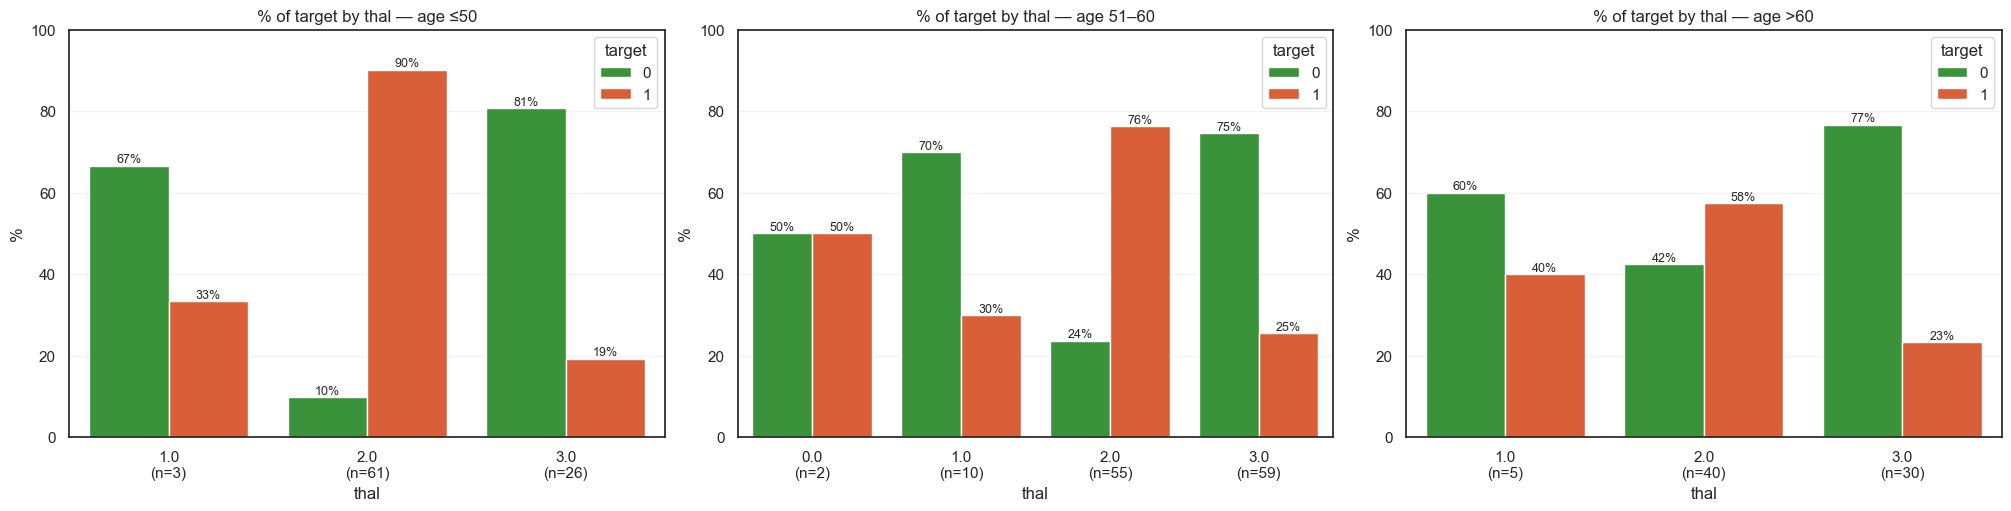

In [716]:
for val in discrete_cols:
    plot_discrete_vs_target_by_age(data, val)

Analysis of Categorical Risk Factors by Age Group

sex - Gender

In all age groups, gender is statistically significantly associated with the presence of the disease ($p < 0.05$). The association is particularly pronounced in women under 50: 96% of them had a positive diagnosis, compared to only 57% of men of the same age. This contradicts widely known medical data, according to which pre-menopausal women have a lower risk of cardiovascular disease due to the protective effect of estrogens.
This anomaly might be explained by:
* The small number of women in the sample ($n=26$).
* Possible data bias (e.g., predominantly symptomatic patients included).
* Errors in coding or data collection.
In the middle-aged group (51–60 years), the disease was more common in women (68%) compared to men (41%), which also seems unusual. In the oldest age group ($\ge 60$ years), the expected ratio is still not restored: women continue to be affected more often (61% vs. 29% for men). Thus, despite the statistical significance, the results require cautious interpretation and validation of medical plausibility, especially in the youngest age group.

cp - Chest Pain Type

Analysis of the cp variable (chest pain type) across the three age groups shows a stable and statistically significant association with the presence of the disease. In all ages, the values $cp=1$, $cp=2$, and $cp=3$ (various types of chest pain) are noticeably more frequent in sick patients, while $cp=0$ (asymptomatic) dominates among healthy individuals. This is particularly evident in patients under 50, where 95% are sick with $cp=1$, and 82% are sick with $cp=2$. The association persists in the 51–60 and $\ge 60$ age groups, confirmed by extremely low $p$-values (all $< 0.01$). This stable pattern indicates the high predictive power of the cp variable, regardless of age, making it a reliable feature for building diagnostic models.

fbs (fasting blood sugar) - Fasting Blood Glucose Level

Based on the plots and statistical tests, the fbs variable does not show a statistically significant association with the presence of heart disease in any age group ($p$-value $> 0.05$ in all three groups). This is particularly noticeable in the 51–60 and $\ge 60$ age groups, where the $p$-value is 1. Even in the $\le 50$ group, despite the difference in proportions (70% sick at $fbs=0$), the $fbs=1$ sample includes only 6 observations, making the conclusions unreliable.
Meanwhile, according to medical data, high blood sugar is an important risk factor for CAD, especially in diabetic patients. However, in this dataset, the fbs variable, reflecting only a single binary snapshot (fasting $>120$ mg/dL or not), does not fully capture the patient's glycemic profile. This may explain the lack of a significant association. It is possible that fbs will acquire prognostic value in combination with other variables, such as gender, blood pressure, or cholesterol.

restecg - Resting Electrocardiographic Results

The restecg variable (resting ECG results) has high clinical significance in diagnosing heart disease, especially the value 2, which corresponds to left ventricular hypertrophy. However, its distribution across age groups in the current dataset is highly uneven: the value 2 is completely absent in patients under 50, is present in only 3 observations in the 51–60 group (all healthy), and only one case in the $\ge 60$ group (sick). In all three age subgroups, the $\chi^2$ $p$-value is above 0.1, and statistical significance is not reached. This is likely due not to the absence of a real relationship, but to the insufficient number of observations and imbalance between categories. Thus, despite the lack of significant results in the age-based analysis, restecg should not be excluded: in conjunction with other variables, it may show prognostic power.

exang (exercise-induced angina) — Chest Pain upon Physical Exertion

Regardless of the age group, the exang variable demonstrates a ** strong association** with the probability of heart disease. This is particularly noticeable in the age group under 50: among those who do not experience exercise-induced angina ($exang = 0$), almost 80% are sick, while among those who do experience angina upon exertion ($exang = 1$), only 30% are sick. A similar pattern is observed in other age groups: across all ages, there are significantly more healthy individuals among those who have angina upon exertion. This is confirmed by extremely low $p$-values (all below 0.005), indicating a statistically significant relationship between exang and the presence of CAD. This relationship is also consistent with medical knowledge: the presence of angina upon exertion points to physical tolerance and stable coronary blood flow, whereas its absence against the backdrop of disease may be a marker of hidden but pronounced abnormalities. Furthermore, the number of observations in each group is sufficient for reliable conclusions. All this makes exang one of the key predictors in our analysis.

slope (slope of the peak exercise ST segment) — Indicator assessed on ECG during or immediately after exercise.

The slope variable (slope of the ST segment on the ECG during exercise) shows a statistically significant association with heart disease in all age groups ($p < 0.05$), but the nature of this relationship varies with age. In the group under 50, the value $slope = 0$ is associated with a larger proportion of sick (60%) than healthy (40%), but the number of observations in this subcategory is extremely small ($n=5$), making conclusions risky. At the same time, the value $slope = 2$ in this group ($n=50$) demonstrates a high proportion of sick individuals—82%, confirming the association of this value with the presence of the disease. In the 51–60 age group, a similar pattern occurs: $slope = 0$ again predominantly contains sick individuals (60%, $n=10$), but the largest share of sick individuals still belongs to $slope = 2$ (71%, $n=58$), while for $slope = 1$, healthy individuals prevail. Only in the $\ge 60$ group is the completely expected distribution observed: $slope = 2$ has 64% sick, $slope = 1$ has 33%, and $slope = 0$ has only 20%; however, here too, the $slope = 0$ subgroup has only 5 observations. Thus, despite the generally logical trend, localized distortions are noticeable in the younger age groups, which may be related to small sample sizes.

ca - Number of Major Vessels Colored by Fluoroscopy

Analysis of the relationship between the number of major vessels affected and the presence of cardiovascular disease revealed that the strength of this association depends on age. The 51–60 age group shows the highest predictive significance: all patients with $ca=4$ (2 observations) are sick, while with $ca=2$, conversely, all are healthy. In young people under 50 and the elderly over 60, the association weakens and becomes nonlinear: in the elderly, only 9% of sick patients have $ca=3$, and the value $ca=4$ is completely absent. Manual checking confirmed that there is not a single observation with $ca=4$ in the $\ge 60$ age group, which may be explained by both biological and statistical reasons. Biologically, patients with severe vascular damage ($ca=4$) at the age of 50+ have an extremely high risk of complications and mortality, and often do not live to 60 or undergo surgical treatment (bypass, stenting), after which they may be excluded from the study sample. Statistically, such observations are extremely rare (even in the 51–60 group, there are only 2 people), making the percentages sensitive to small changes and prone to bias. This data underscores the need to consider age when interpreting ca and shows that anatomical obstruction may be less informative for elderly patients than for younger ones.

thal - Thallium Stress Test Results — Instrumental Diagnosis of Coronary Artery Disease.

The thal variable demonstrates high prognostic significance for the diagnosis of coronary artery disease, especially in patients under 60 years old. In the $\le 50$ group, the normal value $thal=1$ is extremely rare (3 observations), indicating a dominance of pathological variants. A fixed defect ($thal=2$) is associated with the disease in 90% of cases, and a reversible defect ($thal=3$) is associated with normalcy (81% healthy), confirmed by an extremely significant $p$-value ($3.26 \times 10^{-10}$). In the 51–60 age group, the proportion of pathological values increases, the association remains pronounced ($p = 8.3 \times 10^{-7}$), but anomalous $thal=0$ codes occur (2 cases), which are interpreted in the literature as erroneous and should be excluded or replaced with NA. In patients over 60, the prognostic power of thal decreases ($p = 0.0166$), which is associated with objective medical factors: the limited use of stress tests in the elderly (high risk of complications and preference for CT angiography), coexisting conditions (scars after myocardial infarction, microvascular disorders), and the small volume of data, especially for $thal=1$ (only 5 observations), which limits statistical power. In conclusion: thal remains an informative marker in all age groups, most notably up to 60 years.

Analysis of the interaction between age and other features revealed that significant differences between groups (in terms of distribution and strength of association with the target variable) are observed only for 4 variables: chol, ca, thal, and trestbps. For the remaining variables, the division into age groups did not yield new patterns.

It is worth considering creating the feature age_group and using it in interaction with the specified 4 variables. For the remaining variables, this will likely not be beneficial.

#### The Sex Variable

sex — patient's gender.

A binary categorical variable indicating the patient's gender:

* 1 — male
* 0 — female

Medically, it is considered an important risk factor: men at any age, especially before 60, have a higher risk of developing coronary artery disease (CAD) compared to women. In pre-menopausal women, estrogens play a protective role, reducing the likelihood of developing cardiovascular diseases. At older ages, the difference in risk between genders decreases, and then the risk of cardiovascular diseases in women often surpasses that in men. The variable is frequently used in clinical models as a predictor and can enhance the predictive power of other features through interaction (e.g., with age, pain type, etc.).

In [717]:
data['sex'].describe()

count    300.000000
mean       0.683333
std        0.465953
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sex, dtype: float64

sex is a binary variable (0 = female, 1 = male). In the sample of 300 observations, the value ranges from 0 to 1, where 1 occurs significantly more often (the median, 75th percentile, and maximum are all equal to 1). The mean value of 0.68 indicates a gender imbalance, with approximately 68% of observations being male and 32% female. Thus, the variable is skewed towards men, which may affect the interpretation of the analysis results and requires consideration during modeling.

##### Missing Values

===== Missing Values Analysis for: sex =====
Missing in sex: 3 (0.99%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             99.3      0.7
1             98.8      1.2
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 1.00000

Missing values may be MCAR (no significant relation to target).


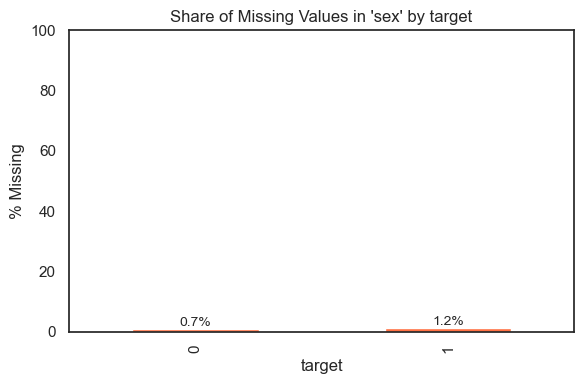

In [718]:
missing_values_report_plot(data, 'sex')

Only 3 missing values were found in the sex variable ($0.99\%$ of all rows). Analysis of the proportion of missing values by target variable classes shows that $0.7\%$ of cases with $target=0$ and $1.2\%$ of cases with $target=1$ contain missing values. However, the $\chi^2$ test results ($p$-value $= 1.00000$) indicate no statistically significant relationship between the missingness fact and the target variable, which suggests a MCAR (Missing Completely At Random) nature of the missing values. Consequently, such missing values do not cause systematic data distortion and can be safely handled by standard methods—deletion or imputation.Nevertheless, the sex variable, in general, demonstrates a significant prognostic relationship with $target$. Despite the lack of association between the missing values themselves and the target variable, the substantive meaning of this variable is important for the model, and its distribution is unstable. Therefore, even single missing values require careful handling. Conscious imputation methods (e.g., KNN or model-based imputation) are preferred over mechanical filling or ignoring.

##### Distribution

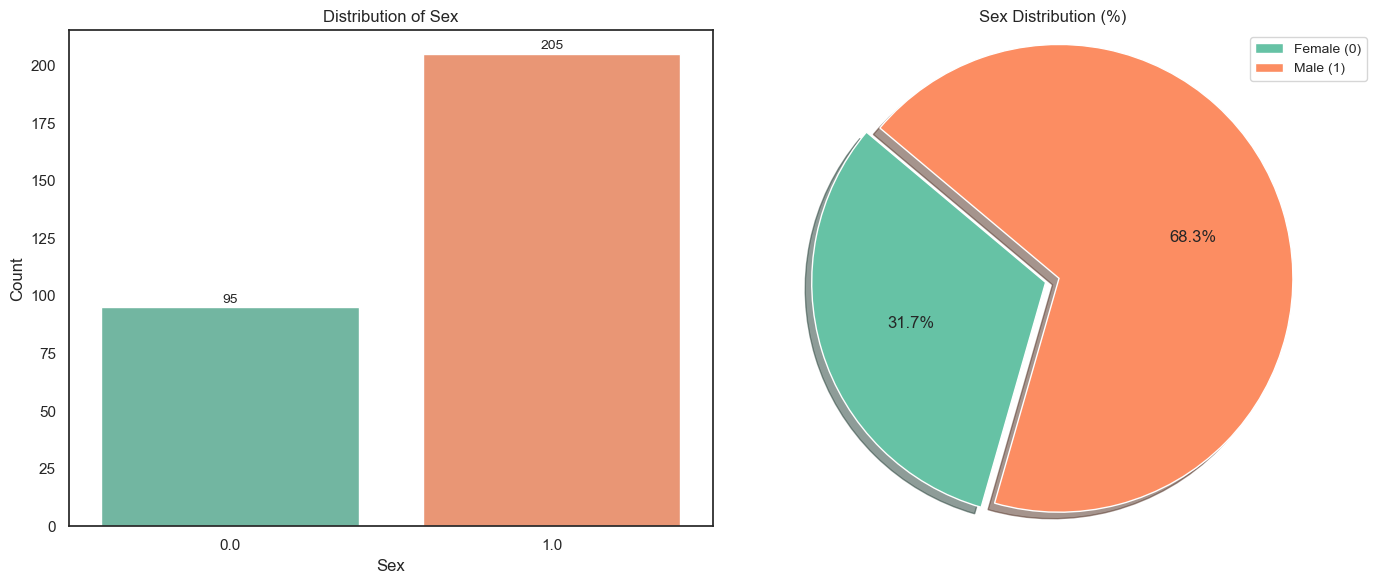

In [719]:
plot_target_distribution(data, 'sex', legend_labels=legend_dict['sex'])

The graphs display the distribution of the sex variable in the sample. Among all observations, 31.7% are women (value 0), and 68.3% are men (value 1), which indicates a pronounced gender imbalance. The bar chart shows the absolute counts: 95 women and 205 men.

##### Target Rate by Sex

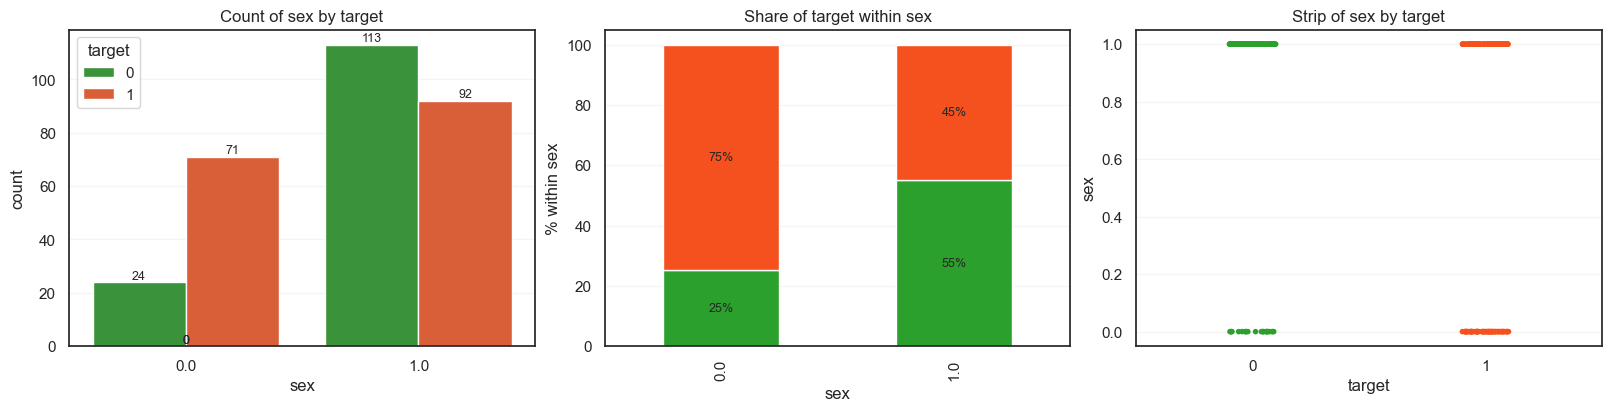

In [720]:
analyze_feature_vs_target(data, 'sex')

The graphs show the relationship between gender (sex) and the presence of the disease (target).  The first graph shows that among men, most observations have $target=0$ (healthy), although the total number of sick men is also substantial. Among women, the overwhelming majority are $target=1$ (75%), which is highlighted in the second graph: women constitute the group with a high proportion of affected individuals. Among men, the proportion of sick individuals is lower—45%, and healthy individuals—55%. Collectively, these graphs indicate that the sex variable has a statistically significant relationship with the disease and should be considered when building the prognostic model.

##### Sex-Stratified Feature Analysis vs Target

In [721]:
df_male = data[data['sex'] == 1]
df_female = data[data['sex'] == 0]

In [722]:
df_male['target'].unique(), df_male['target'].dtype

(array([1, 0]), dtype('int64'))

In [723]:
continuous_for_sex = continuous_cols.remove('age')


One-way ANOVA for 'trestbps' by sex:
Female F = 18.143, p = 0.0000
Male F = 1.082, p = 0.2996


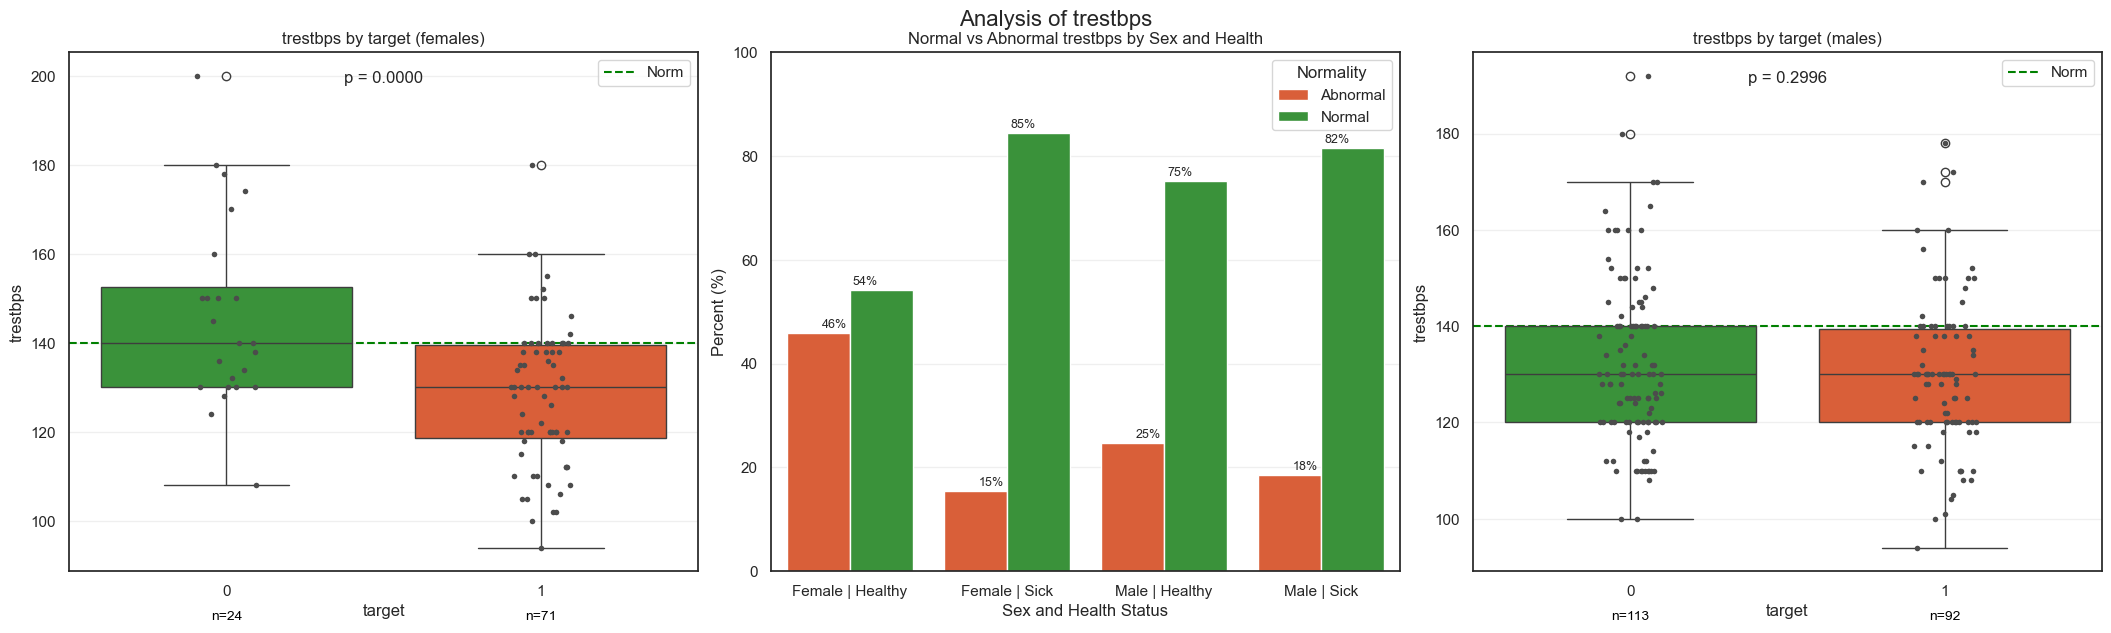


One-way ANOVA for 'chol' by sex:
Female F = 1.326, p = 0.2525
Male F = 6.229, p = 0.0134


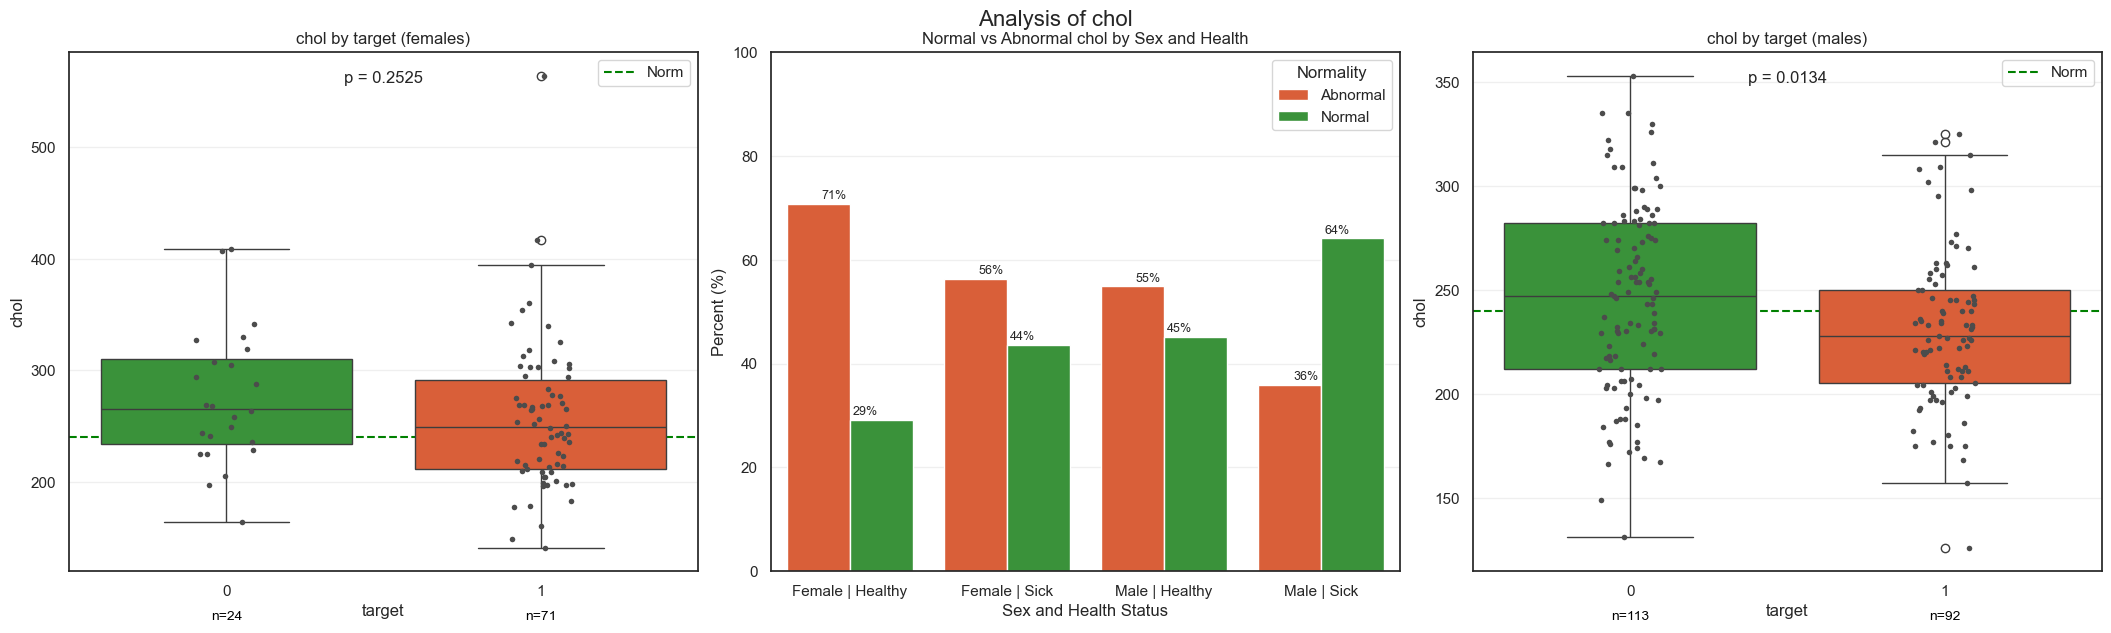


One-way ANOVA for 'thalach' by sex:
Female F = 5.069, p = 0.0269
Male F = 67.109, p = 0.0000


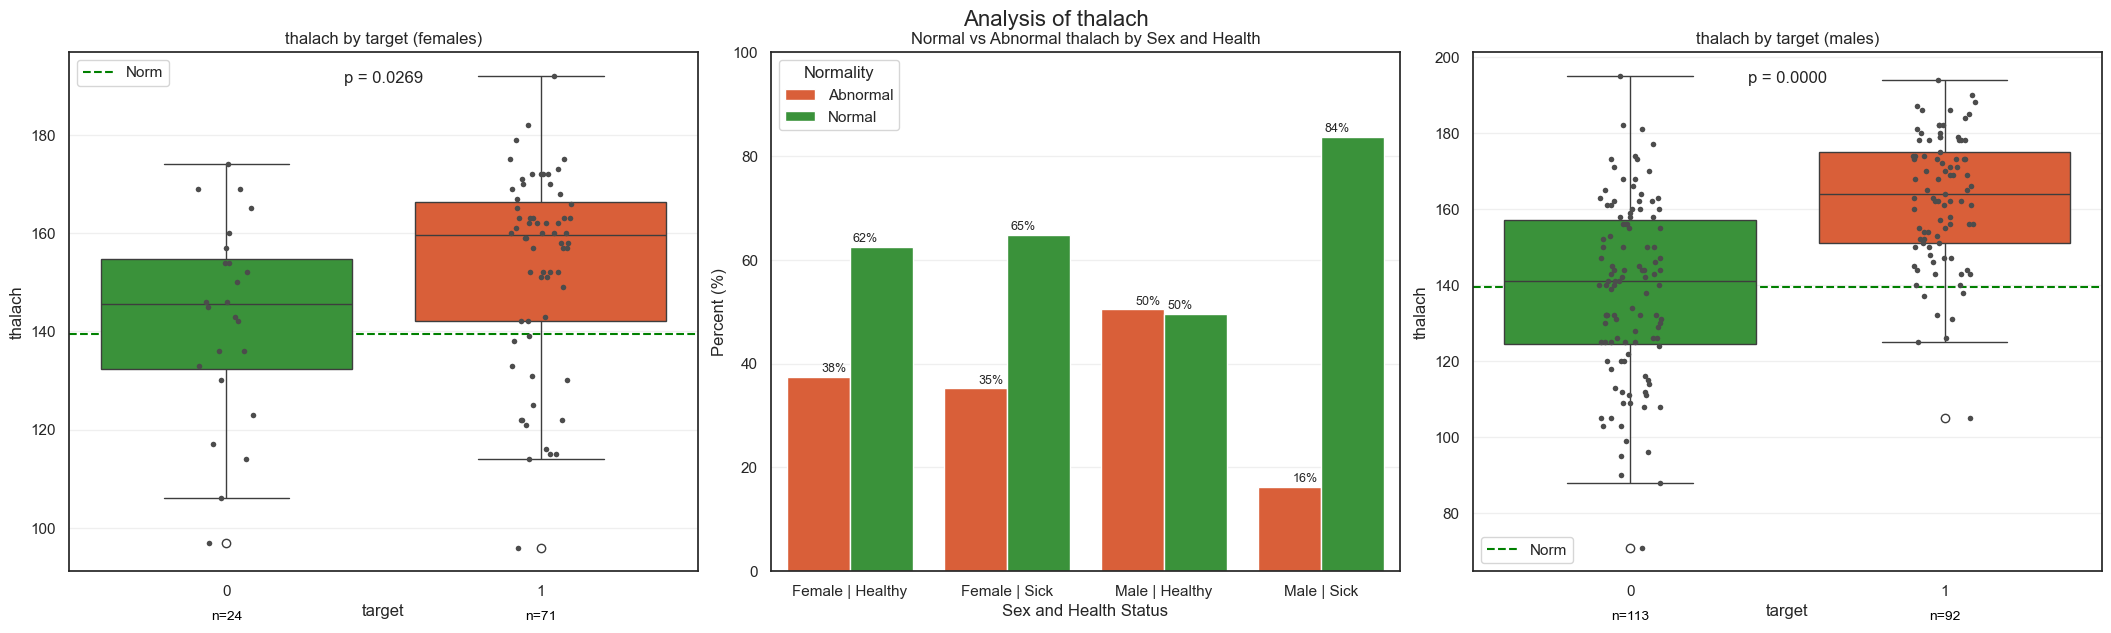


One-way ANOVA for 'oldpeak' by sex:
Female F = 29.280, p = 0.0000
Male F = 36.997, p = 0.0000


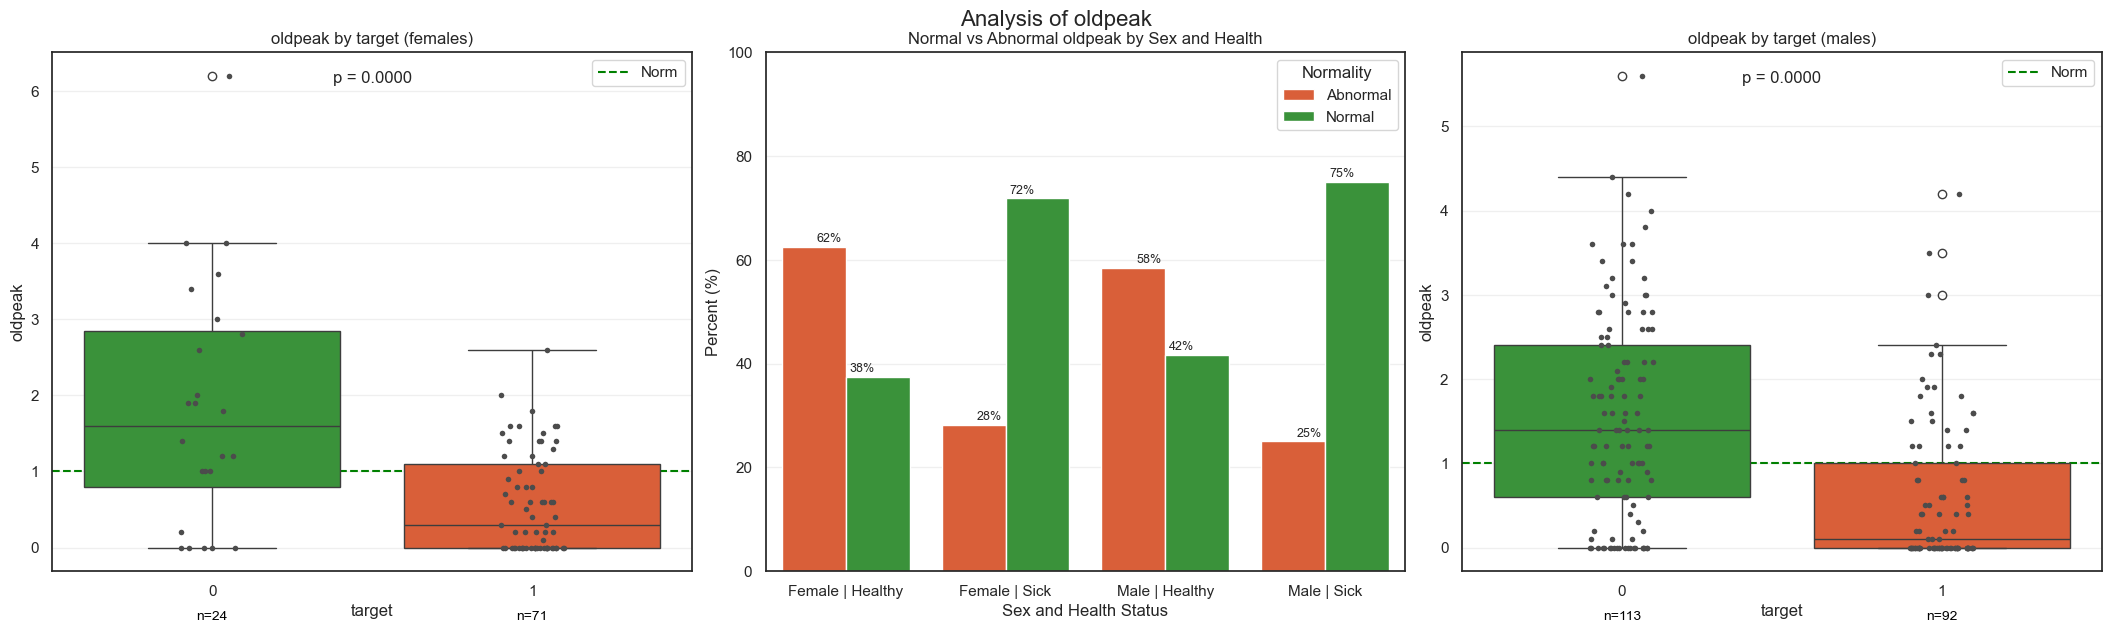

In [724]:
for val in continuous_cols:
    plot_continuous_vs_target_by_sex(data, val)

Analysis of Continuous Risk Factors by Gender

trestbps - Resting Blood Pressure

A statistically significant difference in blood pressure was found in women between sick and healthy individuals ($F = 18.14$, $p < 0.0001$), while no such difference exists in men ($p = 0.30$). However, the results contradict medical expectations: the median blood pressure in healthy women is higher than in sick women. Possible reasons include:
* The use of hypotensive drugs in sick patients.
* The small sample size of healthy women ($n=24$), making it sensitive to outliers.
* Differences in age between the groups.
* 
chol - Serum Cholesterol Level

A statistically significant difference in cholesterol levels was observed in men between healthy and sick individuals ($F = 6.229$, $p = 0.0134$): the median cholesterol level is lower in sick men than in healthy men, which may reflect the possible influence of treatment or lifestyle changes after diagnosis. Conversely, the difference in women is not statistically significant ($F = 1.326$, $p = 0.2525$), although visually the median is higher in healthy women than in sick women. This is atypical and may be explained by the small sample size ($n = 24$ healthy women), which is sensitive to outliers, or by hidden variables (e.g., age, therapy).

thalach - Maximum Heart Rate Achieved

The analysis showed that the maximum heart rate (thalach) is highly effective in distinguishing between sick and healthy individuals, especially among men. In men, sick individuals more often have high thalach than healthy individuals (84% vs. 50%), and this difference is very significant. In women, this association exists but is weaker (65% vs. 62%). While it seems strange that sick patients have a higher heart rate, this could be due to stress during the test, the early stage of the disease, or the absence of pulse-lowering medications. Overall, thalach is a useful indicator for men, but it must be assessed considering gender, disease stage, and treatment. For women, it is better to look at other features as well.

oldpeak - ST Depression Induced by Exercise Relative to Rest

Analysis of the oldpeak indicator (ST-segment depression after physical exertion) revealed a strong association with the presence of cardiovascular disease in both men and women. In men, the difference between healthy and sick individuals is statistically significant ($F = 36.997$, $p < 0.0001$): sick men have noticeably lower oldpeak values. In women, the difference is also significant ($F = 29.280$, $p < 0.0001$), but an unexpected result is observed—the mean oldpeak value in healthy women is higher than in sick women. This may be related to the small number of healthy women ($n=24$), making the data sensitive to outliers, as well as possible differences in age or medication use. This result may be due to sample peculiarities or possible errors. Overall, oldpeak is a valuable diagnostic feature in men, but its interpretation in women requires caution and consideration of additional factors.

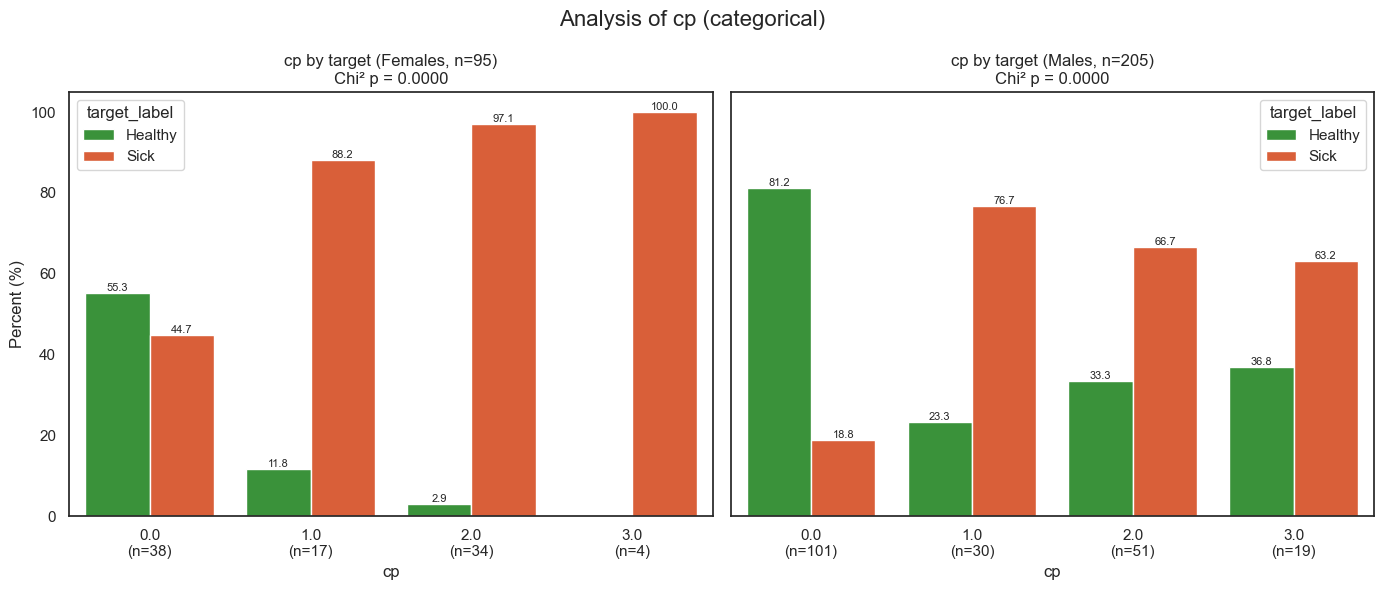

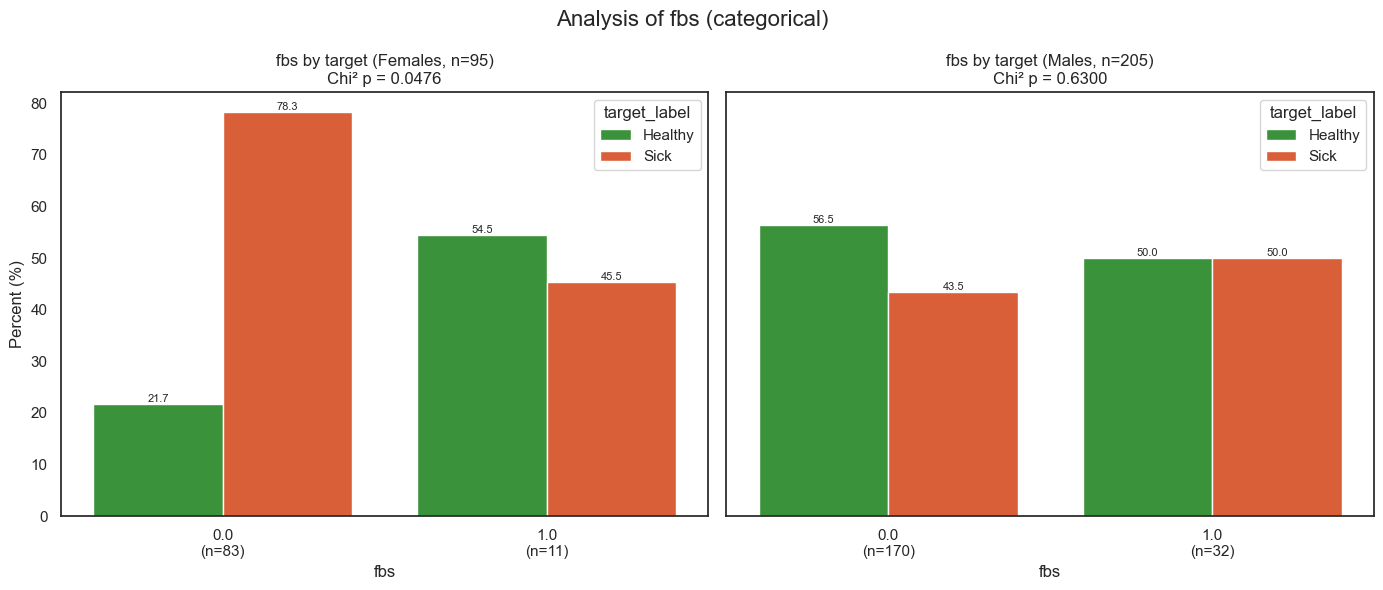

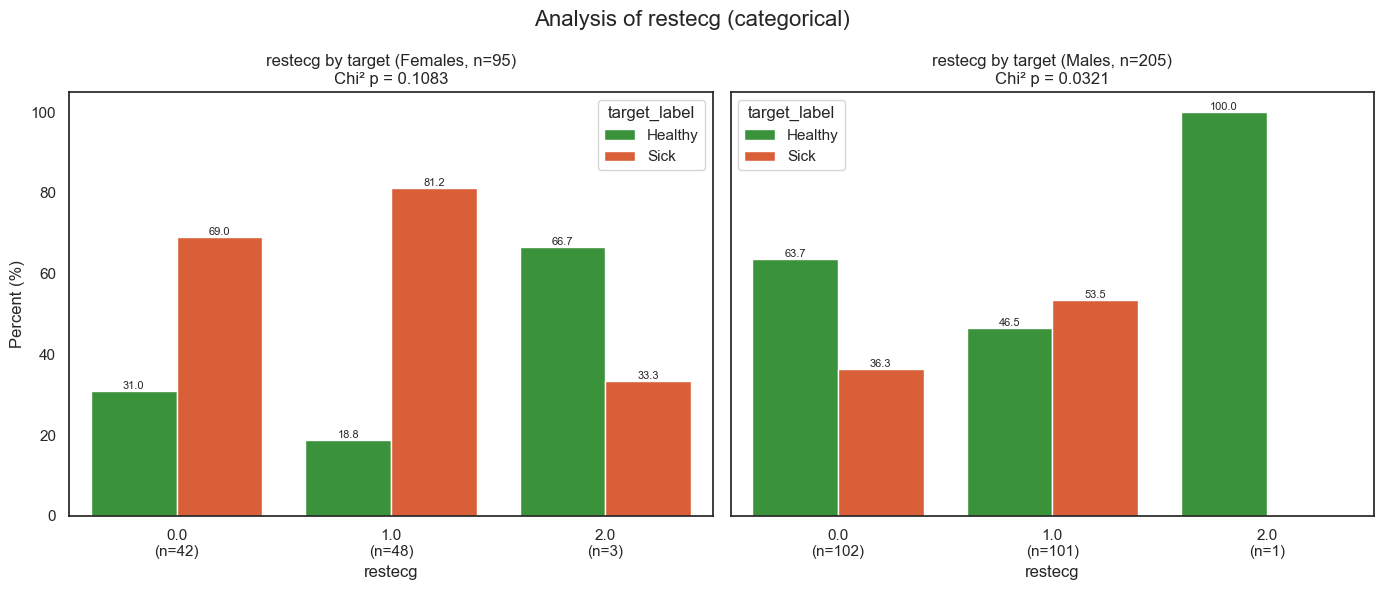

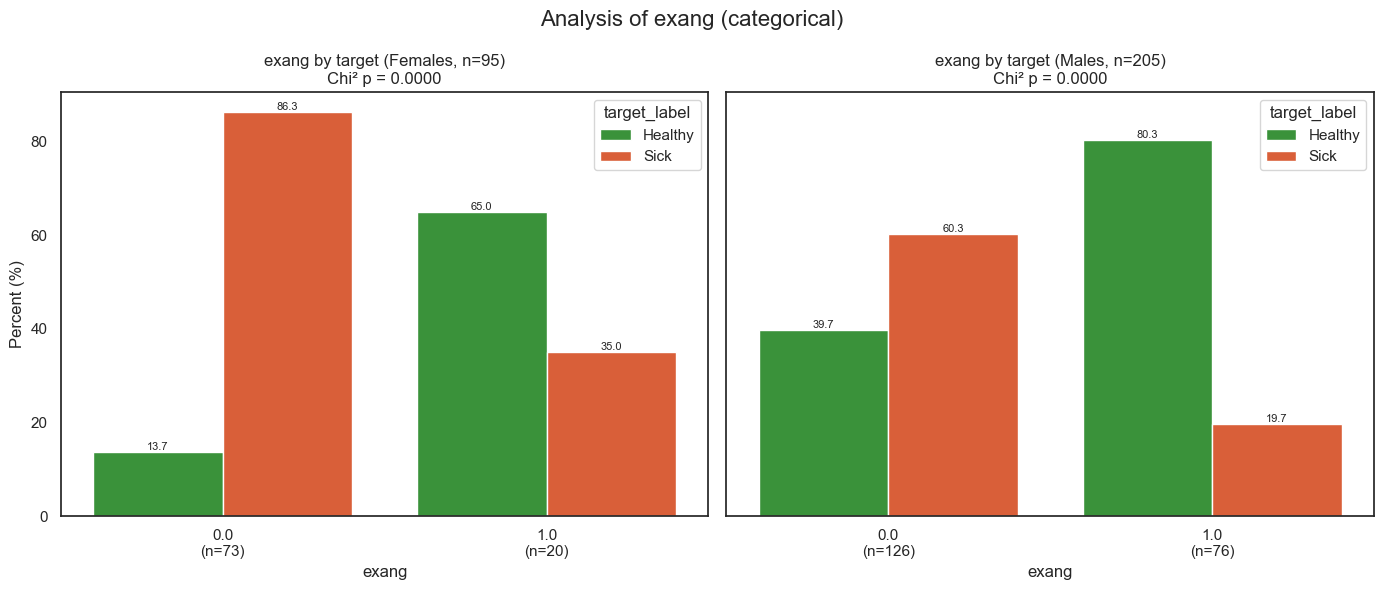

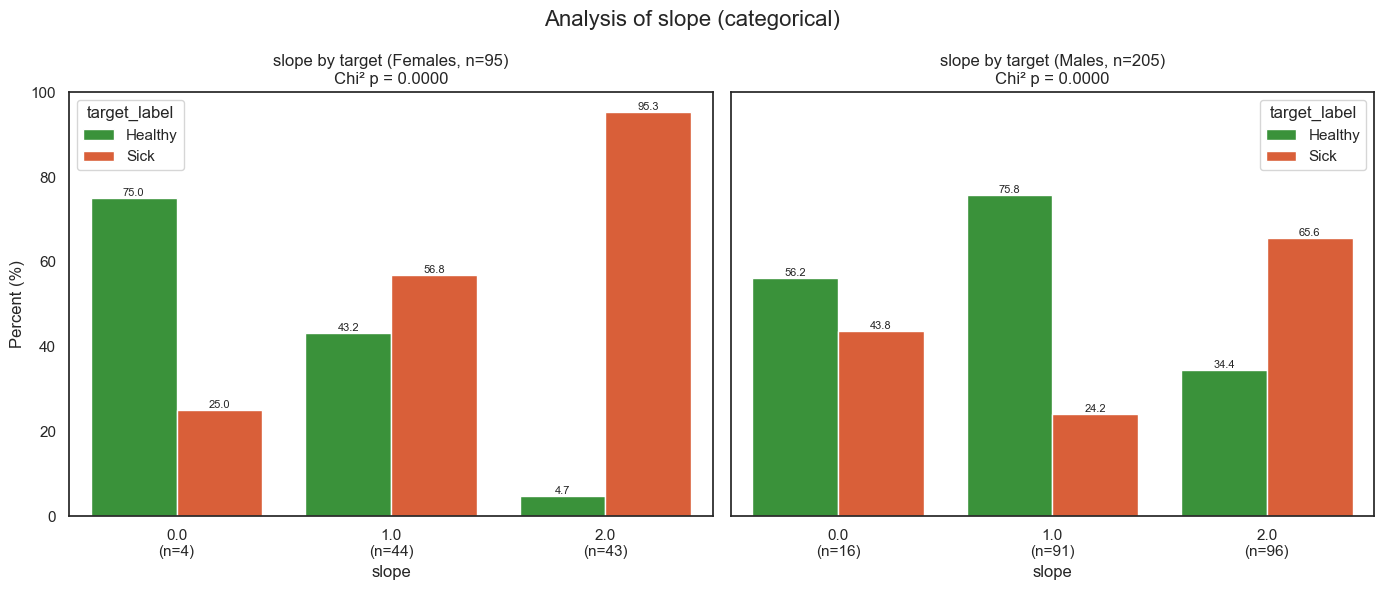

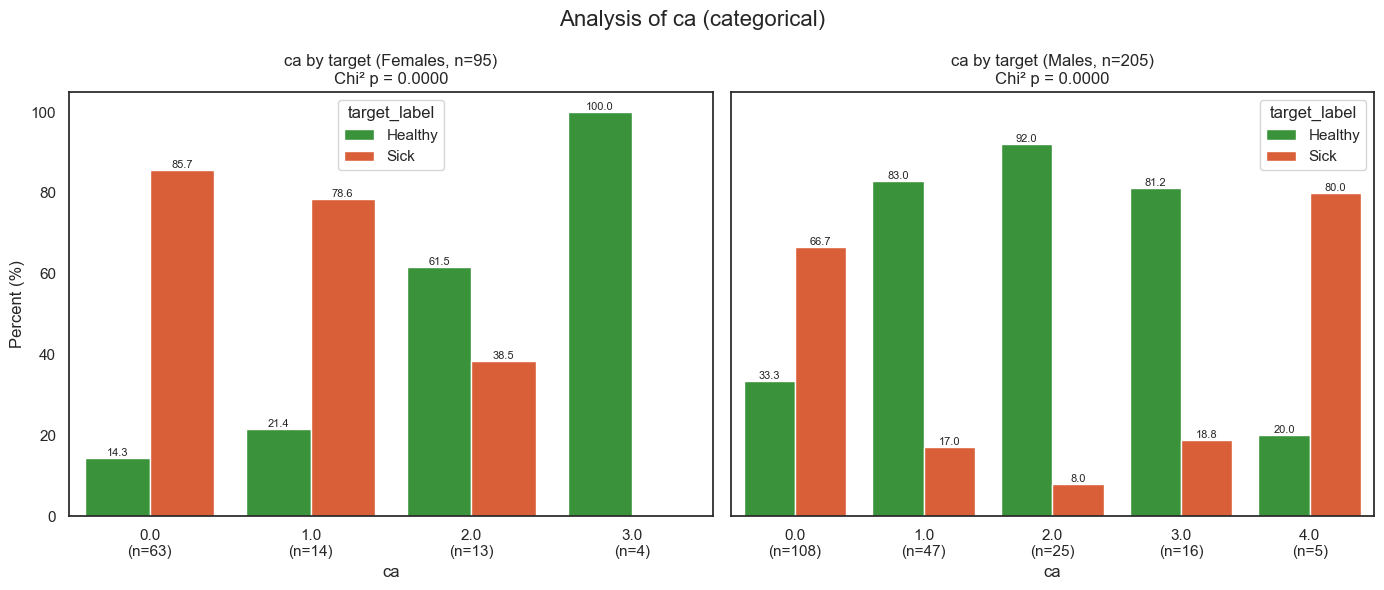

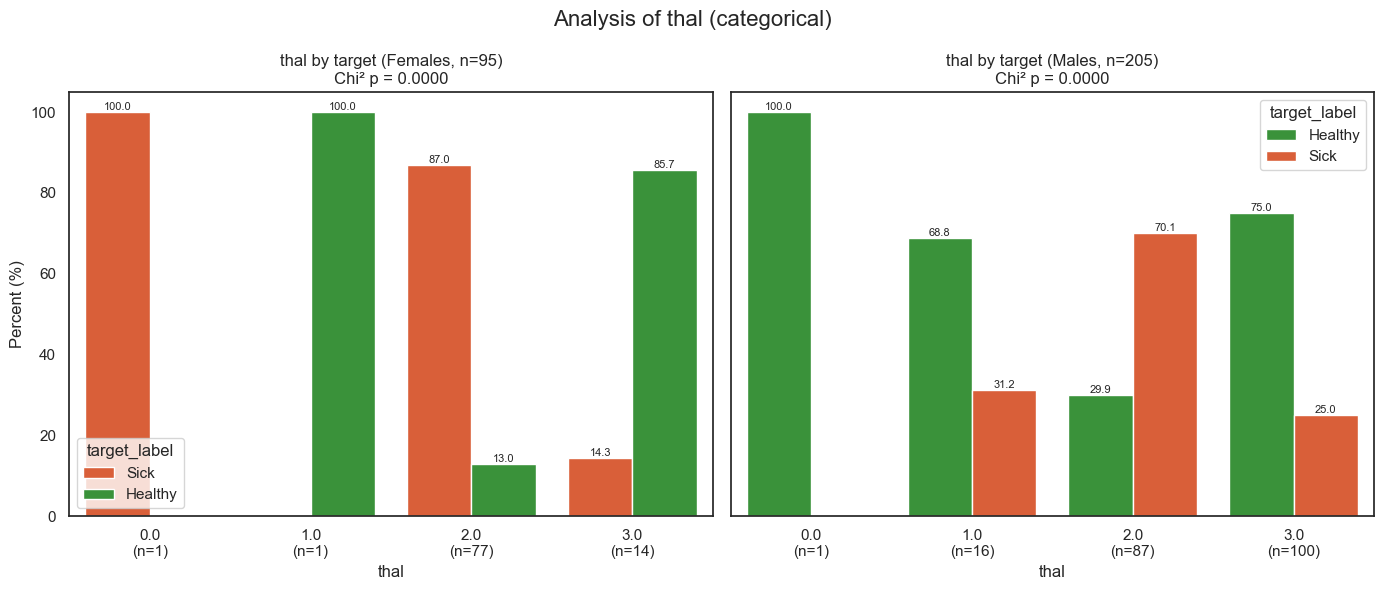

In [725]:
discrete_for_sex = [col for col in discrete_cols if col != 'sex']
for val in discrete_for_sex:
    plot_discrete_vs_target_by_sex(data, val)

Analysis of Categorical Risk Factors by Gender

cp - Chest Pain Type

Analysis of the cp variable shows that it is strongly associated with the presence of the disease in both men and women ($\chi^2$ $p$-value $< 0.0001$). In men, chest pain type 0 (least specific) is more characteristic of healthy individuals (81%), while other types (1, 2, 3) are more common in sick patients: for example, type 1 in 77%, type 2 in 67%, and type 3 in 63% of sick patients. In women, the picture is even more pronounced: types 1, 2, and 3 are almost entirely associated with the disease (88–100%), and among healthy women, almost all have chest pain type 0. Thus, the cp feature is a very strong indicator of the disease, especially in women, where its distribution almost completely separates the healthy from the sick.

fbs (fasting blood sugar) - Fasting Blood Glucose Level

Analysis of the fbs variable (fasting blood sugar $> 120$ mg/dL) showed a weak or absent association with the disease. In men, there are virtually no differences: both among healthy and sick individuals, 50% have high blood sugar ($fbs = 1$), and the $p$-value $= 0.63$ indicates no statistically significant difference. In women, the $p$-value is slightly lower ($p = 0.0476$), but the sample with $fbs = 1$ is very small (only 11 people), and even here the result is inconclusive. Overall, the fbs variable does not appear to be a reliable indicator of the disease in this dataset.

restecg - Resting Electrocardiographic Results

The restecg variable demonstrates different patterns in men and women. In women, the value $restecg = 1$ is most frequent, with $81.2\%$ of these being sick, which may suggest an association between this indicator and the disease. Also, at $restecg = 0$, the majority are sick (69%), while at $restecg = 2$, the proportion of sick individuals is lower ($33.3\%$), but this is based on only 3 observations. Despite the visually noticeable differences between the groups, statistical significance is absent ($\chi^2$ $p = 0.1083$), likely due to the small sample size in certain categories. In men, conversely, $restecg = 0$ predominantly features healthy individuals ($63.7\%$), $restecg = 1$ has an almost equal ratio, and $restecg = 2$ has only one case—a healthy individual. Here, the differences are statistically significant ($\chi^2$ $p = 0.0321$), but weak and unstable due to the extremely small number of observations in one category. Thus, restecg may have predictive value, especially for women, but requires cautious interpretation and possibly the consolidation of rare categories.

exang (exercise-induced angina) — Chest Pain upon Physical Exertion

The exang variable demonstrates a clear and statistically significant association with the presence of the disease in both women and men ($\chi^2$ $p = 0.0000$ for both groups). This effect is most pronounced in women: with $exang = 0$ (absence of exercise-induced angina), $86.3\%$ of people are sick, whereas with $exang = 1$ (presence of angina upon exertion), $65\%$ are healthy. A similar trend is observed in men: with $exang = 0$, $60.3\%$ are sick, and with $exang = 1$, $80.3\%$ are healthy. Thus, the presence of angina upon exertion (value 1) is more indicative of the absence of the disease, while its absence (value 0) is paradoxically more often observed in sick patients, especially women. This effect may be due to diagnostic peculiarities, age, or confounding factors, but regardless of the causes, the exang variable has high predictive significance and should be included in the model. The atypical distribution in women may be explained by: 1) Silent ischemia (especially with diabetes), 2) Taking antianginal drugs, 3) Errors in anamnesis collection.

slope (slope of the peak exercise ST segment) — Indicator assessed on ECG during or immediately after exercise.

The slope variable (shape of the ST segment curve on the ECG after exercise) shows a significant association with the disease in both genders ($\chi^2$ $p = 0.0000$). In women, the strongest association is observed at $slope = 2$, where almost all ($95.3\%$) are sick. Conversely, at $slope = 0$ and $slope = 1$, the proportion of healthy individuals is higher, especially at $slope = 0$, although there are only 4 cases there. In men, the situation is similar: at $slope = 1$, $75.8\%$ are healthy, and at $slope = 2$, $65.6\%$ are sick. Thus, $slope = 2$ can be considered a potential indicator of the disease, and $slope = 1$ as a sign of health, especially in men. The variable has good predictive power and clear biomedical meaning, but caution should be exercised due to the small number of observations in some categories, especially in women at $slope = 0$.

ca - Number of Major Vessels Colored by Fluoroscopy

The ca variable (number of colored vessels) shows a strong dependence on the presence of heart disease ($p < 0.001$) and behaves differently in men and women. In women, the values $ca = 0–1$ mostly correspond to the disease (85–78% sick), while $ca = 2–3$ are sharply dominated by healthy individuals. The value $ca = 4$ is absent in women, likely because it is extremely rare and did not fall into the limited sample ($n=95$). A biological reason is also possible: patients with severe vascular damage ($ca=4$) at age 50+ have an extremely high risk of complications and mortality, and often do not live to 60 or undergo surgical treatment (bypass, stenting), after which they may be excluded from the study sample. In men, the trend is similar: at $ca = 0$, the proportion of sick individuals is maximal (67%), then at $ca = 1–3$, healthy individuals prevail, but at $ca = 4$, the majority are sick again (80%), which may be due to both real risk and the small number of observations ($n=5$). Overall, ca is one of the strongest predictors, but requires careful handling: its influence depends on gender and is not linear.

thal - Thallium Stress Test Results — Instrumental Diagnosis of Coronary Artery Disease.

The thal variable clearly distinguishes between healthy and sick individuals ($p < 0.001$), especially in women. In women, almost all with $thal = 2$ are sick (87%), and those with $thal = 3$ are predominantly healthy (86%). In men, the same trend is observed but is less pronounced: at $thal = 2$, $70\%$ are sick, and at $thal = 3$, $75\%$ are healthy. The values $thal = 1$ and especially $thal = 0$ are extremely rare ($n = 1–2$), providing no statistically significant information. Moreover, $thal = 0$ is considered an anomalous code and is interpreted in some sources as a data entry error. Such values are recommended to be excluded from the analysis or replaced with NaN. Overall, thal is a strong predictor of the disease, especially in women, but requires cautious handling due to subgroup imbalance and the presence of potentially erroneous values.

A stratified analysis by gender was performed for all features, which revealed gender differences in the diagnostic significance of the variables. The most powerful predictors of the disease were found to be ca, cp, thal, slope, oldpeak, and thalach. Many features in women (especially cp, ca, thal) show a sharper separation between sick and healthy individuals.  Some variables, such as restecg, exang, and chol, demonstrate significant differences primarily in men, while fbs showed no diagnostic value in either group. Anomalous or rare values were encountered ($thal=0$, $ca=4$ in women), requiring data cleaning or aggregation. Overall, stratification by gender proved to be critically important: the same features can have high predictive power in one group and be uninformative in another.

#### The CP Variable

Interpretation of the cp variable (Chest Pain Type)

The cp variable is a categorical feature describing the nature of chest pain:
* 1 — Typical Angina Pressing, crushing pain, often occurring with exertion. Clearly linked to CAD. Especially dangerous in men over 40.
* 2 — Atypical Pain Pain in the neck, jaw, or arm area. Often found in women. Requires additional diagnosis if risk factors are present.
* 3 — Non-Anginal Pain Sharp, stabbing pain. Association with CAD is unlikely.
* 4 — Asymptomatic Absence of pain. Silent ischemia is possible, especially in diabetics or those with a history of CAD.

Clinical Observations :
* Values 3 (Non-Anginal) and 4 (Asymptomatic) are more common in healthy individuals.
* Values 1 (Typical Angina) and 2 (Atypical Pain) are more often observed in sick individuals.
* The disease in women may manifest without typical pain.

The nature of pain is a subjective feature and depends on:
* Individual perception.
* Cultural and linguistic differences.

cp requires critical evaluation. Its reliability increases when it coincides with other signs of CAD (e.g., ST depression, high thalach).

In [727]:
data['cp'].describe()

count    297.000000
mean       0.966330
std        1.035947
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: cp, dtype: float64

The cp variable takes values from 0 to 3 (shifted encoding).  The mean value is $0.96$, and the median is 1. The lowest values (0 and 1) are the most frequent, which suggests a predominance of typical and atypical angina. The distribution is asymmetric, skewed towards the more dangerous forms of pain.

##### Missing Values

===== Missing Values Analysis for: cp =====
Missing in cp: 6 (1.98%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0            100.0      0.0
1             96.4      3.6
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.06451

Missing values may be MCAR (no significant relation to target).


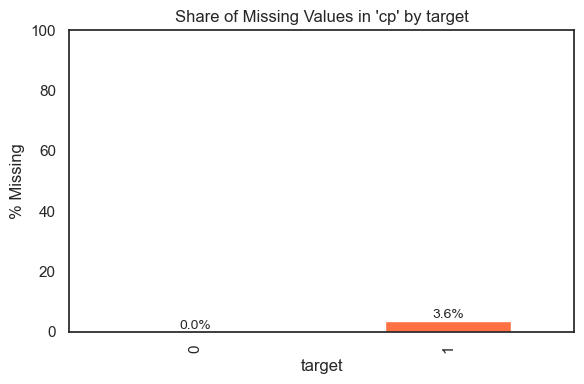

In [728]:
missing_values_report_plot(data, 'cp')

In the cp variable (chest pain type), 6 missing values were found. All of them belong to patients with a positive diagnosis. The frequency of missing values among the sick was $3.6\%$, while no missing values were observed among the healthy.Despite this concentration of missing values in one group, no statistically significant relationship was found between the presence of a missing value and the target variable ($\chi^2$  $p = 0.064$). This allows the missing values to be classified as MCAR (Missing Completely At Random), meaning they are not directly related to the presence of the disease.Nevertheless, the very fact that all missing values are observed only among the sick may indicate a potential systematic error in data entry or difficulties in symptom assessment in this group. Therefore, caution should be exercised during imputation: it is recommended to use methods that preserve the structure of the relationship with other variables.

##### Distribution

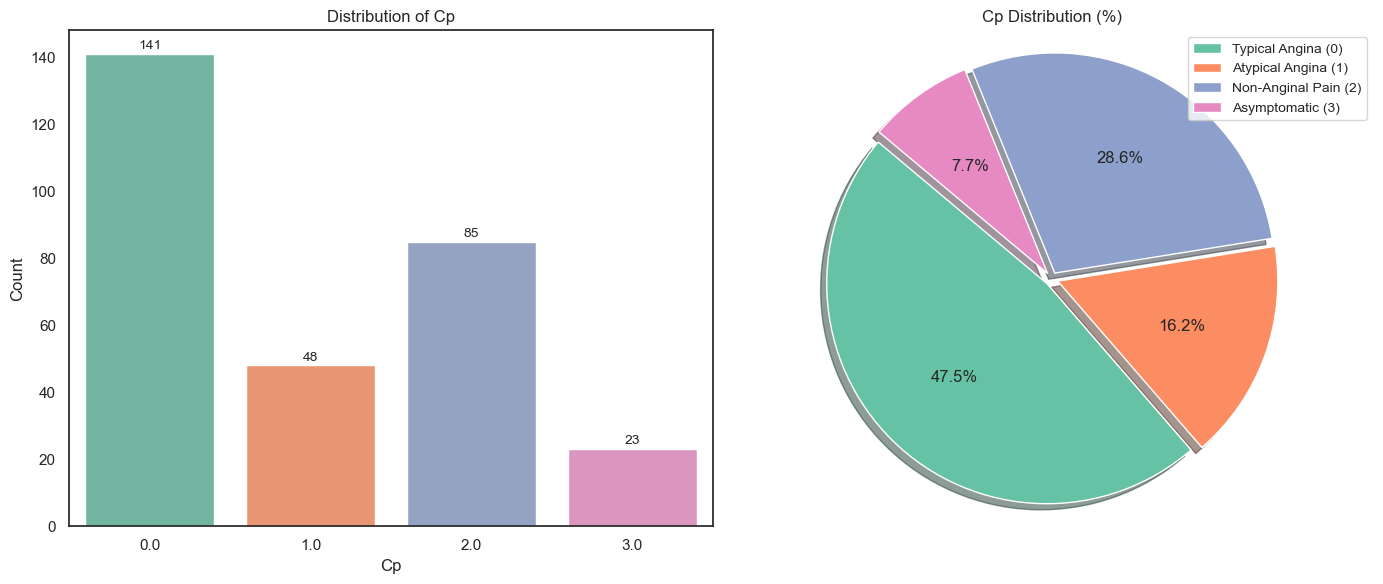

In [729]:
plot_target_distribution(data, 'cp', legend_labels = legend_dict['cp'])

In the cp variable (chest pain type), the largest number of observations belongs to typical angina ($46.5\%$), which indicates a high level of cardiac pathology among the patients.  Atypical angina is found in $28.1\%$, and although it is less characteristic, it may also indicate ischemic disease, especially in women. For $15.8\%$, the pain is non-anginal, but some of these individuals may still have CAD. The most concerning are the $7.6\%$ of asymptomatic cases: such patients may not feel pain but have silent ischemia, which is particularly dangerous in diabetics and the elderly.

##### Target Rate by CP

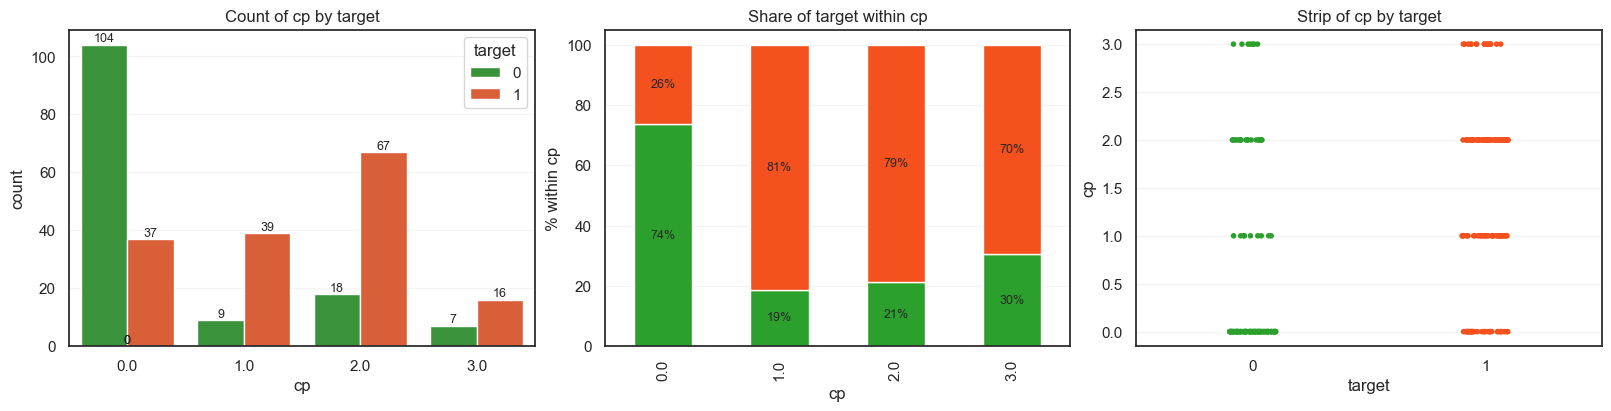

In [730]:
analyze_feature_vs_target(data, 'cp')

The graphs show that the relationship between chest pain type (cp) and the presence of heart disease (target) is very clearly pronounced. However, it is also important to consider the number of observations in each category:
* Typical Angina ($cp = 0$): 141 observations, of which 74% (104 people) are without the disease. This is the most represented class, and the high proportion of healthy individuals confirms that typical pain effectively leads to early diagnosis and reduces the risk of disease progression.
* Atypical Angina ($cp = 1$): 48 observations, of which 81% (39 people) are sick. Despite the smaller group size, the high proportion of sick individuals indicates the significance of such symptoms.
* Non-Anginal Pain ($cp = 2$): 85 observations, 79% of which (67 people) are sick. This is the second largest group, and the risk here is also high.
* Asymptomatic ($cp = 3$): only 23 observations, of which 70% (16 people) are sick. Despite the small sample, the result is alarming: the absence of pain does not mean the absence of disease.

Thus, the cp variable has high diagnostic significance. The less typical the pain, or if there is no pain at all, the higher the probability that the patient already has the disease. This emphasizes the importance of not ignoring even mild or non-standard symptoms in clinical practice, especially in vulnerable groups (e.g., the elderly or diabetics).

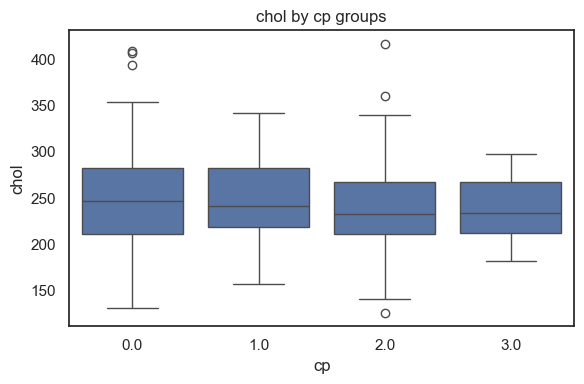

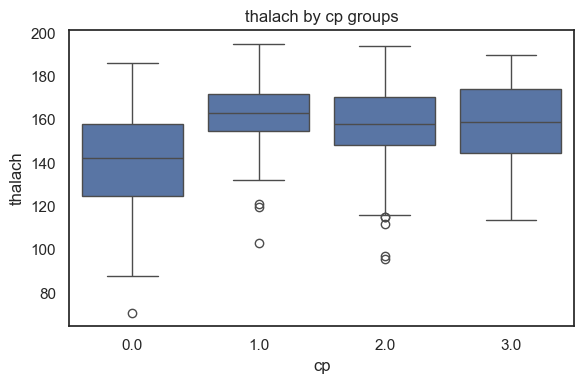

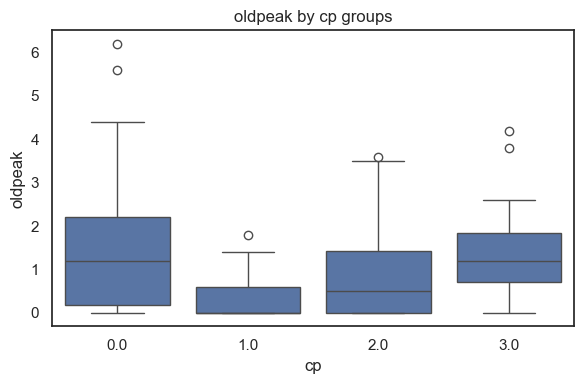

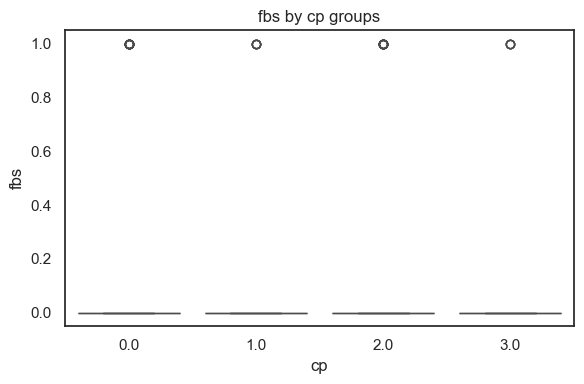

In [731]:
features = ['chol', 'thalach', 'oldpeak', 'fbs']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x='cp', y=feature)
    plt.title(f'{feature} by cp groups')
    plt.xlabel('cp')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

The graphs showing the dependence of features chol, thalach, and oldpeak on the cp variable (chest pain type) reveal the following patterns:
* Cholesterol Level (chol) The cholesterol level weakly differs between the cp groups. The distributions are similar, and the differences in medians are small, although the median is slightly higher in the $cp=1$ group (atypical angina). This may suggest that cholesterol is not strongly dependent on the type of pain.
* Maximum Heart Rate Achieved (thalach) Maximum heart rate (thalach) differs more clearly between the groups. Patients with $cp=0$ (typical angina) have a noticeably lower median thalach compared to other pain types. This may indicate a link between a reduced heart rate and typical angina.
* ST Segment Depression (oldpeak) ST segment depression (oldpeak) also differs between the groups. Patients with $cp=0$ (typical angina) have a higher oldpeak than the other groups, which may indicate more pronounced ischemic changes. In patients with $cp=1$ and $cp=2$, the median oldpeak is lower.

In summary, thalach and oldpeak demonstrate more pronounced differences across the cp groups, confirming a potential link between the type of pain and the physiological changes associated with cardiac activity.


#### The Trestbps Variable

trestbps (Resting Blood Pressure) is systolic blood pressure (SBP) measured at rest (mm Hg). It is one of the key indicators of cardiovascular health.
Norm and deviations:
* $< 90$ — hypotension (risk of weakness, shock)
* $90–119$ — optimal pressure
* $120–129$ — normal, but requires monitoring
* $130–139$ — elevated, possible predictor of hypertension
* $140–159$ — Grade 1 hypertension
* $\ge 160$ — Grade 2 hypertension, high risk of complications
* $180$ — crisis: risk of stroke, heart attack

In [733]:
data['trestbps'].describe()

count    299.000000
mean     131.505017
std       17.502516
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

The trestbps (resting systolic blood pressure) indicator has a median of 130 and a mean of 131.5, suggesting a nearly symmetric data distribution. Three quarters of the values are at $140$ mm Hg or below, meaning only $25\%$ of participants show signs of Grade 1 hypertension or higher. The minimum recorded value is $94$ mm Hg, and the maximum is $200$, indicating the presence of isolated cases of hypertensive crisis. Overall, the majority of observations fall within the normal and pre-hypertension range ($120–139$ mm Hg), and severe deviations are rare.

##### Missing Values

===== Missing Values Analysis for: trestbps =====
Missing in trestbps: 4 (1.32%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             99.3      0.7
1             98.2      1.8
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.74501

Missing values may be MCAR (no significant relation to target).


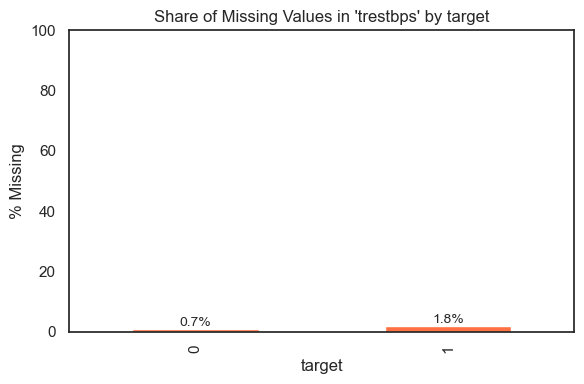

In [734]:
missing_values_report_plot(data, 'trestbps')

Missing values in the trestbps variable account for only $1.32\%$ of the total observations (4 out of 303 cases), which is an insignificant level. The distribution of missing values across the target variable classes is not uniform: $0.7\%$ among healthy individuals and $1.8\%$ among sick individuals. The $\chi^2$ test result ($p$-value $= 0.745$) did not reveal a statistically significant dependence between missing values and the target variable, allowing the missing values to be classified as MCAR (Missing Completely At Random)—the missing values can be considered random. This means we can safely use simple imputation methods (e.g., filling with the median) without the risk of bias.

##### Distribution and Outliers

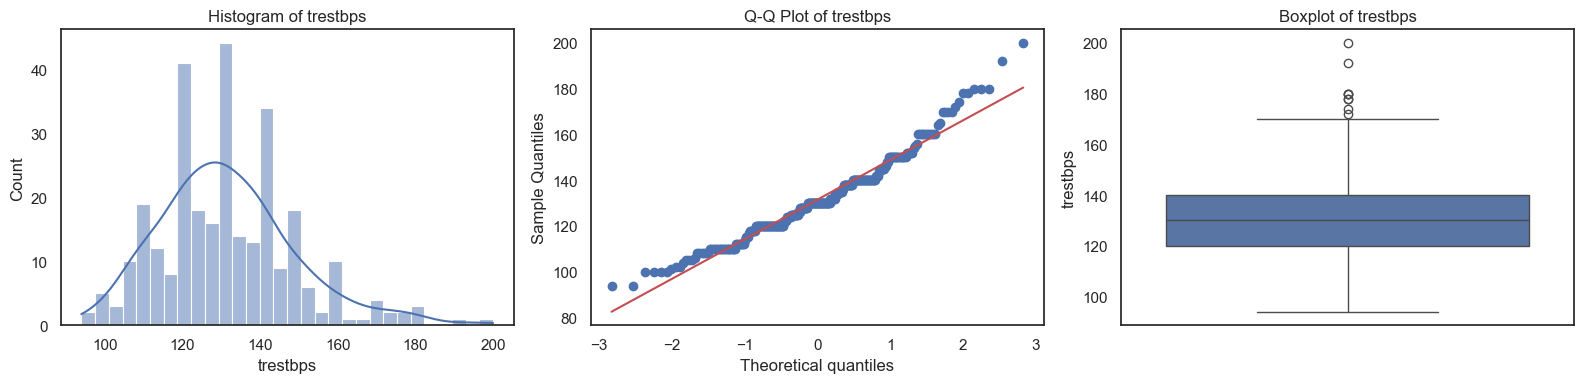

In [735]:
diagnostic_plots(data, 'trestbps')

The distribution of the variable is asymmetric, skewed towards the right tail—this is visible on the histogram and the Q-Q plot, where values above 160 deviate from the straight line. Outliers above $170–175$, reaching $200$ mm Hg, are clearly visible on the boxplot, which may indicate patients with hypertension. Most values are concentrated in the $120–140$ range, corresponding to normal or slightly elevated pressure. Values below 100 and above 180 are rare and could be either medical extremes or potential measurement errors.

In [736]:
data['trestbps'] = pd.to_numeric(data['trestbps'], errors='coerce')

##### Target Rate by Trestbps

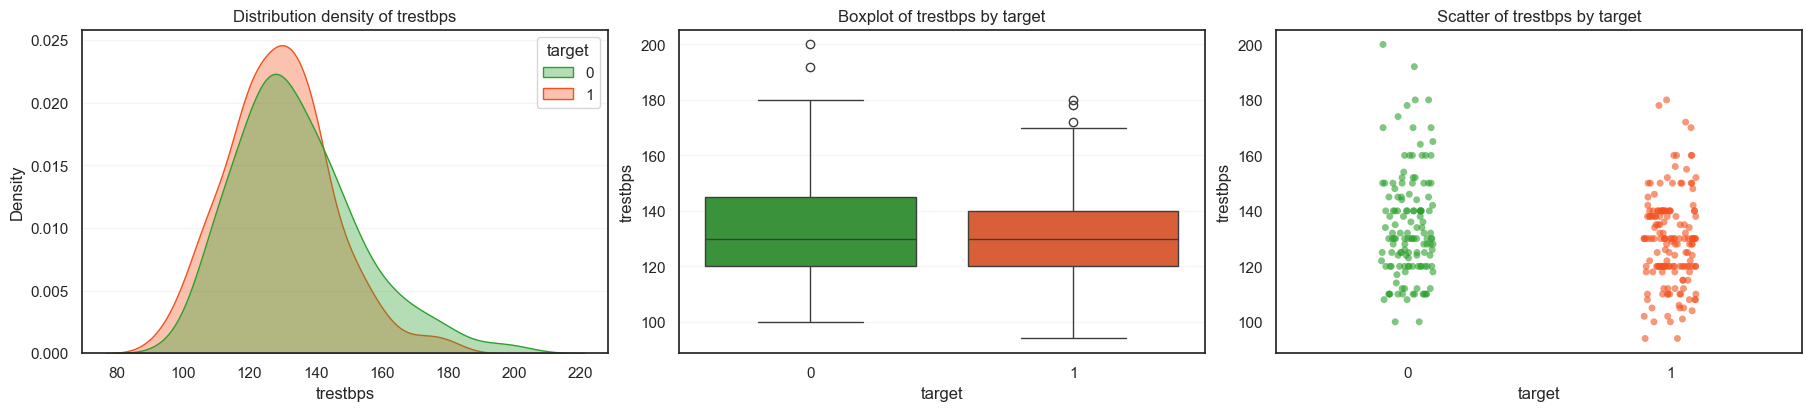

In [737]:
analyze_feature_vs_target(data, 'trestbps')

The trestbps variable (resting blood pressure) does not demonstrate a pronounced dependence on the target variable (presence of heart disease). The density plot shows that the curves for sick and healthy patients almost coincide, although the pressure is slightly higher in healthy individuals. The boxplot also shows that the median pressure in healthy individuals is slightly higher, and the dispersion of values is approximately the same, with a larger number of outliers in the healthy group. On the scatter plot, the points of the two groups overlap significantly, confirming the absence of a clear boundary between the classes. Thus, trestbps is not a strong discriminative factor in this sample and will likely not be useful alone in modeling, although its interactions with other features are possible.

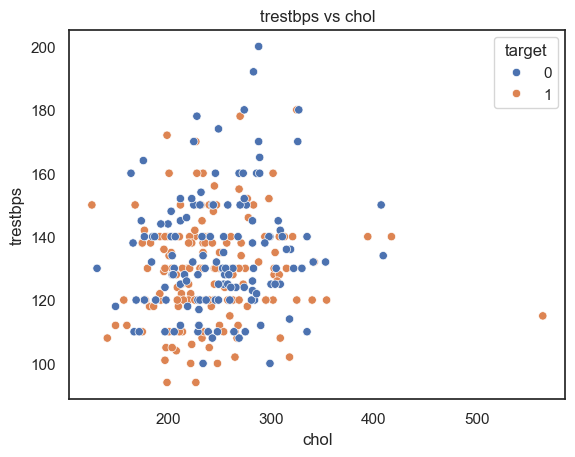

Корреляция trestbps и chol: 0.117


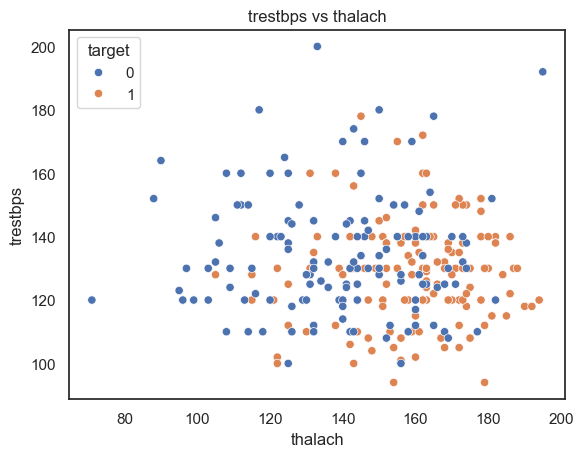

Корреляция trestbps и thalach: -0.047


In [738]:
for var in ['chol', 'thalach']:
    sns.scatterplot(data=data, x=data[var], y=data['trestbps'], hue='target')
    plt.title(f'trestbps vs {var}')
    plt.show()
    print(f'Корреляция trestbps и {var}: {data["trestbps"].corr(data[var]):.3f}')

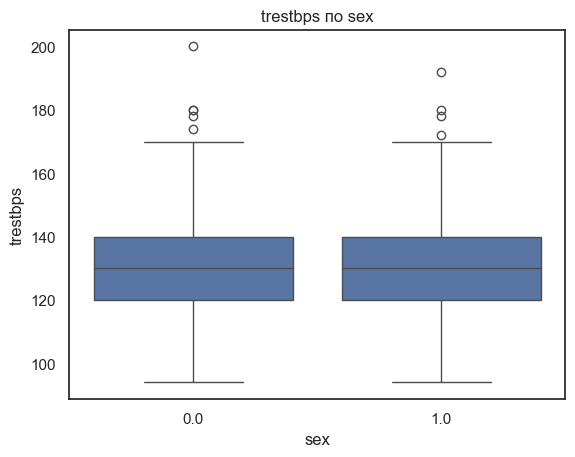

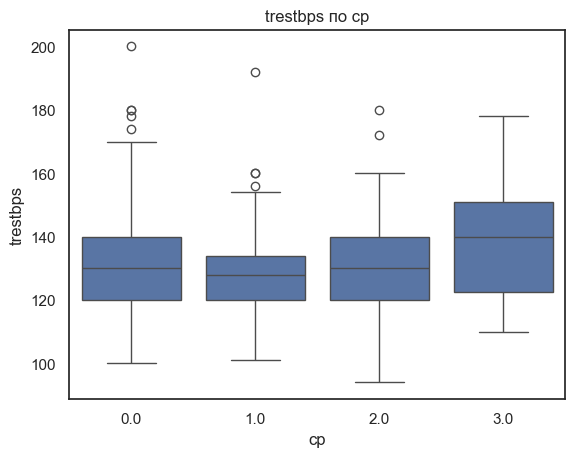

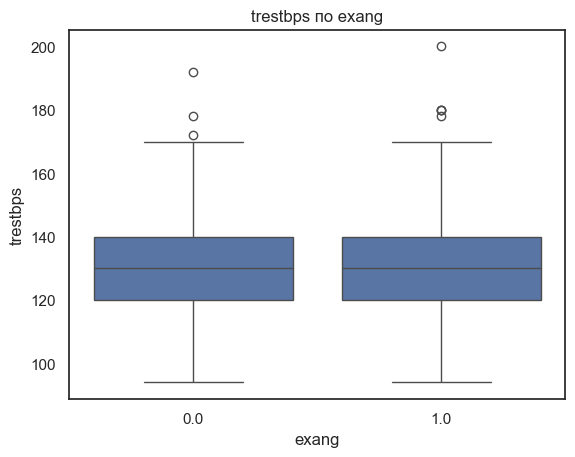

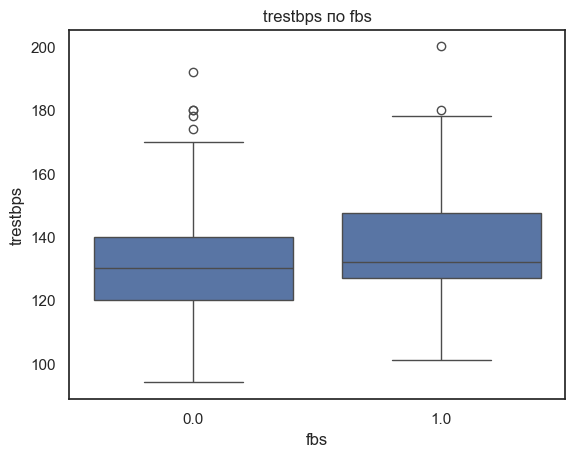

In [739]:
for var in ['sex', 'cp', 'exang', 'fbs']:
    sns.boxplot(x=data[var], y=data['trestbps'])
    plt.title(f'trestbps по {var}')
    plt.show()

Analysis of trestbps with numerical features (chol, thalach) did not provide new information. Visually, no pronounced dependence was observed on the scatterplot either.However, the boxplot across categorical variables (sex, cp, exang, fbs) revealed some differences in trestbps distributions.  Changes are particularly noticeable for different chest pain types (cp) and sugar levels (fbs): individuals with high blood sugar ($fbs = 1$) have a higher average pressure. These features may interact with trestbps and could be useful when building the model.

In [740]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

#### The Chol Variable

chol — total cholesterol concentration in the blood.

Cholesterol is a vital lipid involved in building cell membranes and synthesizing hormones, but its excess (especially LDL) leads to atherosclerosis and CAD. Norms: total cholesterol $< 200$ mg/dL, LDL-C $< 100$ mg/dL, HDL-C $> 40/50$ mg/dL (M/F). Key causes of elevation are genetics, poor diet, and hypothyroidism. Statins (reducing LDL-C by $30–50\%$) and a diet restricting saturated fats are used to reduce CAD risk. Diagnosis requires a lipid panel (LDL-C/HDL-C), as total cholesterol is less informative. In $15\%$ of CAD patients, cholesterol is normal, underscoring the role of other factors.

Cholesterol (especially LDL-C — "bad") accumulates in artery walls, forming atherosclerotic plaques. This leads to narrowing of the vessels (cardiac ischemia, angina) or rupture followed by thrombosis, causing a heart attack or stroke. Raising LDL-C by every $40$ mg/dL increases the risk of CAD by $20–25\%$. The risk is particularly high in diabetics (even with LDL-C $100–130$ mg/dL) and smokers (the CAD risk increases $4–6$ times when combined with high LDL-C). The optimal LDL-C level is $< 100$ mg/dL, and for CAD patients, it is $< 55$ mg/dL. Statins reduce risk by $30\%$ by lowering LDL-C levels.

Total Cholesterol (chol), mg/dL (milligram per deciliter)
* $< 200$ — optimal level, low risk of atherosclerosis
* $200–239$ — borderline high, requires LDL-C control and diet
* $\ge 240$ — high, indication for drug therapy
* $> 300$ — critically high, risk of pancreatitis and xanthomatosis.

Special Cases:
* $< 120$ — possible hypocholesterolemia (risk of bleeding, depression)
* $> 500$ — suspicion of familial hypercholesterolemia (requires urgent treatment).

Clinical Context:
* A level $> 240$ mg/dL increases the risk of myocardial infarction by $2–3$ times
* In some CAD patients, cholesterol may be normal (e.g., due to statin use or an inflammatory mechanism)
* For people over 70, a level up to $260$ mg/dL is acceptable if other risk factors are absent
* In premenopausal women, cholesterol is typically $10–20$ mg/dL higher than in men (estrogens have a protective effect)

In [741]:
data['chol'].describe()

count    297.000000
mean     246.084175
std       52.016723
min      126.000000
25%      211.000000
50%      240.000000
75%      274.000000
max      564.000000
Name: chol, dtype: float64

Cholesterol (chol) in the sample ranges from 126 to 564, with a median of 240.  The distribution is moderately right-skewed ($\max = 564$, $75\% = 274$), and outliers are possible. The mean (246) is close to the median—there are few data points with extremely high cholesterol levels, but they are present.

##### Missing Values

===== Missing Values Analysis for: chol =====
Missing in chol: 6 (1.98%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             98.6      1.4
1             97.6      2.4
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.84723

Missing values may be MCAR (no significant relation to target).


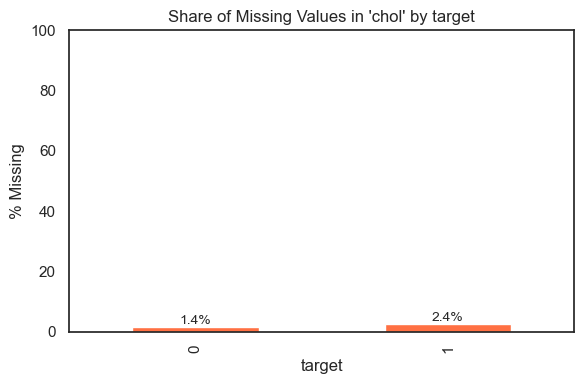

In [742]:
missing_values_report_plot(data, 'chol')

In the chol feature (total cholesterol level), 6 missing values were found, which constitutes $1.98\%$ of all observations. Analysis of the distribution of missing values across the target variable showed that in the group without disease ($target = 0$), the proportion of missing values is $1.4\%$, and in the group with disease ($target = 1$), it is $2.4\%$. Statistical testing of the relationship between missing values and the presence of disease using the Chi-squared test yielded a $p$-value $= 0.847$, which is significantly higher than the threshold of $0.05$. This indicates the absence of a significant dependence between the missingness of the chol feature and the target variable. Consequently, the missing values can be considered random (MCAR — Missing Completely At Random) , and they can be safely imputed using standard methods (e.g., median, mean, or iterative imputation).

##### Distribution and Outliers

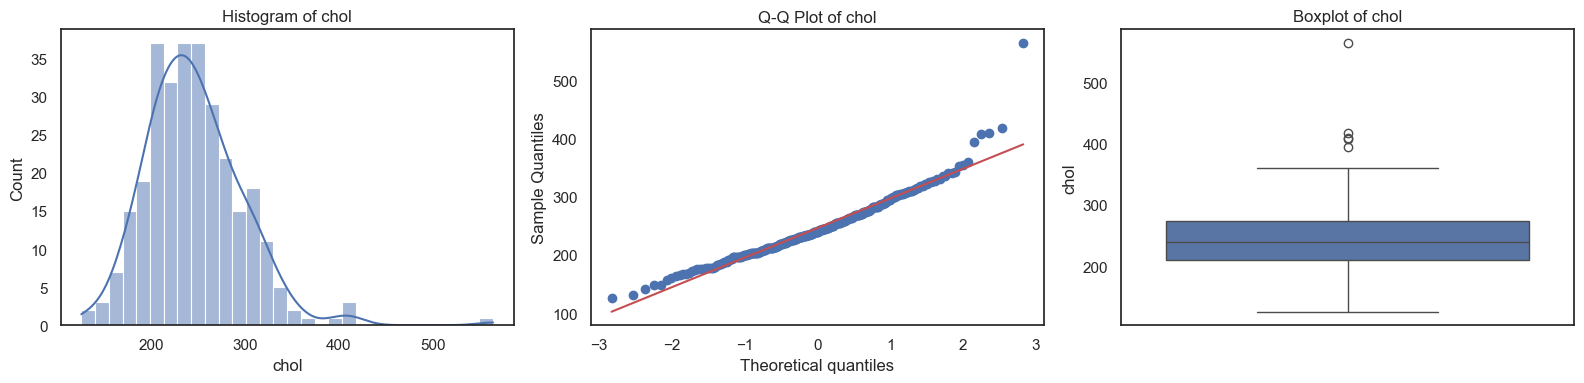

In [743]:
diagnostic_plots(data, 'chol')

The chol feature (total cholesterol) demonstrates a distribution close to normal, but with a slight right skew and the presence of moderate and extreme outliers.  The histogram shows that most values are concentrated in the range from $\sim 180$ to $300$ mg/dL, but the right "tail" extends higher, including isolated cases $> 400$ and even $> 500$ mg/dL. The Q–Q plot confirms deviations in the right tail, which is specifically related to the outliers. The boxplot also shows several abnormally high values.  Otherwise, the behavior of the feature is quite close to normal, and with appropriate outlier handling, it can be used in models sensitive to distribution. For imputing missing values, it is desirable to use methods robust to outliers—for example, the median or iterative regression.

##### Target Rate by Chol

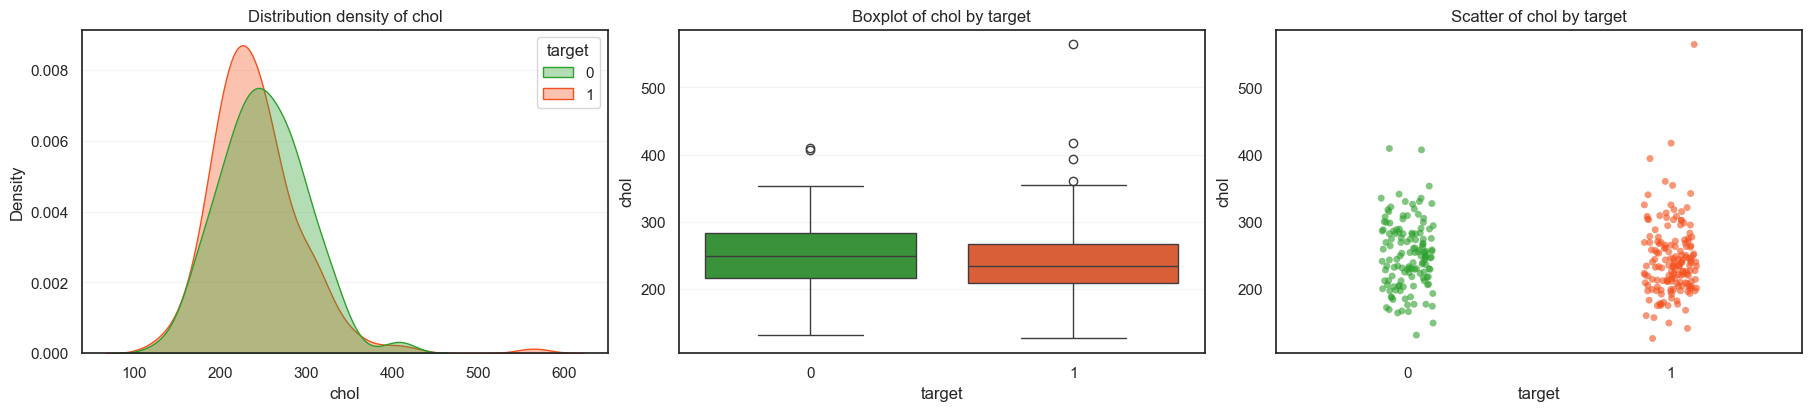

In [744]:
analyze_feature_vs_target(data, 'chol')

The graphs show that the cholesterol (chol) distributions for the groups with and without the disease ($target = 1$ and $0$) overlap almost completely, although some differences are observed.  In sick individuals ($target = 1$), the distribution is more right-skewed and includes isolated extreme values (up to $560+$), which is clearly visible on the boxplot and scatterplot.   Outliers are also present in healthy individuals ($target = 0$), but they are less pronounced. Overall, the cholesterol level does not show sharp differences between the groups, and the density plots indicate that the peaks of both curves fall approximately in the same region ($\sim 240$ mg/dL). This suggests the weak discriminatory power of the chol feature regarding the presence of the disease, at least without considering outliers or other factors.

Further analysis will include checking the relationship between cholesterol level and other important variables—primarily the presence of diabetes (fbs), as it is known that even moderately elevated LDL levels in diabetics significantly increase the risk of CAD. We will also consider the combined effect of several features (e.g., exang, fbs, trestbps, thalach) and perform statistical tests (ANOVA, $\chi^2$) to determine the significance of differences between the groups.

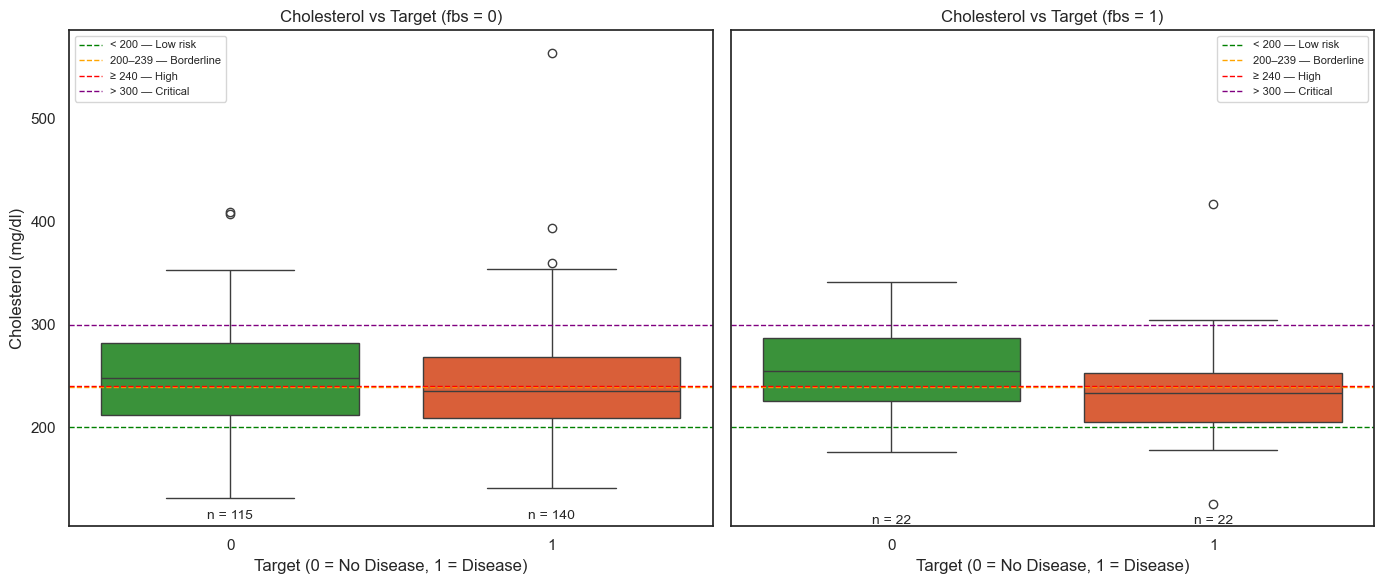

In [745]:
plot_cholesterol_boxplots(data, 'fbs')

Comparison of cholesterol (chol) levels in sick and healthy patients did not reveal a pronounced dependence, either among diabetics ($fbs = 1$) or non-diabetics ($fbs = 0$).

The distributions across the groups on the boxplot overlap almost completely, and the differences between them are minimal.

Moreover, the cholesterol level is even lower in sick individuals, which is likely due to already prescribed treatment or adherence to a diet. This is particularly characteristic of patients with cardiovascular diseases or diabetes, who are often recommended measures to lower their lipid profile.

Thus, despite numerous clinical studies (e.g., Framingham Heart Study, ESC/EAS Guidelines) confirming the link between elevated cholesterol levels and CAD risk, the chol variable is not a reliable predictor of the disease in our sample. The influence may be masked by clinical measures already taken following diagnosis.

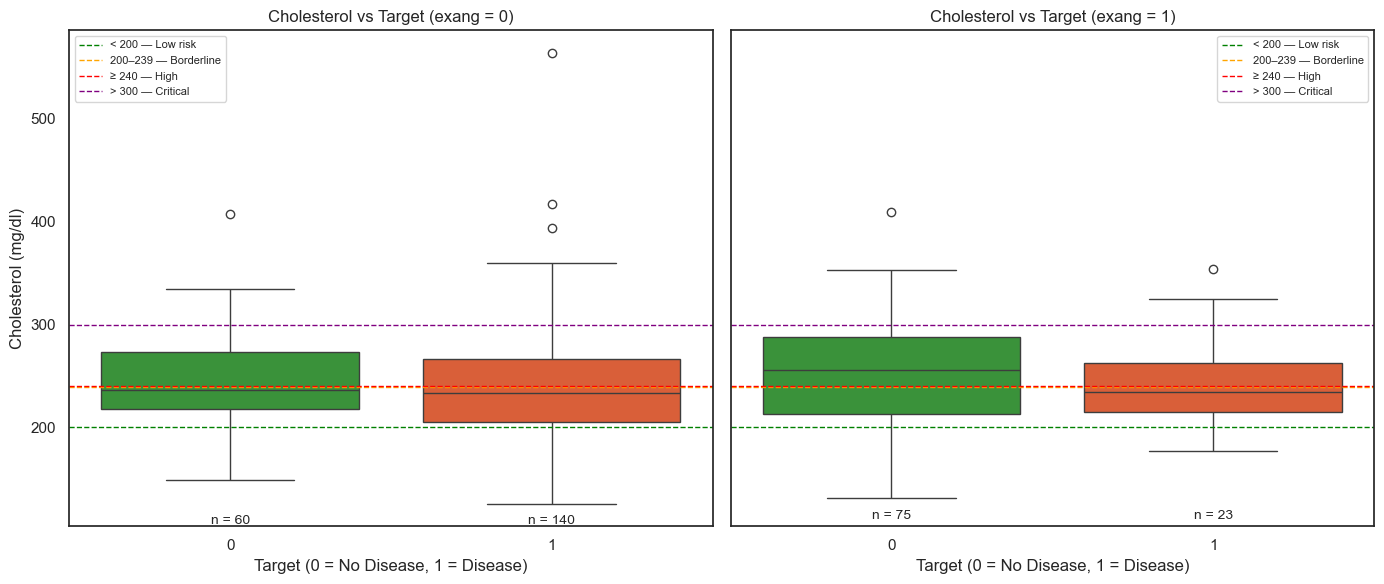

In [746]:
plot_cholesterol_boxplots(data, 'exang')

Comparison of cholesterol (chol) levels in sick and healthy patients, separated by the exang feature (presence of exercise-induced angina), did not reveal significant differences between the groups.  Both in the absence of angina ($exang = 0$) and its presence ($exang = 1$), the median cholesterol values are almost identical in the groups with and without the disease. The distributions practically overlap completely, and the values mainly fall into the borderline ($200–239$ mg/dL) and high risk ($\ge 240$ mg/dL) zones.

Interestingly, in patients with angina ($exang = 1$), the cholesterol medians are even slightly lower, especially in sick individuals, which may be related to more aggressive treatment or lifestyle changes following diagnosis. However, overall, cholesterol does not show a pronounced relationship with the target variable in any of the subgroups, suggesting its limited diagnostic value in this context.

Text(0.5, 1.0, 'Relationship between thalach and chol by target group')

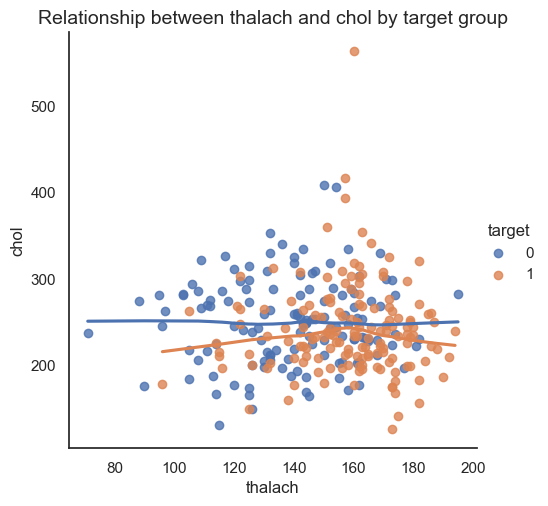

In [747]:
sns.lmplot(data=data, x='thalach', y='chol', hue='target', lowess=True)
plt.title("Relationship between thalach and chol by target group", fontsize=14)

Text(0.5, 1.0, 'Relationship between trestbps and chol by target group')

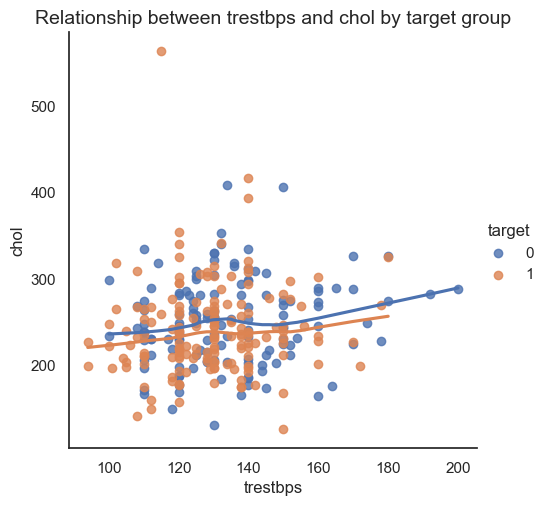

In [748]:
sns.lmplot(data=data, x='trestbps', y='chol', hue='target', lowess=True)
plt.title("Relationship between trestbps and chol by target group", fontsize=14)

The graphs show a weak interaction between chol (cholesterol level) and two physiological features—thalach (maximum heart rate) and trestbps (resting blood pressure)—with the nature of these relationships differing slightly between the groups with and without heart disease (target).In both healthy ($target=0$) and sick ($target=1$) individuals, a weak negative correlation is observed between chol and thalach; however, it is slightly more pronounced in sick individuals, which may indicate that with a higher heart rate in sick patients, the cholesterol level is more often lower. A weak positive correlation is observed between chol and trestbps, especially in the group without the disease—patients with higher pressure may have slightly higher cholesterol levels.However, the differences between the groups are not sharp overall, and it can be concluded that the interactions between chol, thalach, and trestbps have only a weak influence on the presence of cardiovascular disease, and individually, these features do not provide a clear boundary between the classes.

In [749]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

#### The Fbs Variable

fbs (Fasting Blood Sugar) is the glucose level in the blood after an 8–12 hour fast.

In the dataset, it is represented as a binary variable: $0$ — normal level ($\le 120$ mg/dL) and $1$ — elevated level ($> 120$ mg/dL). An elevated $fbs$ value does not necessarily mean diabetes, but it may indicate prediabetes, insulin resistance, or stress hyperglycemia, especially in elderly or cardiac patients. It is an important risk factor for cardiovascular diseases, as excess glucose can damage blood vessels and promote the development of atherosclerosis.  In most cases, $fbs = 1$ is less common than $fbs = 0$, which makes the variable imbalanced.

In [750]:
data['fbs'].describe()

count    299.000000
mean       0.147157
std        0.354856
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: fbs, dtype: float64

The fbs variable (fasting blood sugar level) demonstrates a pronounced imbalance: only about $14.7\%$ of patients have an elevated glucose level ($fbs = 1$), while over $85\%$ have a level within the normal range ($fbs = 0$).  The median and all quartile values are zero, which confirms the low frequency of elevated blood sugar in the sample.

##### Missing Values

===== Missing Values Analysis for: fbs =====
Missing in fbs: 4 (1.32%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             99.3      0.7
1             98.2      1.8
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.74501

Missing values may be MCAR (no significant relation to target).


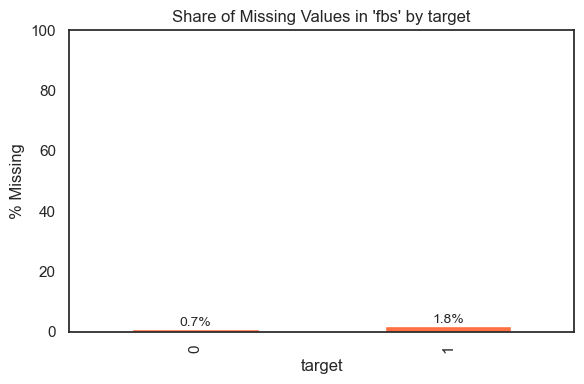

In [751]:
missing_values_report_plot(data, 'fbs')

The proportion of missing values in the fbs variable is only $1.32\%$ (4 cases), and their distribution is not related to the target variable ($p = 0.745$ by the $\chi^2$ criterion). This suggests that the missing values can be considered MCAR (Missing Completely At Random), and they do not distort the relationship between fbs and the probability of the disease. Imputing or deleting such rows should not significantly affect the analysis results.

##### Distribution

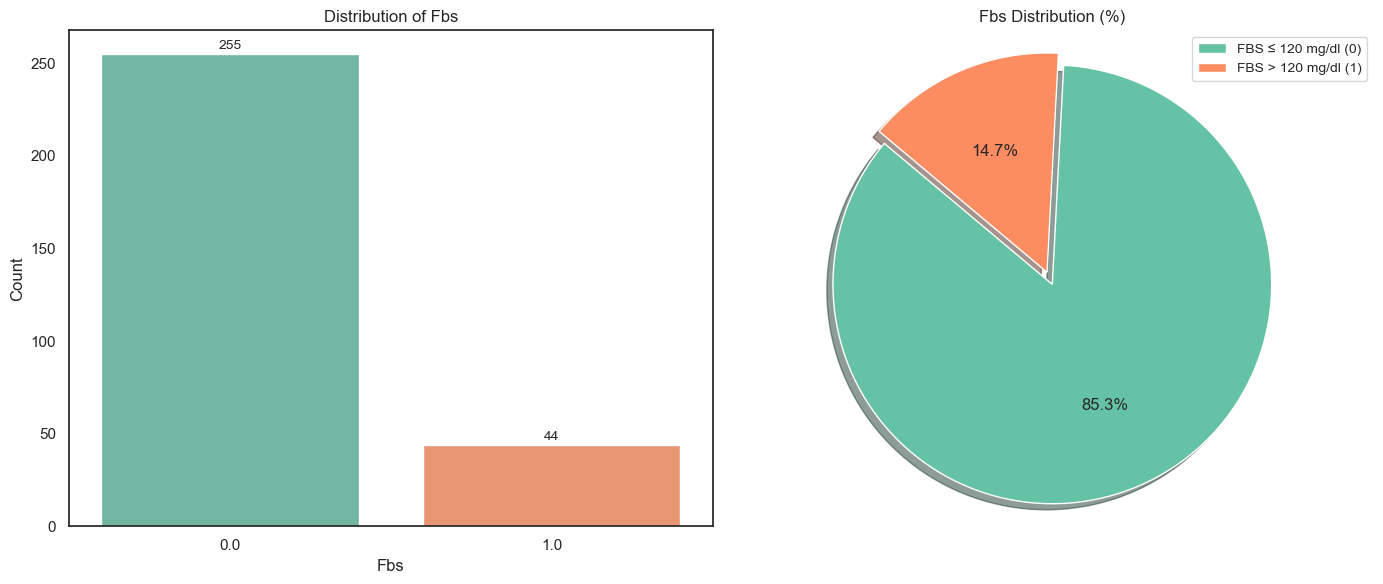

In [752]:
plot_target_distribution(data, 'fbs', legend_labels = legend_dict['fbs'])

The fbs variable (Fasting Blood Sugar) demonstrates a clearly imbalanced distribution:the majority of study participants—$85.3\%$—had normal glucose values ($\le 120$ mg/dL), while only $14.7\%$ had elevated values ($> 120$ mg/dL).

It should be noted that the threshold of $120$ mg/dL is considered outdated in terms of modern clinical guidelines. According to current criteria, fasting blood glucose is considered elevated starting at a level of $\ge 100$ mg/dL, and diabetes is diagnosed at a level of $\ge 126$ mg/dL. Thus, the binary classification in this variable ($0$: $\le 120$, $1$: $> 120$) may not reflect current diagnostic standards, which reduces its clinical relevance and limits interpretability in modern contexts.

It is important to consider this during analysis: fbs may not show the expected relationship with cardiovascular risk, as some patients with moderately elevated glucose (from $100$ to $120$ mg/dL) fall into the "normal" category.

##### Target Rate by Fbs

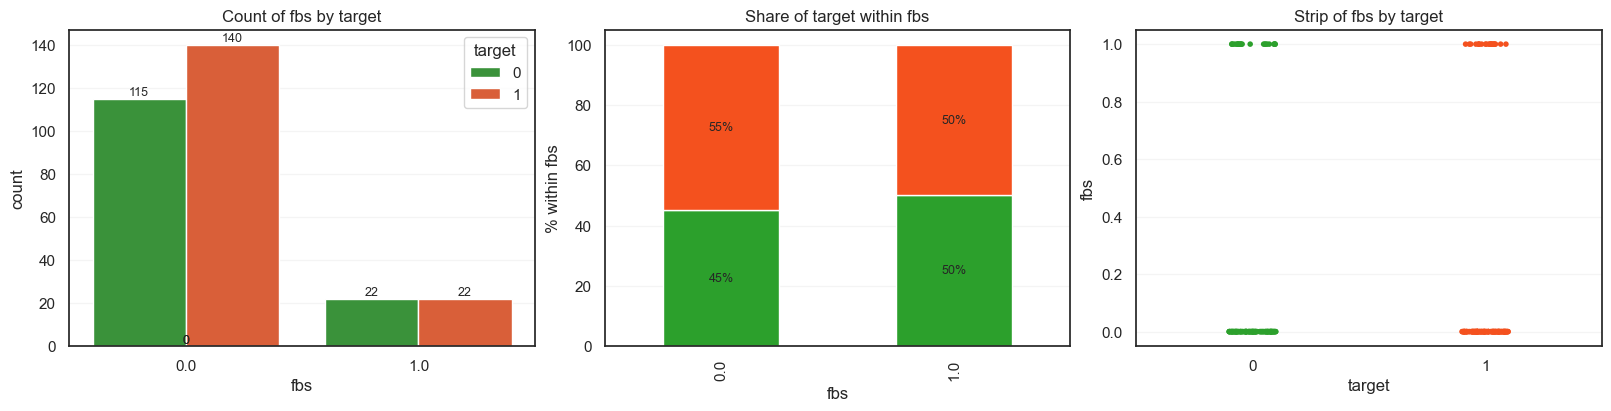

In [753]:
analyze_feature_vs_target(data, 'fbs')

The fbs variable (fasting blood sugar level) demonstrates an imbalanced distribution: $85.3\%$ of participants have normal values ($\le 120$ mg/dL), and only $14.7\%$ have elevated values ($> 120$ mg/dL).  However, the relationship of this variable with the target was inconclusive: the proportion of sick individuals is approximately $50–55\%$ both among patients with normal and elevated glucose. A statistical test (Chi-squared) showed no significant association ($p = 0.745$). Furthermore, the chosen threshold of $120$ mg/dL is considered outdated—modern clinical guidelines identify prediabetes starting at $\ge 100$ mg/dL, meaning that potentially significant information in the $100–120$ mg/dL range is lost. All this reduces the prognostic value of fbs in its current form and casts doubt on its usefulness without reclassification or a more precise representation.

<Axes: xlabel='fbs', ylabel='thalach'>

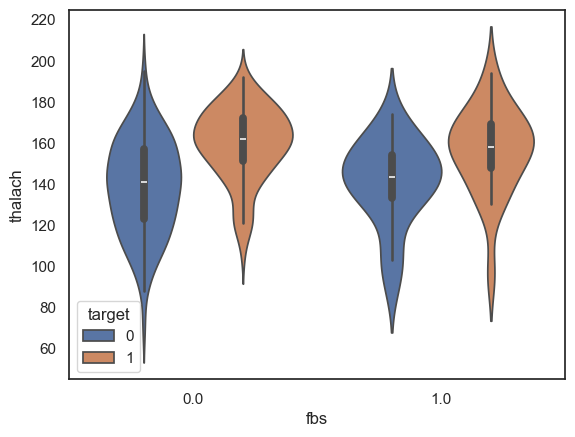

In [754]:
sns.violinplot(x='fbs', y='thalach', hue='target', data=data)

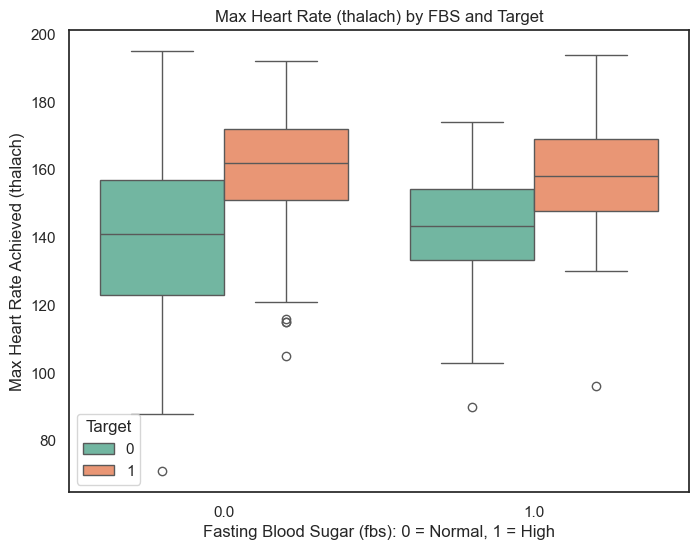

In [755]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='fbs', y='thalach', hue='target', data=data, palette='Set2')
plt.title('Max Heart Rate (thalach) by FBS and Target')
plt.xlabel('Fasting Blood Sugar (fbs): 0 = Normal, 1 = High')
plt.ylabel('Max Heart Rate Achieved (thalach)')
plt.legend(title='Target')
plt.show()

In sick individuals ($target = 1$), regardless of their fasting blood sugar level (fbs), the maximum heart rate (thalach) is on average higher than in healthy individuals ($target = 0$). This is especially noticeable with a normal sugar level ($fbs = 0$).

However, with elevated fbs (a possible sign of diabetes), a decrease in thalach is observed in sick individuals—the median value is lower than when $fbs = 0$.

This may indicate a possible link between diabetes and reduced physical endurance in CAD patients.

It is also interesting that in healthy individuals ($target = 0$), thalach remains at a stable level regardless of fbs.

However, it is important to consider that thalach is closely related to age—its "normal" values are individual and calculated using the formula $220 - \text{age}$. Without considering age, it is difficult to definitively judge whether the decrease in thalach is a pathology or a physiological norm for that age group.

#### The Restecg Variable

restecg (Resting Electrocardiographic Results) is a variable reflecting the results of a resting ECG.

It is used to assess the electrical activity of the heart and diagnose possible abnormalities. This indicator helps identify myocardial ischemia, left ventricular hypertrophy (LVH), and conduction disorders.

The following encoding is used in the dataset:
* $0$ — Normal ECG, no deviations.
* $1$ — Presence of ST-T wave abnormalities (e.g., ST depression $\ge 0.5$ mm, T-wave inversion), which may indicate ischemic changes.
* $2$ — Signs of left ventricular hypertrophy, most often determined by the Sokolov–Lyon criteria (e.g., increased amplitude of S and R waves on the ECG).

Clinically significant: such ECG changes often accompany cardiovascular diseases and can be an important predictor of the risk of myocardial infarction or other complications.


In [757]:
data['restecg'].describe()

count    300.000000
mean       0.526667
std        0.526192
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: restecg, dtype: float64

Most patients have ST-T segment abnormalities (code 1)—the median and the $75$th percentile are equal to $1$. A normal ECG (code $0$) is less common, and left ventricular hypertrophy (code $2$) is significantly less common ($\max = 2$, but $75\%$ of observations $\le 1$).

##### Missing Values

===== Missing Values Analysis for: restecg =====
Missing in restecg: 3 (0.99%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0            100.0      0.0
1             98.2      1.8
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.31280

Missing values may be MCAR (no significant relation to target).


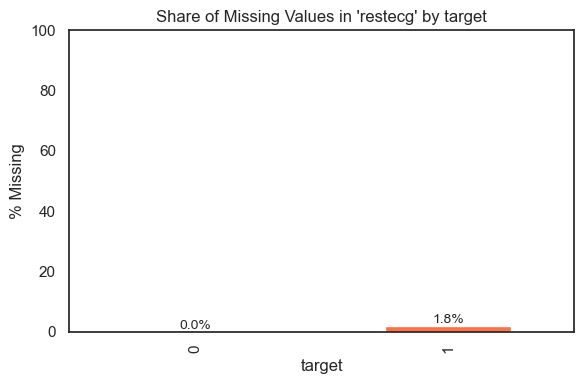

In [758]:
missing_values_report_plot(data, 'restecg')

Missing values constitute $0.99\%$ and are observed only among patients with heart disease ($target = 1$, $1.8\%$). However, the $p$-value $= 0.31$, which is higher than the significance threshold. This means that the relationship between missing values and the target variable is statistically insignificant, and the missing values can be conditionally considered MCAR (Missing Completely At Random).
Consequently, simple imputation methods can be safely used without distorting the data structure.

##### Distribution

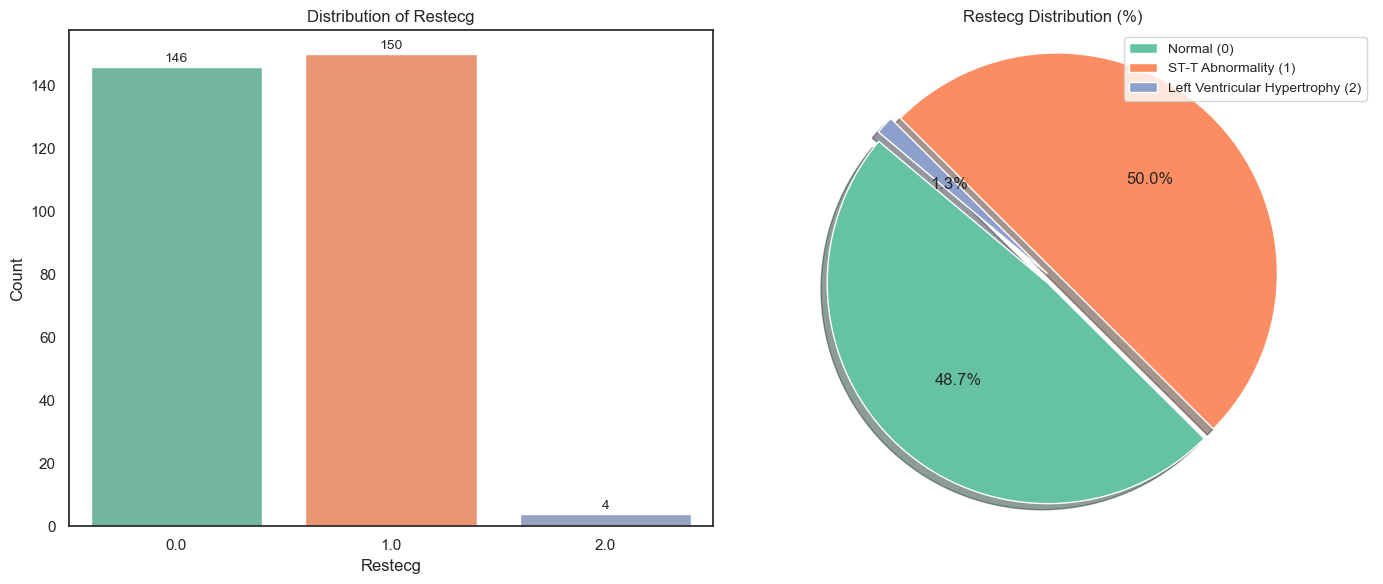

In [759]:
plot_target_distribution(data, 'restecg', legend_labels = legend_dict['restecg'])

Almost half of the patients have ST-T segment abnormalities ($50\%$), which may indicate myocardial ischemia. Another $48.7\%$ have a normal ECG, and only $1.3\%$ of patients show signs of left ventricular hypertrophy, which is extremely rare.This suggests that ECG pathologies are common, and the restecg feature may carry important information.

##### Target Rate by Restecg

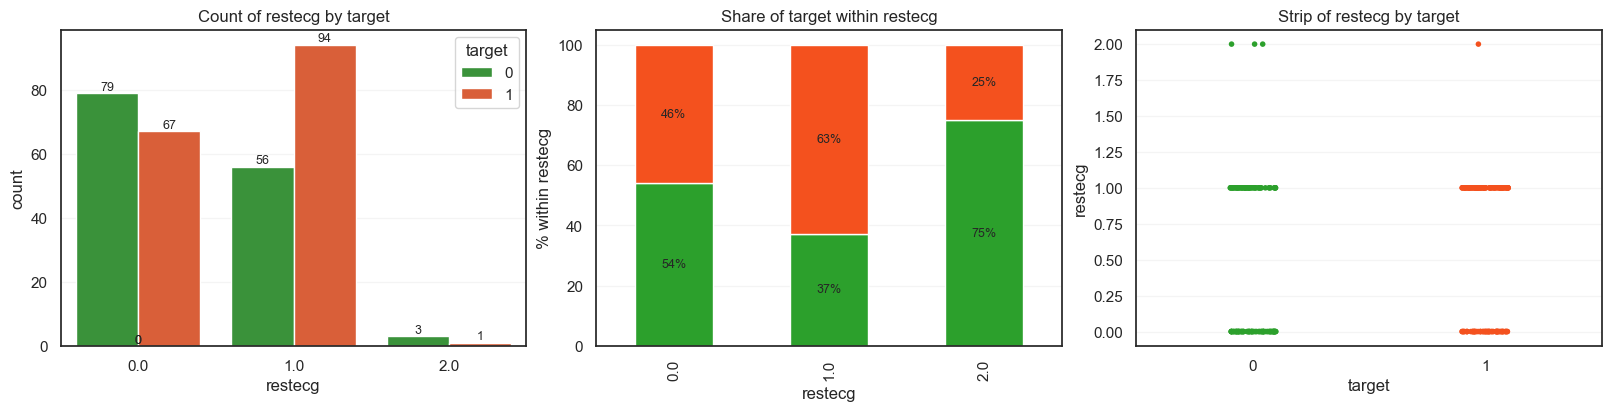

In [760]:
analyze_feature_vs_target(data, 'restecg')

The restecg variable (resting ECG results) shows a potential link with heart disease: at a value of $1$ (ST-T abnormalities), the proportion of sick individuals is higher ($63\%$) compared to a normal ECG ($46\%$).  However, the statistical significance of the relationship with the target variable ($p \approx 0.31$) was not reached, which is due to the imbalance and the small number of observations, especially for the value $2$ (LV hypertrophy) — only 4 cases in the sample. Analysis by age groups also did not reveal significant differences ($p > 0.1$), as the value $2$ is absent in younger people and extremely rare in the elderly. Despite this, the variable is clinically significant and may be useful in combination with other features.

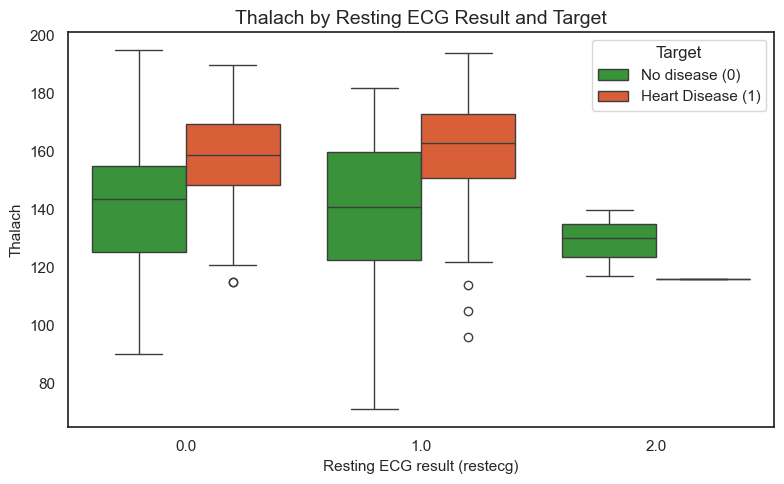

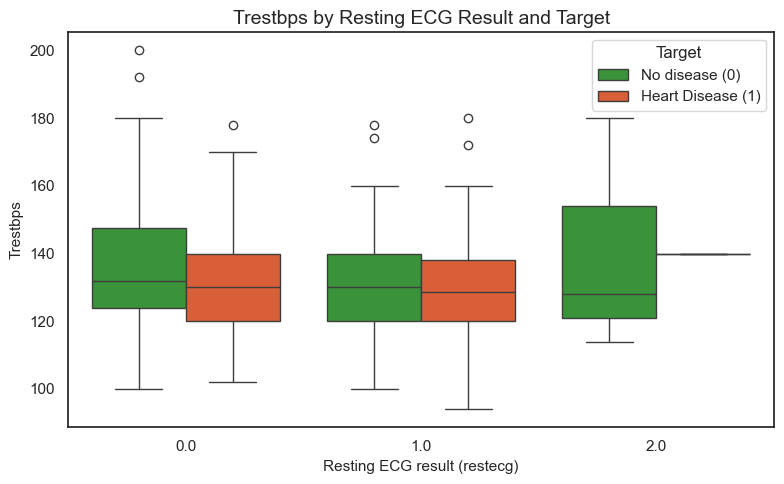

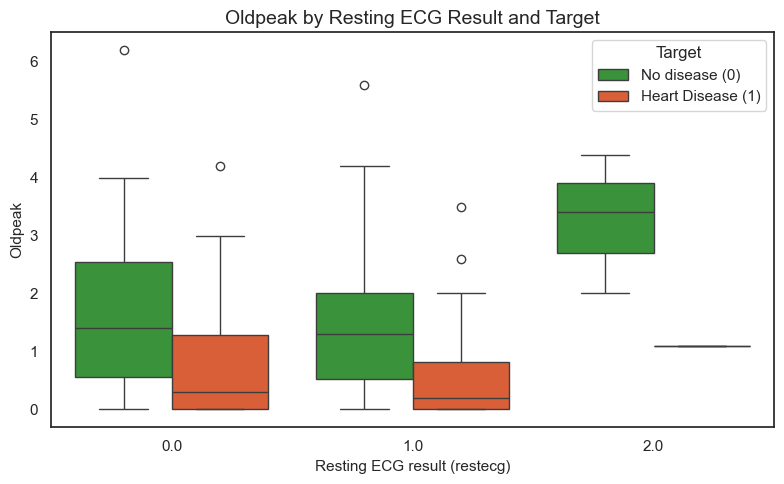

In [761]:
for val in ['thalach', 'trestbps', 'oldpeak']:
    palette = {0: '#2CA02C', 1: '#F4511E'}
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        x='restecg', y=val, data=df,
        hue='target', palette=palette
    )
    
    ax.set_title(f'{val.capitalize()} by Resting ECG Result and Target', fontsize=14)
    ax.set_xlabel('Resting ECG result (restecg)', fontsize=11)
    ax.set_ylabel(val.capitalize(), fontsize=11)

    # Обновляем легенду вручную, чтобы цвета совпадали
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No disease (0)', 'Heart Disease (1)'], title='Target', loc='best')

    plt.tight_layout()
    plt.show()

Visual analysis of the features thalach, trestbps, and oldpeak across the rest ECG results (restecg) and the presence of heart disease (target) shows that oldpeak and thalach have the highest diagnostic value.In patients with heart disease ($target = 1$), significantly lower oldpeak values are observed—especially with a normal ECG and ST-T abnormalities. This makes oldpeak one of the strongest features: higher values are more characteristic of healthy individuals, while values close to zero prevail in sick individuals.Sick individuals also more often have higher thalach (maximum exercise heart rate) values, which may indicate reduced cardiovascular system adaptation. At the same time, trestbps (resting blood pressure) does not show a significant difference between the groups and, apparently, is weaker related to the presence of the disease.Furthermore, the type of ECG (restecg) helps better reveal differences between the groups: this is especially clear when analyzing oldpeak and thalach, where the distributions significantly diverge.

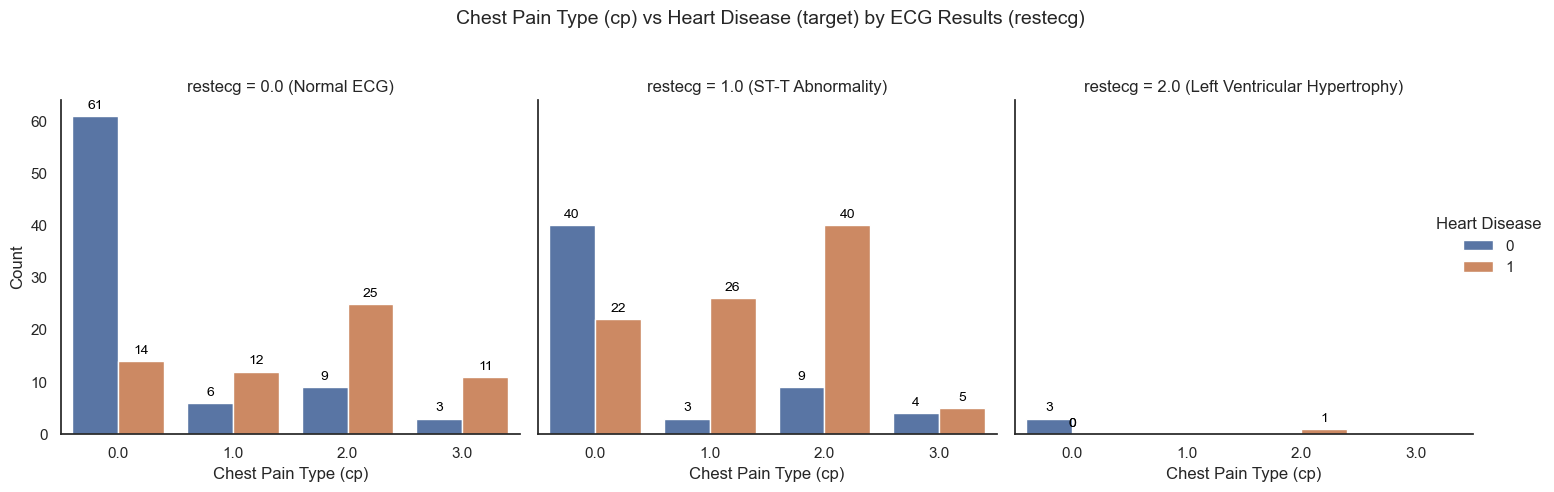

In [762]:
g = sns.catplot(data=df, x='cp', hue='target', col='restecg', kind='count', height=5, aspect=1)
# Названия для restecg
restecg_labels = {
    0: "Normal ECG",
    1: "ST-T Abnormality",
    2: "Left Ventricular Hypertrophy"
}
# Добавим заголовки к каждому подграфику
for ax, title in zip(g.axes.flat, df['restecg'].sort_values().unique()):
    ax.set_title(f"restecg = {title} ({restecg_labels.get(title, '')})")

    # Добавим числа на столбцы
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=10, color='black',
            xytext=(0, 3),
            textcoords='offset points'
        )
# Общий заголовок
plt.subplots_adjust(top=0.8)
g.fig.suptitle("Chest Pain Type (cp) vs Heart Disease (target) by ECG Results (restecg)", fontsize=14)

# Подписи осей
g.set_axis_labels("Chest Pain Type (cp)", "Count")
g._legend.set_title("Heart Disease")

The analysis of the relationship between chest pain type (cp), resting ECG results (restecg), and the presence of heart disease (target) reveals clear patterns. With a normal ECG ($restecg = 0$), the vast majority of patients with chest pain type $cp = 0$ (typical angina) do not have heart disease (61 without disease vs. 14 with disease). With ST-T abnormalities ($restecg = 1$), the opposite trend is observed: chest pain type $cp = 2$ (non-anginal discomfort) is more frequently associated with the disease (40 sick vs. 9 healthy), and $cp = 1$ also shows a significant shift towards sick individuals (26 vs. 3). This may indicate that when ECG changes are present, atypical chest pain becomes a more significant predictor of heart disease. For the rare category with left ventricular hypertrophy ($restecg = 2$), data is scarce, but of the three individuals with $cp = 0$, none are sick, and one case of disease was present with $cp = 2$. Overall, the combination of chest pain type and ECG abnormalities significantly increases the probability of heart disease, especially with $cp = 1–2$ and $restecg = 1$.

#### The Thalach Variable

Thalach (Maximum Heart Rate Achieved) is the maximum heart rate reached during an exercise stress test (in beats per minute). It serves as an important prognostic indicator in assessing cardiac health.

The expected maximum is usually calculated using the formula: $220 - \text{age}$, with an acceptable range of $\pm 10–15$ bpm. A normal response is considered when the patient reaches $85–100\%$ of this value. If the rate is below $85\%$, it may indicate myocardial ischemia, poor physical fitness, or the effect of medications (e.g., beta-blockers). An excessively high rate ($> 100\%$) may be observed in compensatory tachycardia, anemia, or hyperthyroidism.

Thus, both decreased and increased thalach values require interpretation in the context of age, symptoms, and concomitant factors.

Compensatory tachycardia is an increase in heart rate (HR) that occurs when the heart tries to "compensate" for a lack of blood supply or oxygen in the body.

Important: The exercise stress test, and consequently the thalach measurement, is not performed on all patients. It may not be prescribed for the elderly, patients with a severe course of the disease, or those with contraindications to physical exercise. Therefore, the absence or unusual values of thalach always require interpretation in the clinical context.

In [764]:
data['thalach'].describe()

count    291.000000
mean     149.505155
std       22.824574
min       71.000000
25%      133.500000
50%      153.000000
75%      166.000000
max      195.000000
Name: thalach, dtype: float64

Most patients' thalach (maximum heart rate achieved on the exercise test) was within the normal range—an average of $149$ bpm, median $153$. This is close to the expected values for ages $50–60$. However, for some patients, the heart rate was noticeably lower: $25\%$ were below $133$ bpm, which may indicate heart problems or medication use. The maximum value is $195$ bpm, possibly related to compensatory tachycardia.

##### Missing Values

===== Missing Values Analysis for: thalach =====
Missing in thalach: 12 (3.96%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             98.6      1.4
1             93.9      6.1
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.07944

Missing values may be MCAR (no significant relation to target).


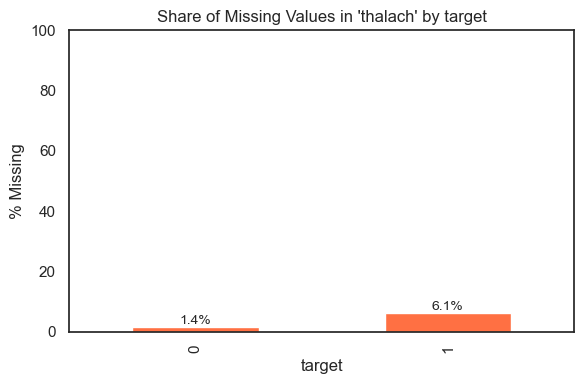

In [765]:
missing_values_report_plot(data, 'thalach')

The thalach value is missing for 12 individuals (approximately $4\%$). Missing values occur more frequently in sick individuals ($target = 1$): $6.1\%$ versus $1.4\%$ in healthy individuals, but this is not statistically significant ($p = 0.079$), meaning the missing values can be considered random (MCAR).

In [766]:
data[data['thalach'].isna()].groupby('age').size()

age
29.0    1
41.0    1
44.0    1
46.0    1
51.0    1
53.0    1
56.0    1
58.0    1
63.0    1
64.0    1
65.0    2
dtype: int64

Of the 12 missing values in the thalach feature, all are distributed across different ages, from $29$ to $65$ years old, without clear concentration in one age group.

##### Distribution

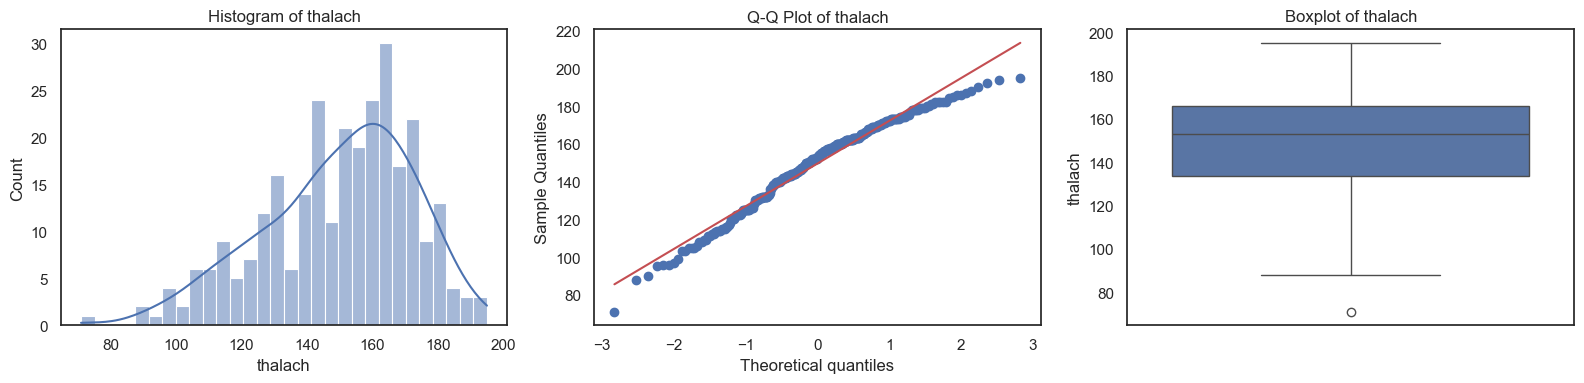

In [767]:
diagnostic_plots(data, 'thalach')

The distribution of the thalach variable (maximum heart rate) is generally close to normal, with a slight left skew—values are slightly shifted toward lower heart rates. The histogram shows that the main peak is around $\sim 160$ beats per minute, and the Q–Q plot confirms near normality, except for minor deviations in the tails. The Boxplot indicates that the median is about $153$ bpm, with an interquartile range from $\sim 133$ to $\sim 166$. There are a few outliers present in the lower part. Overall, thalach can be analyzed as an approximately normally distributed variable.

##### Target Rate by Fbs

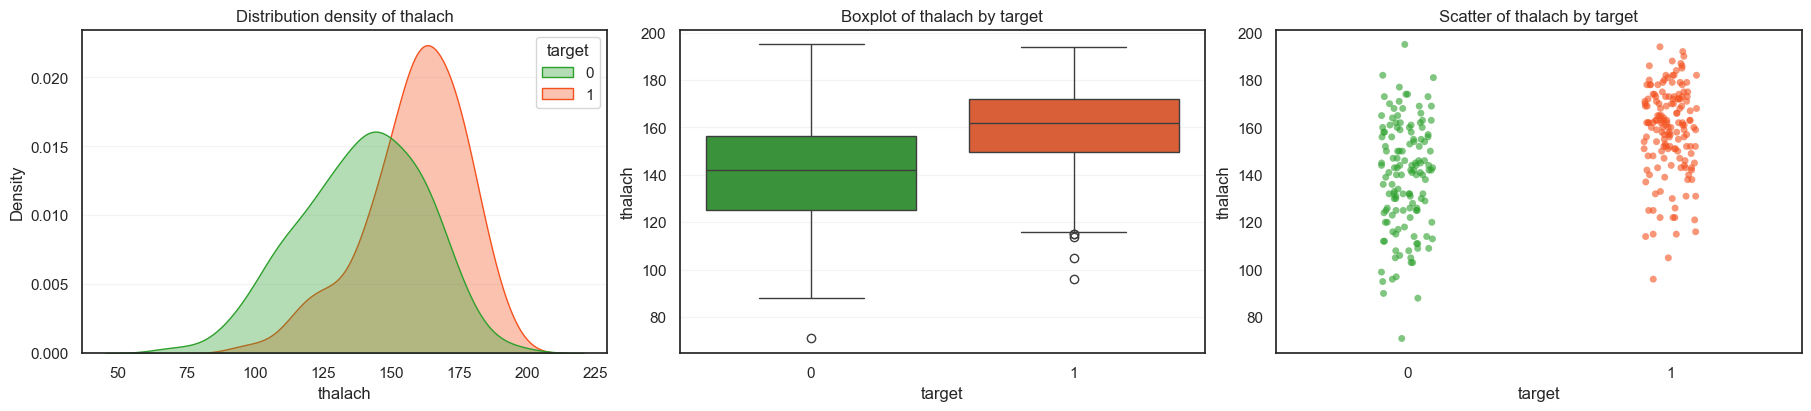

In [768]:
analyze_feature_vs_target(data, 'thalach')

The maximum heart rate (thalach) differs noticeably between groups with and without heart disease (target). In sick individuals ($target = 1$), the heart rate is higher on average: their distribution is shifted to the right, and the median is significantly higher than in healthy individuals—this is visible on both the density plot and the boxplot. Furthermore, sick individuals have almost no extremely low values, whereas in healthy individuals, heart rates below $100$ occur, and even one outlier around $70$. This aligns with medical data—in ischemic heart disease, the heart may fail to reach high frequencies during exercise. Thus, thalach is an important predictor of the presence of the disease.

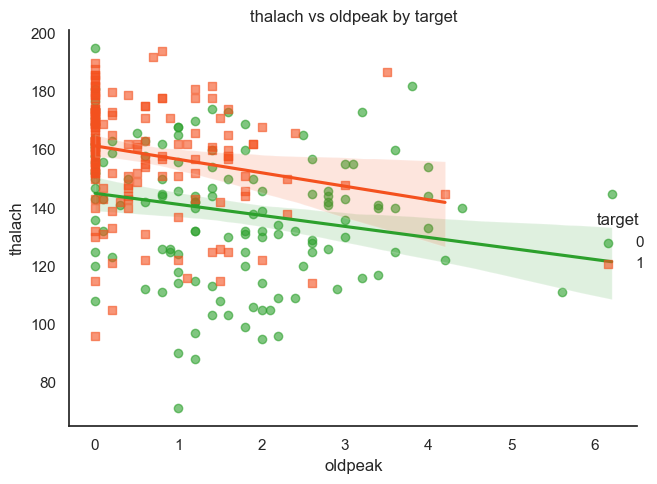

In [769]:
sns.lmplot(
    data=data,
    x='oldpeak',
    y='thalach',
    hue='target',
    palette=palette,
    height=5,
    aspect=1.2,
    markers=['o', 's'],
    scatter_kws={'alpha': 0.6}
)
plt.title('thalach vs oldpeak by target', fontsize=12)
plt.tight_layout()
plt.show()

The scatter plot with regression lines shows a negative relationship between oldpeak and thalach—as the ST segment depression (oldpeak) increases, the maximum heart rate (thalach) decreases. This relationship is observed in both groups ($target = 0$ — without disease, $target = 1$ — with disease), but is particularly pronounced in patients without heart disease ($target = 0$). In patients with disease ($target = 1$), the decrease in thalach as oldpeak increases is also noticeable but less pronounced. This may reflect differences in the physiological response to exercise between the groups.
Thus, the weak negative relationship in sick individuals and the strong one in healthy individuals may indicate that in patients with ischemia, the heart loses the ability to adapt adequately, which serves as an additional diagnostic sign.

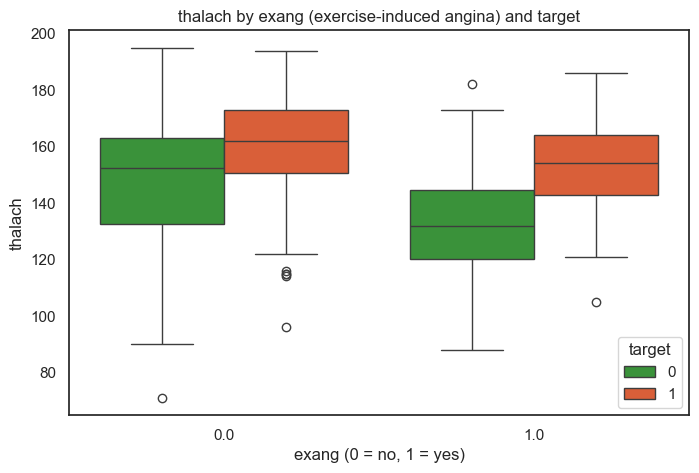

In [770]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='exang', y='thalach', hue='target', palette=palette)
plt.title('thalach by exang (exercise-induced angina) and target')
plt.xlabel('exang (0 = no, 1 = yes)')
plt.show()

In patients with heart disease ($target = 1$), thalach (maximum heart rate) values are on average higher than in healthy individuals ($target = 0$), regardless of the presence of exercise-induced angina (exang).
However, in healthy patients ($target = 0$), thalach significantly decreases if angina appears during exercise ($exang = 1$). This may indicate a natural limitation of heart rate due to pain syndrome.
Thus, high thalach in the presence of $exang = 1$ is more often observed in sick individuals and may be a potential diagnostic indicator.

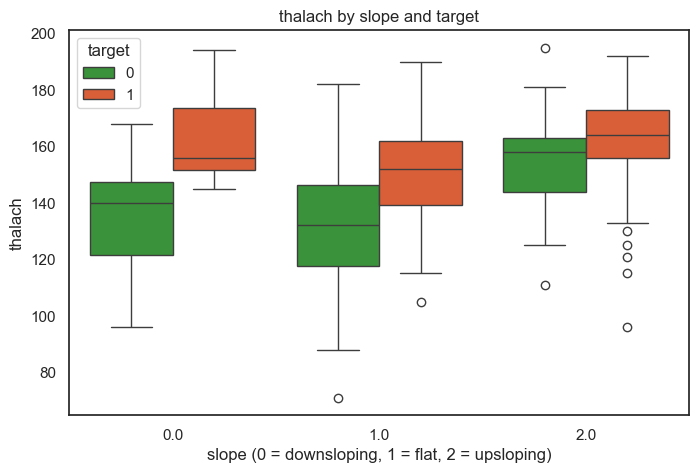

In [771]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='slope', y='thalach', hue='target', palette=palette)
plt.title('thalach by slope and target')
plt.xlabel('slope (0 = downsloping, 1 = flat, 2 = upsloping)')
plt.ylabel('thalach')
plt.show()

The values of thalach (maximum heart rate) are generally higher in patients with the disease ($target = 1$) for any type of ST segment slope (slope), but the difference is especially noticeable at $slope = 0$ (downsloping), where the heart rate in sick individuals is significantly higher than in healthy individuals. Also, at $slope = 2$ (upsloping), the highest thalach values are observed in patients with the disease, which may indicate better preservation of heart rate even under stress. In healthy individuals ($target = 0$), the maximum heart rate is consistently lower across all slope values, especially at $slope = 1$ (flat). These observations confirm the link between the shape of the ST segment and the peak heart rate, which can be a useful diagnostic marker when interpreting an ECG in combination with stress tests.

#### The Exang Variable

exang is a binary variable indicating the presence of exercise-induced angina.

* Value 0: No exercise-induced angina
* Value 1: Exercise-induced angina present

Clinical Significance: Angina is pain or discomfort in the chest that occurs when the heart does not receive enough oxygen during physical activity. Its presence during exercise may indicate Ischemic Heart Disease (IHD) and reduced exercise tolerance.

Why it is important: exang is a simple yet informative marker that can be useful in assessing the risk of cardiovascular disease. In combination with other variables, such as thalach (max. heart rate) and oldpeak (ST-segment depression), it helps identify deviations related to the disease.

In [773]:
data['exang'].describe()

count    298.000000
mean       0.328859
std        0.470589
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: exang, dtype: float64

The exang variable (exercise-induced angina) indicates whether the patient experiences angina during physical exercise. In a sample of 298 individuals, approximately $33\%$ (mean value — $0.329$) report the presence of angina ($exang = 1$), while in the majority (about $67\%$), this symptom is absent ($exang = 0$). The distribution is binary and uneven: the median and $75$th percentile correspond to $0$ and $1$, respectively.

##### Missing Values

===== Missing Values Analysis for: exang =====
Missing in exang: 5 (1.65%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             97.8      2.2
1             98.8      1.2
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.84014

Missing values may be MCAR (no significant relation to target).


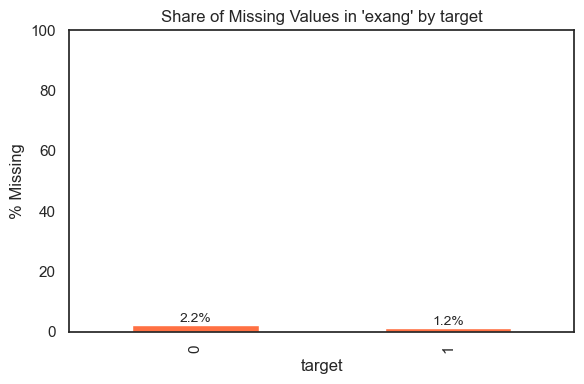

In [774]:
missing_values_report_plot(data, 'exang')

Five missing values were found in the exang variable (presence of exercise-induced angina), which constitutes $1.65\%$ of the entire dataset. The distribution of missing values across the target variable (target) shows that $2.2\%$ are missing among healthy patients ($target = 0$), and $1.2\%$ among sick patients ($target = 1$).A statistical test (chi-square) yielded a $p$-value $= 0.84014$, which is much higher than the threshold value of $0.05$. This indicates a lack of a statistically significant relationship between the missing values and the presence of the disease. Consequently, the missing values can be considered MCAR (Missing Completely At Random) — that is, random and unrelated to the target variable.

##### Distribution

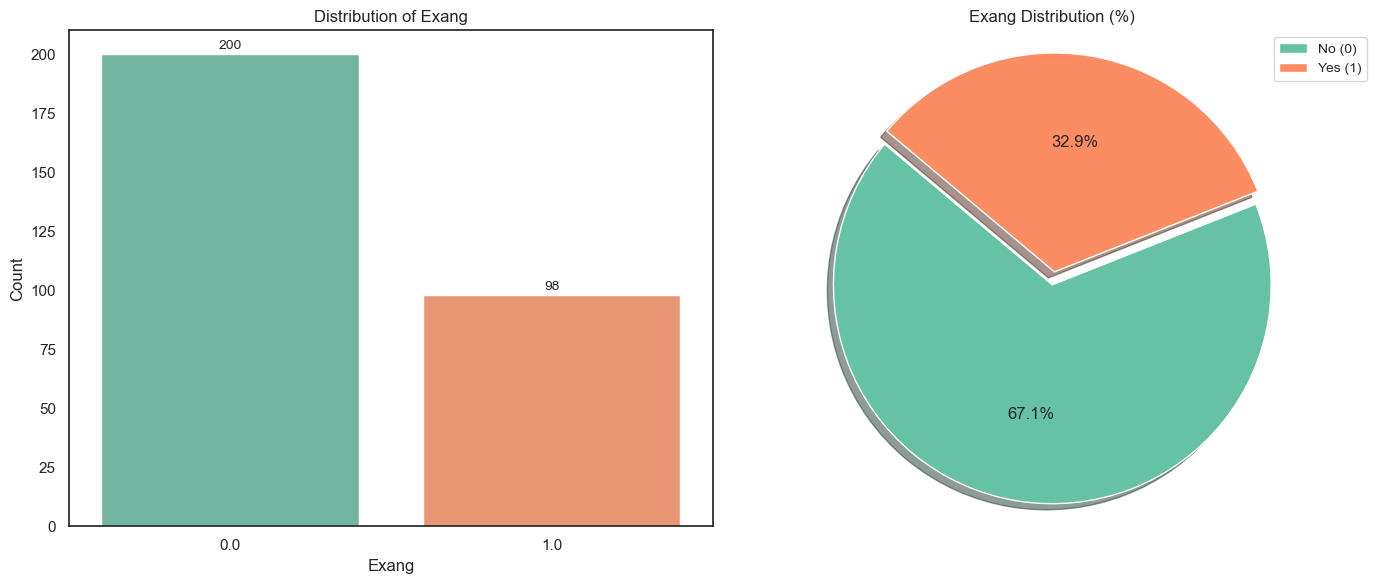

In [775]:
plot_target_distribution(data, 'exang', legend_labels = legend_dict['exang'])

In the sample, $67\%$ of patients do not experience exercise-induced angina ($exang = 0$), and $33\%$ do ($exang = 1$). However, the risk of Ischemic Heart Disease (IHD) is higher among those who do not have angina—especially in the group under 50 years old, where $80\%$ with $exang = 0$ are sick, versus $30\%$ with $exang = 1$.

This seemingly contradictory behavior is medically explained: the presence of pain during exercise indicates compensated ischemia, whereas its absence can mask severe impairments. The relationship is statistically confirmed ($p < 0.005$), and exang can be considered a reliable predictor of IHD, especially in combination with age.

##### Target Rate by Fbs

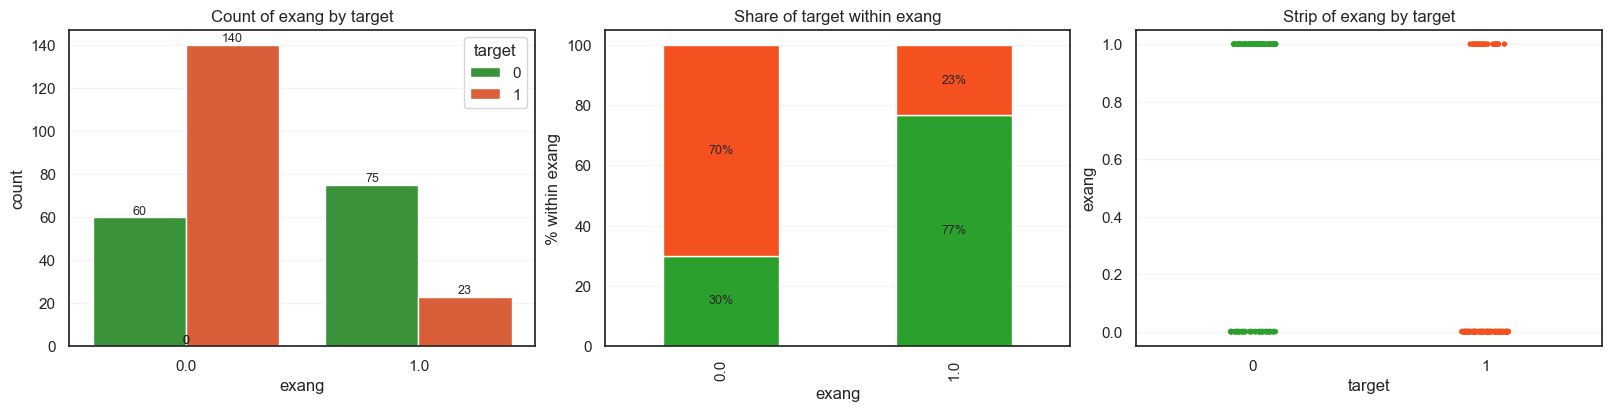

In [776]:
analyze_feature_vs_target(data, 'exang')

The exang variable (exercise-induced angina) shows a pronounced dependence on the target variable: among patients without exercise-induced angina ($exang = 0$), $70\%$ are sick, while among those who have it ($exang = 1$), only $23\%$ have the disease. This is confirmed by all charts: both by the number of cases and by the percentage distribution. Thus, the presence of pain during exercise is statistically associated with a lower probability of heart disease, which may reflect features of diagnosis or clinical manifestations of the disease.

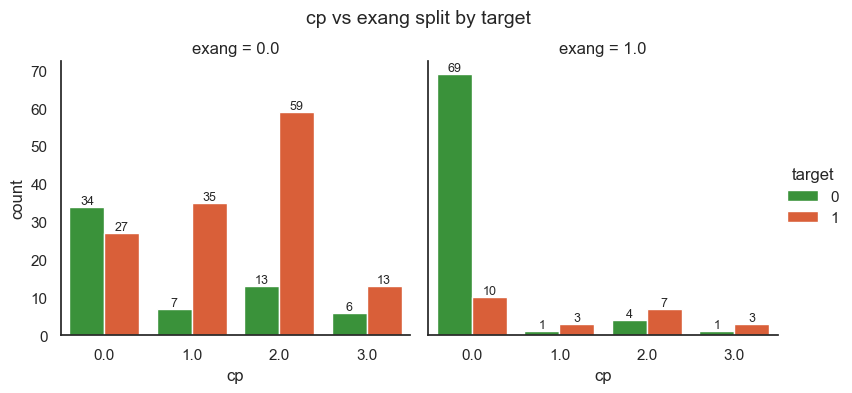

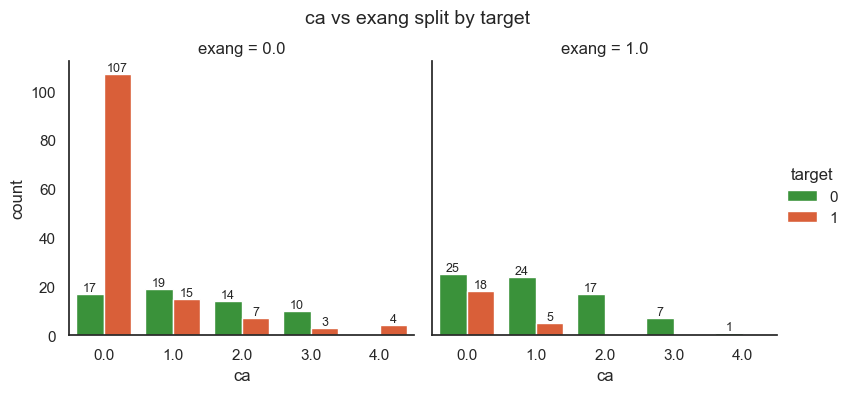

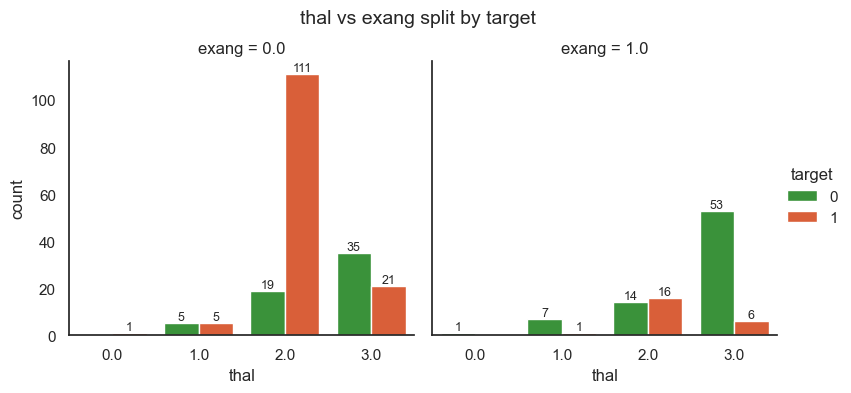

In [777]:
for feature in ['cp', 'ca', 'thal']:
    g = sns.catplot(
        data=data, x=feature, hue='target', col='exang',
        kind='count', height=4, aspect=1, palette=palette
    )

    # Добавим подписи над столбиками
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{feature} vs exang split by target", fontsize=14)
    plt.show()

Based on the charts analyzing the relationship between exang (exercise-induced angina) and the variables cp, ca, and thal across the target variable target, the following conclusion can be drawn:Patients without exercise-induced angina ($exang = 0$) are noticeably more likely to show signs of heart disease ($target = 1$) when certain combinations of factors are present: most frequently, this involves a high level of $cp = 2$ (chest pain type), $ca = 0$ (no major vessels colored), and $thal = 2$ (fixed perfusion defect). Conversely, when exercise-induced angina is present ($exang = 1$), sick individuals are significantly less likely to have heart disease ($target = 0$), especially with $cp = 0$, $ca = 0–1$, and $thal = 3$. This may indicate that exercise-induced angina without other serious abnormalities (especially in thal and cp) is not a reliable marker of the disease. Such visualizations help reveal complex feature interactions that either strengthen or, conversely, weaken the prognostic power of exang under specific clinical profiles.

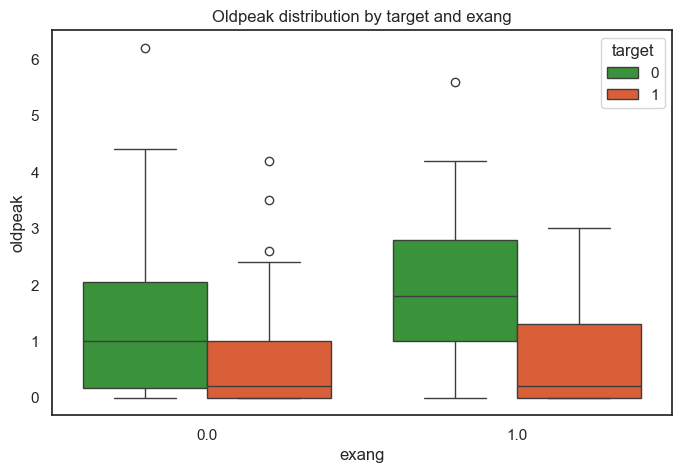

In [778]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='exang', y='oldpeak', hue='target', palette=palette)
plt.title('Oldpeak distribution by target and exang')
plt.show()

The chart shows that the oldpeak value (ST segment depression after exercise) is significantly higher in healthy patients ($target = 0$) than in sick patients ($target = 1$), regardless of the presence of exercise-induced angina (exang). The difference is particularly noticeable when $exang = 0$, where the median oldpeak for healthy individuals is approximately $5$ times higher than for sick individuals. Even when angina is present ($exang = 1$), the oldpeak remains consistently low in sick individuals. This suggests a complex relationship: a high oldpeak value is more often observed in healthy individuals, especially with angina, while in sick individuals, oldpeak is consistently low at any level of exang. This behavior may seem paradoxical but might reflect specifics of pathophysiology or diagnostic criteria in the dataset. In any case, oldpeak combined with exang demonstrates strong potential for class separation and should be considered in model building.

#### The Oldpeak Variable

Oldpeak is an indicator of ST segment depression on an electrocardiogram (ECG) after physical exercise. It is measured in millimeters and reflects the degree of deviation of the ST segment from the isoelectric line (usually downwards). In clinical practice, ST depression is considered a potential indicator of myocardial ischemia, meaning insufficient blood supply to the heart.

* Normal: oldpeak values of $0–1$ mm are usually considered physiological or borderline, especially in the absence of other alarming symptoms.
* Pathological Values: Depression greater than $1$ mm (i.e., $oldpeak > 1.0$) is interpreted as abnormal and requires further investigation for ischemia. Values above $2$ mm are particularly concerning, as they are often associated with significant coronary blood flow impairment in clinical practice.

In [780]:
data['oldpeak'].describe()

count    300.000000
mean       1.046000
std        1.163729
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64

Oldpeak ranges from $0.0$ to $6.2$, with a median of $0.8$ and a mean of $1.05$, indicating a right skew. $25\%$ of patients have a value of $0.0$, and $75\%$ are below $1.6$, meaning the majority have normal or borderline readings. Values above $1–2$ mm are less common but may indicate ischemia.

##### Missing Values

===== Missing Values Analysis for: oldpeak =====
Missing in oldpeak: 3 (0.99%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0            100.0      0.0
1             98.2      1.8
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.31280

Missing values may be MCAR (no significant relation to target).


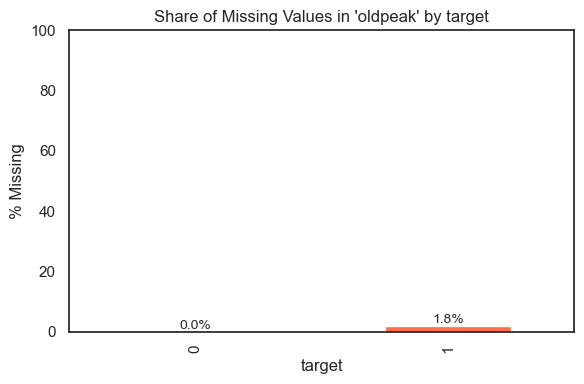

In [781]:
missing_values_report_plot(data, 'oldpeak')

The analysis of missing values for the oldpeak variable showed that only 3 values are missing, which constitutes $0.99\%$ of the entire dataset—a very low level of missingness. Furthermore, the distribution of missing values across the target variable (target) does not show a statistically significant dependence: there are no missing values among patients with $target = 0$ (no disease), and missing values account for only $1.8\%$ among patients with $target = 1$ (disease present).

The results of the chi-square test ($p$-value $= 0.3128$) confirm the absence of a significant relationship between the presence of a missing value and the presence of the disease. Therefore, the missing values can be considered MCAR (Missing Completely at Random) — i.e., the missingness is random and does not depend on the target variable.

##### Distribution

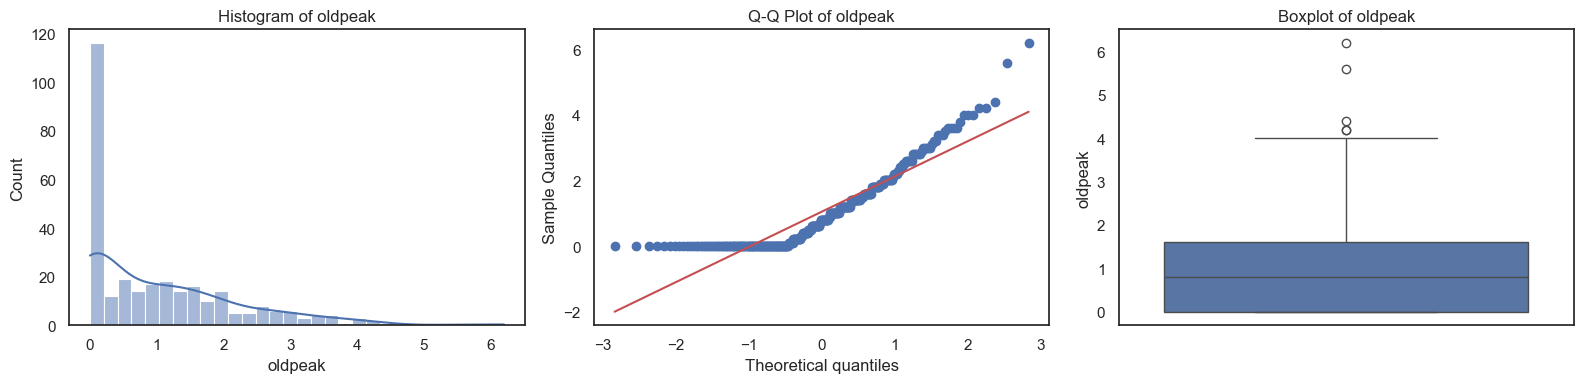

In [782]:
diagnostic_plots(data, 'oldpeak')

The distribution of oldpeak shows a pronounced positive skew: most values are concentrated around $0.0–1.0$ mm, which is confirmed by the peak on the histogram and the quartile values (median $= 0.8$, $25\% = 0.0$, $75\% = 1.6$).  The Q-Q plot shows a significant deviation from a normal distribution, especially in the tails—outliers are present in the upper range (up to $6.2$ mm). The Boxplot also shows the presence of multiple outliers, starting from the $4$ mm level. Such cases may indicate severe myocardial ischemia. Overall, the vast majority of patients have oldpeak within the normal range (up to $1–1.5$ mm), but a proportion with elevated values requires clinical attention.

##### Target Rate by Fbs

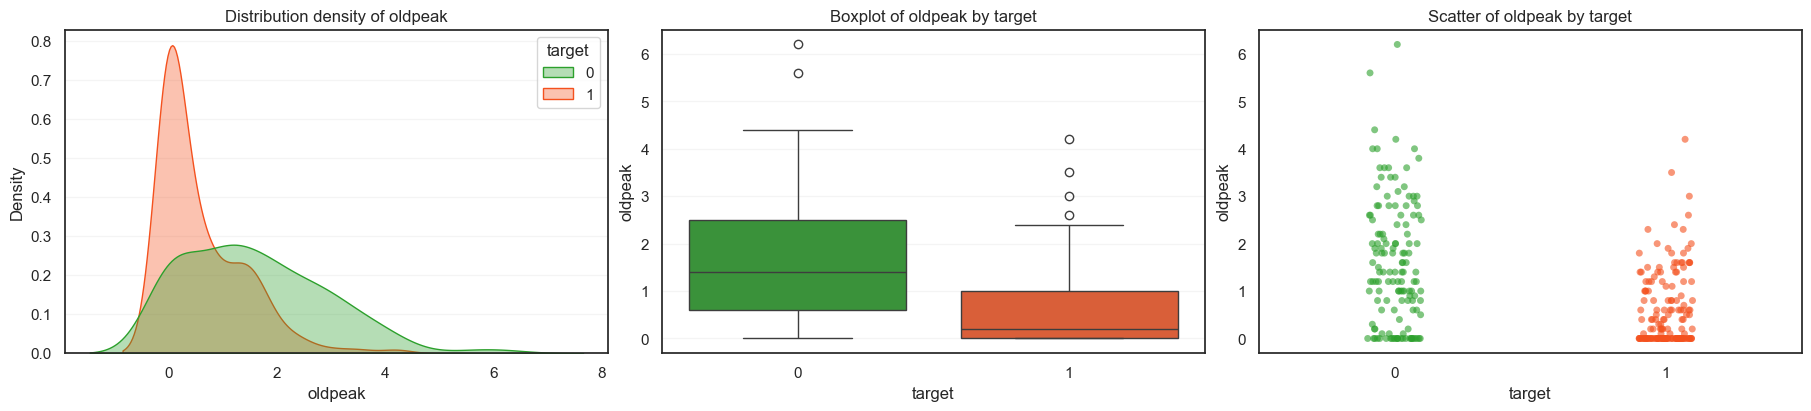

In [783]:
analyze_feature_vs_target(data, 'oldpeak')

Patients with heart disease ($target = 1$) have significantly lower oldpeak values: the median is about $0.2$, with most being less than $1$. This is confirmed by a sharp density peak near zero and a "compressed" boxplot.  Meanwhile, patients without the disease ($target = 0$) more often exhibit elevated oldpeak values, up to $6.2$, with a median around $1.6$ and a pronounced spread. This is unexpected, as high oldpeak is typically associated with ischemia, but here, higher values are characteristic of healthy individuals ($target = 0$). A possible explanation is that oldpeak was recorded for all patients under stress, but the disease was diagnosed based on other signs, and some healthy individuals had "false positive" ischemia (e.g., due to hypertrophy). Thus, the correlation is inverse: the higher the oldpeak, the lower the probability of the disease in this sample.

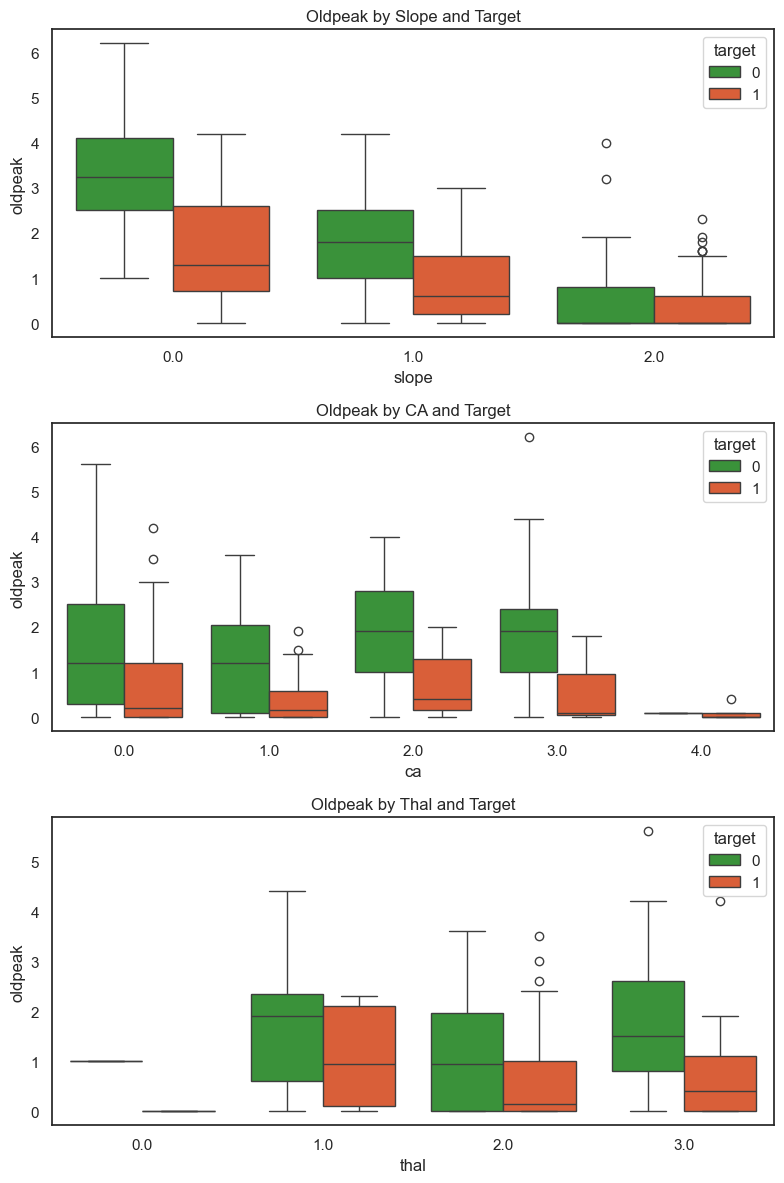

In [784]:
plt.figure(figsize=(8, 12))

# OLDPEAK × SLOPE
plt.subplot(3, 1, 1)
sns.boxplot(x="slope", y="oldpeak", hue="target", data=data, palette=palette)
plt.title("Oldpeak by Slope and Target")

# OLDPEAK × CA
plt.subplot(3, 1, 2)
sns.boxplot(x="ca", y="oldpeak", hue="target", data=data, palette=palette)
plt.title("Oldpeak by CA and Target")

# OLDPEAK × THAL
plt.subplot(3, 1, 3)
sns.boxplot(x="thal", y="oldpeak", hue="target", data=data, palette=palette)
plt.title("Oldpeak by Thal and Target")

plt.tight_layout()
plt.show()

The variable oldpeak, which reflects the degree of ST segment depression on an electrocardiogram, demonstrates a stable relationship with the presence of heart disease ($target = 1$), especially when considered in combination with other important predictors—slope, ca, and thal. Based on the visualization, it is clear that low oldpeak values are particularly common in patients with the disease, and this pattern holds true across virtually all subgroups.

For instance, at $slope = 0$ (flat ST segment), a high median oldpeak is observed in healthy patients ($target = 0$), while the median for sick individuals is significantly lower. Among 99 patients with $slope = 0$, most healthy individuals have an oldpeak in the $2–4$ range, while sick individuals range from $0$ to $1$. At $slope = 1$ (up-sloping segment), the difference between the groups persists: the median oldpeak for healthy individuals is higher than for sick individuals, and the scatter of values is smaller. Interestingly, at $slope = 2$ (down-sloping segment), despite a small number of observations (only 39 people), the oldpeak for both groups is low. This might suggest that, with a down-sloping segment, even a slight ST depression (oldpeak) is already associated with risk.

A similar pattern is observed when analyzing the variable ca (number of major vessels colored). At $ca = 0$, observed in 175 people, the difference between the groups is particularly noticeable: for sick individuals, oldpeak is almost always $\le 1$, while for healthy individuals, it can reach $5–6$. At $ca = 1–3$, a wider range of values is observed in both groups, but the median for healthy individuals remains higher. At $ca = 4$ (only 4 patients), oldpeak is very low for everyone—the data is insufficient for robust conclusions, but it fits the general pattern.

The analysis by thal (type of perfusion defect) also demonstrates interesting dependencies. At $thal = 1$ (fixed defect), as expected, oldpeak is lower in sick individuals. At $thal = 2$ (normal result), despite the absence of an obvious defect, oldpeak is higher in healthy individuals than in sick individuals. At $thal = 3$ (reversible defect), oldpeak in sick individuals is low again.

Thus, it can be concluded that oldpeak is a reliable and stable indicator of cardiac pathology, especially at $slope = 0$ or $1$, at $ca = 0$ or $1$, and at $thal = 1$ or $2$. A clear boundary is observed: if a patient has simultaneously low oldpeak and low values of ca, slope, and thal, the probability of the disease sharply increases. These patterns are stable, despite the moderate sizes of the subgroups. In some cases (e.g., at $thal = 3$ or $ca \ge 2$), the range of values overlaps, which may reflect the combined influence of other risk factors not included in the analysis. However, the overall picture remains clear: the lower the oldpeak, the higher the probability of the disease, especially when other variables have favorable values.

#### The Slope Variable

The variable slope is the type of ST segment slope on an ECG during physical exercise. It reflects how the level of the ST segment changes (the part between the QRS complex and the T wave), which is critical in diagnosing myocardial ischemia.

Values and Clinical Interpretation:
* 0 — Up-sloping. Usually considered normal. In most cases, it is not associated with ischemia. However, when combined with other risk factors (e.g., high oldpeak, high ca, pathological thal), it may require attention.
* 1 — Flat. Considered a borderline sign of ischemia. It is often observed in patients with partial coronary artery obstruction. It is important in conjunction with oldpeak: with a flat segment and increased oldpeak, the risk of ischemia significantly increases.
* 2 — Down-sloping. Considered the most pathological. It is a strong indicator of ischemia, especially if accompanied by high oldpeak values. Even with low oldpeak, it is often observed in patients with confirmed Ischemic Heart Disease (IHD).

slope is not just an independent variable, but a marker of the type of ischemia. In conjunction with oldpeak (depth of ST depression), ca (number of major vessels colored), and thal (perfusion defect), it enhances diagnostic accuracy.
The down-sloping ST ($slope = 2$) is particularly significant, as it almost always signals pathological changes, even if oldpeak itself is not high.

In [786]:
data['slope'].describe()

count    297.000000
mean       1.404040
std        0.613792
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: slope, dtype: float64

The variable slope, reflecting the slope of the ST segment on an ECG, shows that the majority of patients exhibit deviations from the norm: about $75\%$ have either a flat ($slope = 1$) or down-sloping ($slope = 2$) slope—both are potential signs of ischemia. The normal up-sloping slope ($slope = 0$) is found only in a minority, which may indicate a high prevalence of ischemic changes in this sample.

##### Missing Values

===== Missing Values Analysis for: slope =====
Missing in slope: 6 (1.98%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             98.6      1.4
1             97.6      2.4
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.84723

Missing values may be MCAR (no significant relation to target).


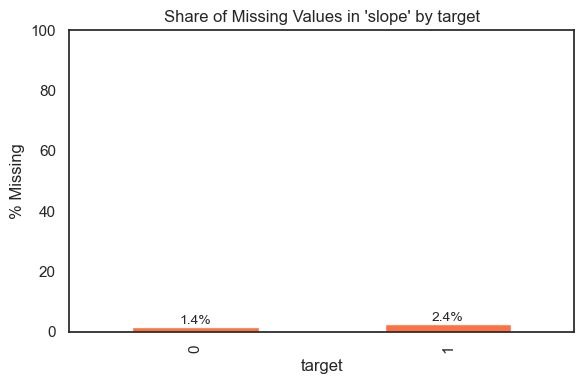

In [787]:
missing_values_report_plot(data, 'slope')

The slope variable has 6 missing values ($1.98\%$ of the total observations). The distribution of missing values across the target variable (target) is practically the same: $1.4\%$ among healthy individuals ($target = 0$) and $2.4\%$ among sick individuals ($target = 1$).
The results of the chi-square test ($p$-value $= 0.847$) found no statistically significant relationship between the missing values and the target variable; therefore, the missing values can be considered random (MCAR — Missing Completely At Random).

##### Distribution

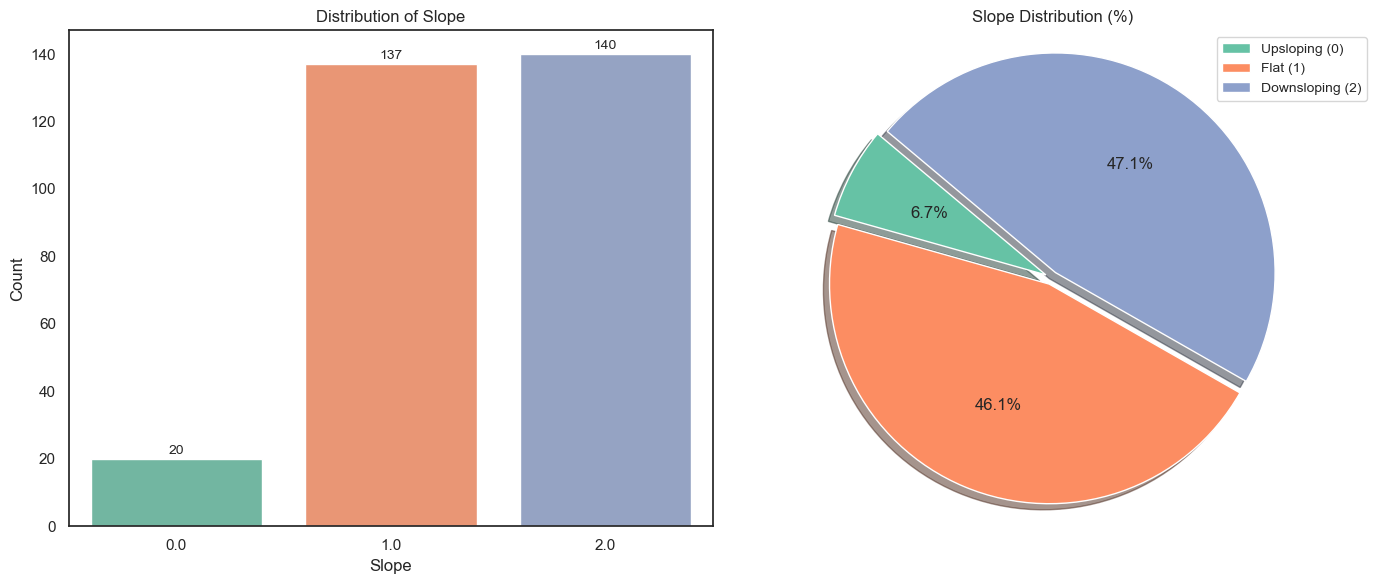

In [788]:
plot_target_distribution(data, 'slope', legend_labels = legend_dict['slope'])

The majority of patients have either a flat ($Flat = 1, 46.1\%$) or down-sloping ($Downsloping = 2, 47.1\%$) type of ST segment, which indicates possible abnormalities in the ECG during exercise. The least common is the up-sloping type ($Upsloping = 0, 6.7\%$), which is considered physiologically normal. This distribution may reflect a high proportion of patients with ischemic changes, as ST segment abnormalities are often associated with impaired coronary blood flow.

##### Target Rate by Slope

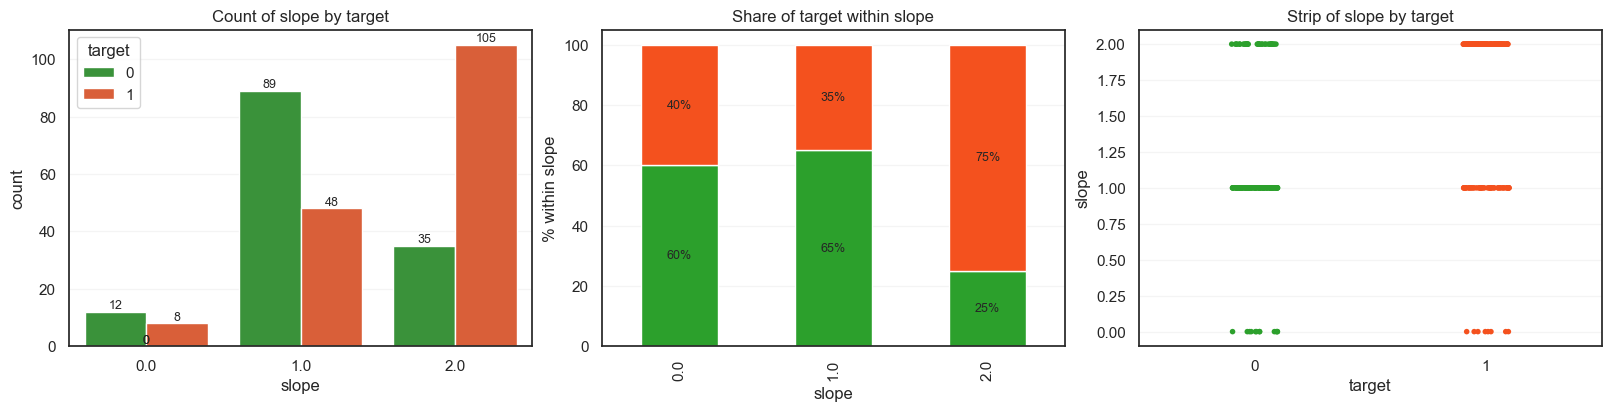

In [789]:
analyze_feature_vs_target(data, 'slope')

The slope variable shows an important relationship with the presence of the disease, especially considering the distribution of observations.
* The down-sloping segment ($slope = 2$) is the most common ($140$ cases, $47\%$) and among these, $75\%$ of patients have the disease, making this type the "riskiest".
* The flat segment ($slope = 1$) is also common ($137$ cases, $46\%$) and is associated with the disease in $35\%$ of cases—here, healthy individuals prevail.
* The up-sloping segment ($slope = 0$) is observed in only $20$ patients ($6.7\%$), and the proportion of sick individuals among them is $40\%$, but the interpretation is less reliable due to the small number of observations.

Collectively, this confirms that slope is an informative feature, particularly due to the large proportion of sick individuals at $slope = 2$.

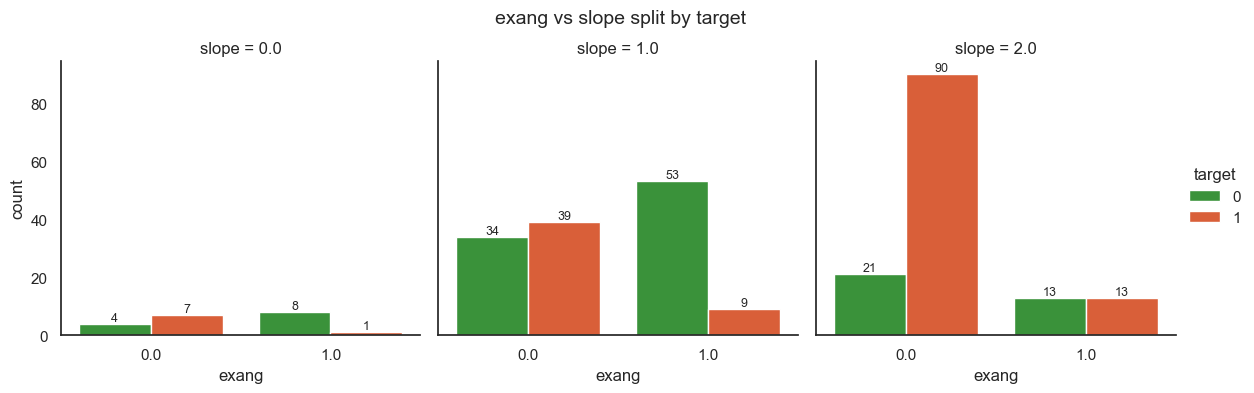

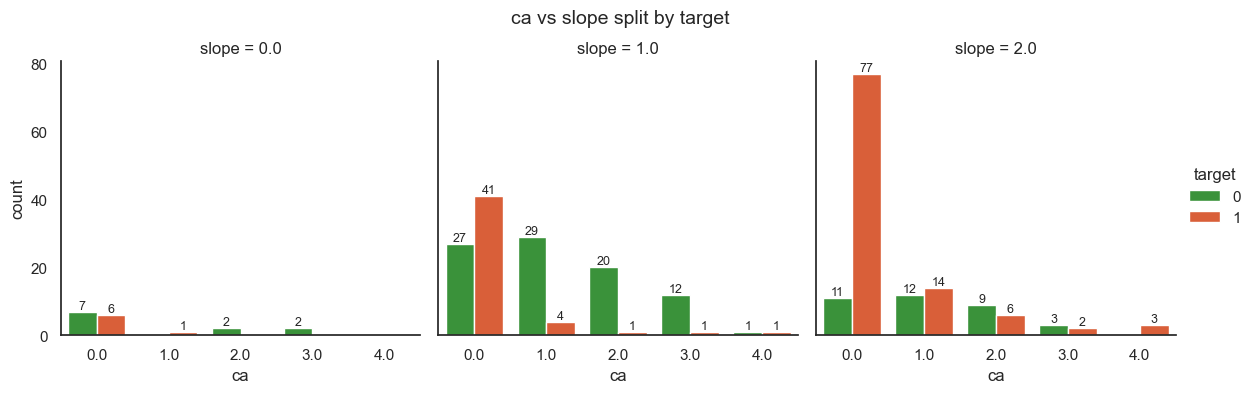

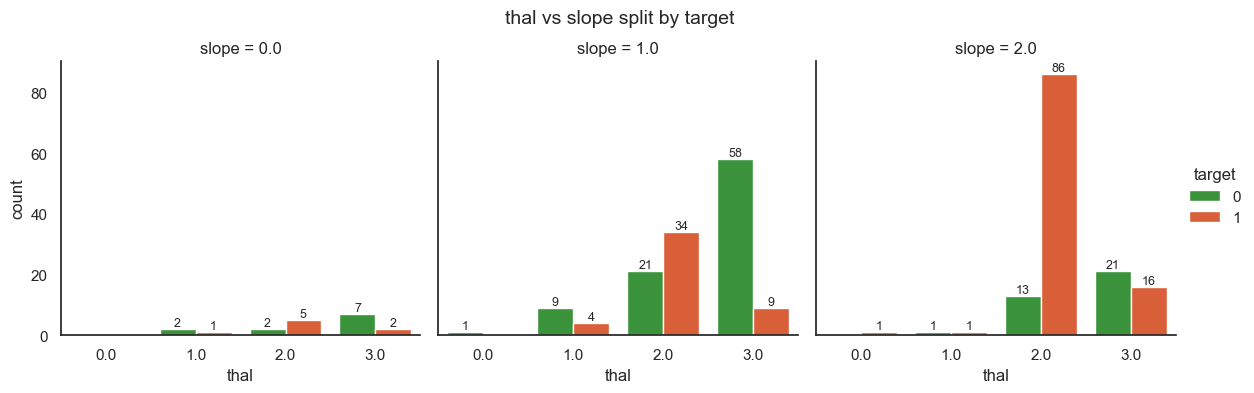

In [790]:
for feature in ['exang', 'ca', 'thal']:
    g = sns.catplot(
        data=data, x=feature, hue='target', col='slope',
        kind='count', height=4, aspect=1, palette=palette
    )

    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{feature} vs slope split by target", fontsize=14)
    plt.show()

When analyzing the variable slope together with the features exang, ca, and thal, a highly pronounced dependency is revealed between the type of ST segment slope and the probability of having the disease ($target=1$).

This is particularly evident with a value of $slope = 2.0$ (down-sloping ST segment): in this subgroup, sick patients sharply dominate.
* For instance, when $exang = 0$ (absence of exercise-induced angina), among patients with $slope = 2.0$ — there are $90$ sick individuals versus $21$ healthy ones. This may point to cases of silent ischemia not detected by stress tests.
* With the same slope of $slope = 2.0$, the value $ca = 0$ (no major vessels colored) is also accompanied by a high number of sick individuals — $77$ versus $11$ healthy ones, suggesting that the disease can develop even with "clean" vessels.
* Furthermore, for $thal = 2$ (fixed defect — often interpreted as the presence of a perfusion defect), there is a strong shift towards $target=1$ — $86$ sick individuals versus only $13$ healthy ones.

In contrast, at $slope = 1.0$ (flat segment), the distributions across target are much more balanced and do not yield definitive conclusions, while $slope = 0.0$ (up-sloping) is very rare, and conclusions based on it are difficult due to the small number of observations.

Thus, a down-sloping ST segment ($slope=2.0$) in combination with $exang=0$, $ca=0$, and $thal=2$ is a powerful indicator of the presence of the disease, even though other features might seem significant in isolation. This underscores the importance of analyzing feature combinations rather than their isolated effects.

#### The CA Variable

The variable ca — Number of Major Vessels Colored (by Fluoroscopy)

The variable ca plays a key role in assessing the condition of the patient's cardiovascular system. It reflects the number of main coronary vessels in which significant narrowing, stenoses, or obstructions were detected during fluoroscopy (coronary angiography). This is therefore a direct indicator of the degree of coronary damage and is closely related to the risk of developing Ischemic Heart Disease (IHD) and other serious complications.
* A value of $ca = 0$ means that none of the major vessels have significant narrowing—this is considered normal and indicates good coronary blood flow.
* If $ca = 1$, one vessel is affected, such as the LAD (Left Anterior Descending artery), RCA (Right Coronary Artery), or LCX (Left Circumflex Artery). This already indicates an increased risk of cardiovascular disease, especially in the presence of other risk factors.
* At $ca = 2$, stenoses are found in two coronary vessels, which is a pronounced manifestation of multi-vessel ischemia. Such a case is assessed as high risk for myocardial infarction and heart failure.
* A value of $ca = 3$ indicates involvement of all three main vessels, which is a critical condition. A patient with this result usually requires urgent invasive or surgical treatment (e.g., bypass surgery).
* Sometimes $ca = 4$ is encountered—this is an expanded value, including a fourth vessel, such as the ramus intermedius or a rare anatomical variation. This condition is extremely rare and associated with severe obstruction of the entire coronary system.

The more vessels are affected, the higher the risk of impaired myocardial blood supply and potentially, a fatal outcome without treatment.

The variable ca is a powerful prognostic marker in the diagnosis of IHD. It allows for a rapid assessment of the degree of anatomical damage and helps in making clinical decisions: from prescribing medication to referral for surgery (e.g., angioplasty or coronary artery bypass grafting).

In [792]:
data['ca'].describe()

count    298.000000
mean       0.734899
std        1.028315
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: ca, dtype: float64

The variable ca has a distribution skewed towards normal: the median is $0$, and $75\%$ of patients have no more than one vessel affected.  The mean value is $0.73$, which also indicates a prevalence of healthy or moderately affected vessels. The maximum value of $4$ is extremely rare and indicates a severe form of the disease. Thus, most patients either have no anatomical vessel damage ($ca = 0$) or have damage to one vessel ($ca = 1$), while severe cases ($ca \ge 2$) are relatively rare.

##### Missing Values

===== Missing Values Analysis for: ca =====
Missing in ca: 5 (1.65%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             99.3      0.7
1             97.6      2.4
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 0.48157

Missing values may be MCAR (no significant relation to target).


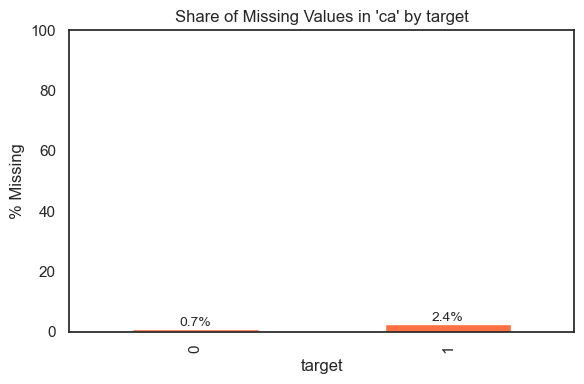

In [793]:
missing_values_report_plot(data, 'ca')

The variable ca has 5 missing data points, which constitutes $1.65\%$ of the total observations. When comparing by the target variable (presence of heart disease), it is visible that the proportion of missing values is higher among sick individuals: $2.4\%$ compared to $0.7\%$ among healthy individuals.  However, according to the chi-square test ($p$-value $= 0.48157$), there is no statistically significant relationship between the missing values and the target variable. This indicates that the missing values are likely MCAR (Missing Completely At Random)—random and not related to the disease, which simplifies their handling.

##### Distribution

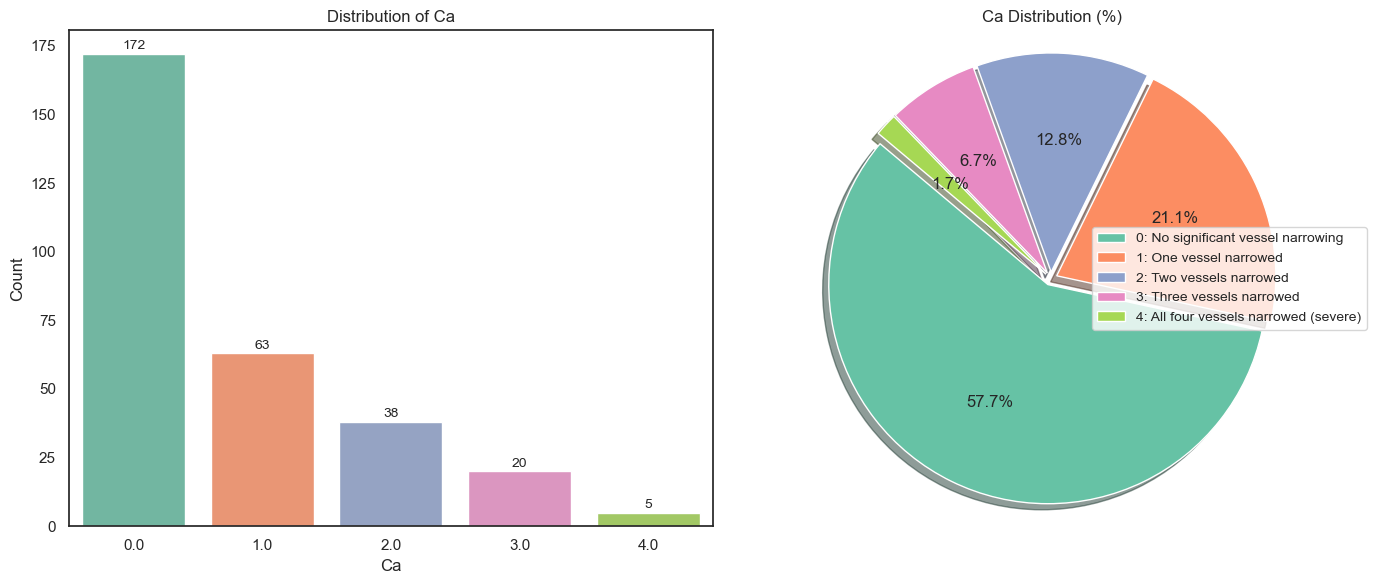

In [794]:
plot_target_distribution(data, 'ca', legend_labels = legend_dict['ca'])

The majority of patients (almost $58\%$) do not have significant coronary vessel narrowing (value $ca = 0$), which is considered normal.  Approximately $21\%$ have narrowing in one vessel, which may indicate moderate risk. Values $ca = 2$ and $ca = 3$, corresponding to high and critical risks, occur in $12.8\%$ and $6.7\%$ of patients, respectively. The most severe condition—narrowing in all four vessels ($ca = 4$)—is observed in only $1.7\%$ of patients. This confirms that multiple vessel involvement is rarer but is associated with a sharply increasing risk of cardiovascular complications. The distribution of ca is asymmetrical, with a clear skew towards healthy vessels.

##### Target Rate by CA

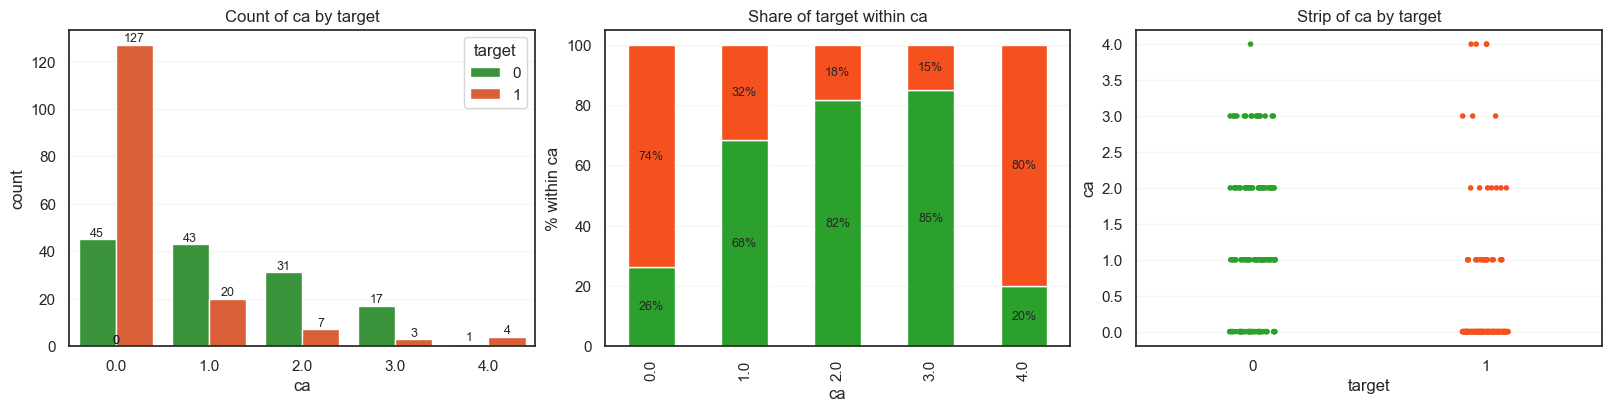

In [795]:
analyze_feature_vs_target(data, 'ca')

Considering the number of observations, the variable ca (number of major vessels colored) shows an interesting and non-monotonic relationship with the presence of heart disease.
* At the value $ca = 0$, which occurs most frequently ($172$ patients), $74\%$ are found to be sick, despite the absence of calcified vessel narrowing. This is explained by the fact that angiography only detects major lesions, failing to identify functional abnormalities: microvascular dysfunction, arterial spasms, or unstable plaques, as well as inflammation and endothelial dysfunction, which can cause disease even with normal visualization results.
* With the increase of ca from $1$ to $3$, the proportion of sick individuals paradoxically decreases (to $15\%$ at $ca = 3$), which may be a result of sample biases or random fluctuations due to small subgroups.
* However, at $ca = 4$, a sharp jump is observed—$80\%$ sick individuals, despite only $5$ observations, suggesting either high severity of the condition or statistical instability.

Thus, the variable ca remains an important prognostic marker, especially at high values, but requires cautious analysis, particularly in small groups.

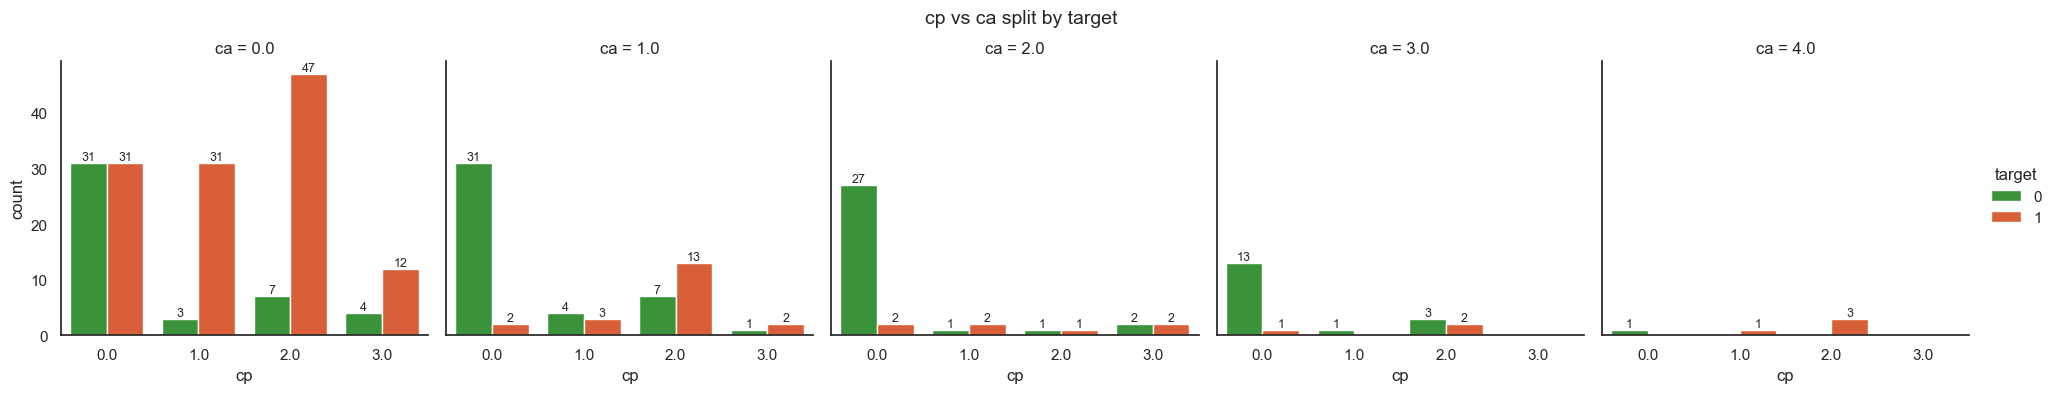

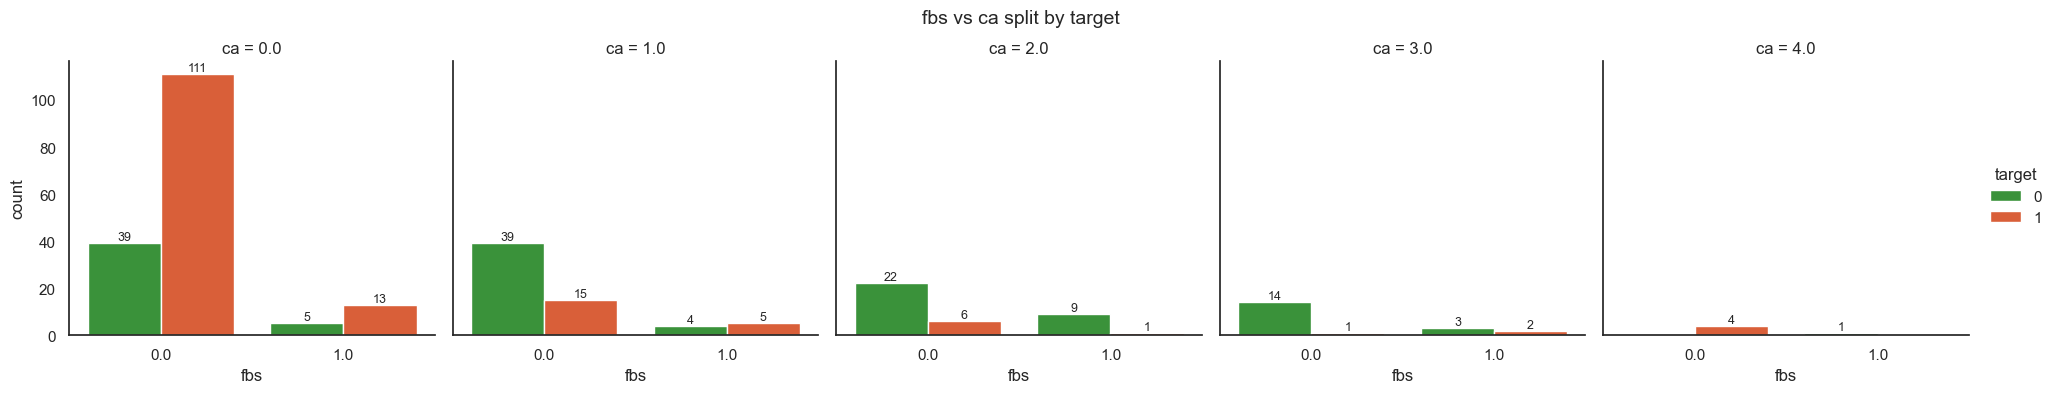

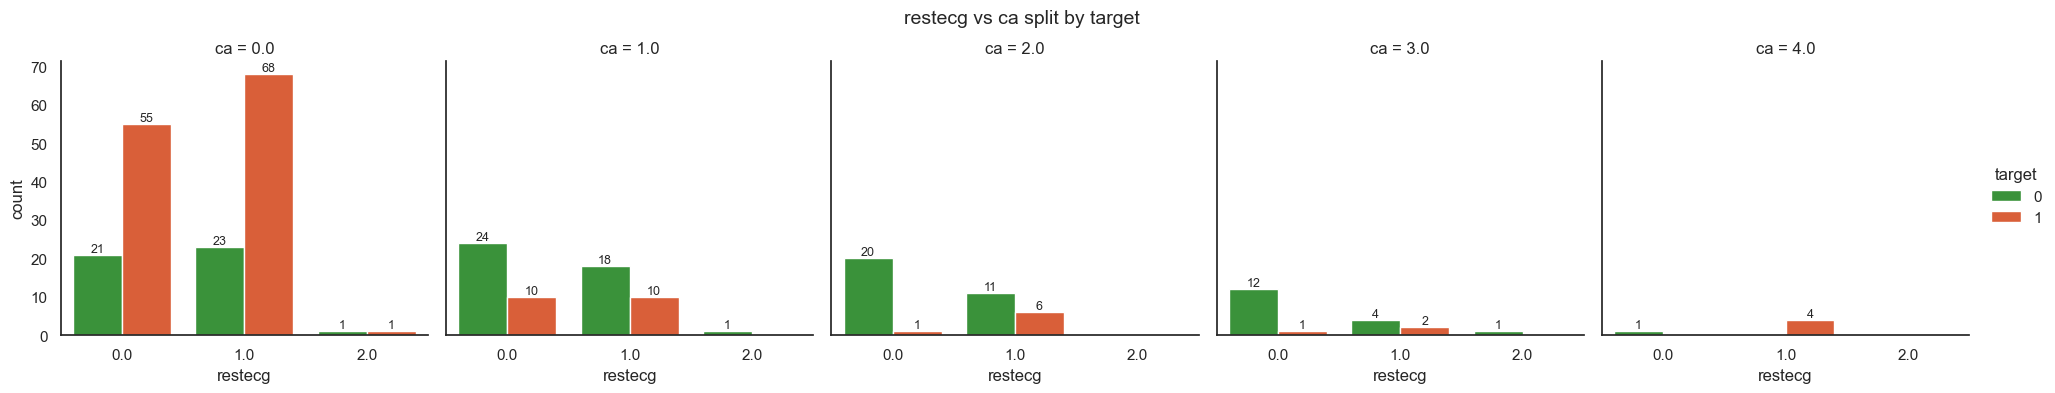

In [796]:
palette = {0: '#2CA02C', 1: '#F4511E'}
for feature in ['cp', 'fbs', 'restecg']:
    g = sns.catplot(
        data=data, x=feature, hue='target', col='ca',
        kind='count', height=4, aspect=1, palette=palette
    )

    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{feature} vs ca split by target", fontsize=14)
    plt.show()

The variable ca (number of major vessels colored by fluoroscopy) strongly influences the probability of the disease ($target = 0$ or $1$), but its value becomes especially informative when analyzed in conjunction with other variables: cp, fbs, restecg.

cp (Chest Pain Type)
* When $ca = 0$, many sick individuals have $cp=2$ (atypical angina) — $47$ sick vs. $7$ healthy. This is a powerful signal!
* When $ca = 1–3$, the number of healthy individuals with $cp=0$ (no pain) sharply increases — especially at $ca=2$, $ca=3$: almost all are healthy.
* The type of pain and the number of affected vessels together provide important information. The absence of pain with high ca is a frequent marker of health, while atypical pain ($cp=2$) with $ca=0$ is a sign of disease.

fbs (Fasting Blood Sugar $>120$ mg/dl)
* When $ca=0$, most sick individuals have $fbs = 0$ — meaning normal sugar (!). This implies that high sugar is not necessarily linked to the disease at this level of ca.
* When $ca=1–2$, healthy individuals with $fbs=0$ prevail, and at $fbs=1$ (high sugar), there is almost no difference.
* fbs does not amplify the ca signal; on the contrary, at $ca=0$, many are sick even with normal sugar. Perhaps the risk factor lies elsewhere, not in the sugar level.

restecg (Resting ECG Results)
* When $ca = 0$, the majority of sick individuals have $restecg = 0$ or $1$. There are especially many with $restecg = 1$ ($68$ sick).
* When $ca = 1–3$ and $restecg = 0$, healthy individuals sharply prevail. At $ca=2–3$, there are almost no sick individuals regardless of the ECG type.
* At high $ca$ values (especially $ca=2,3$), almost all patients are healthy regardless of the ECG, but at $ca=0$ — the ECG result itself is important (especially $restecg=1$).

$ca=0$ means that no vessel damage is visible, but the disease can already manifest through clinical symptoms ($cp=2$, $restecg=1$).
* In patients with a large number of affected vessels ($ca=2–3$), the disease may be under control, compensated, or may not lead to symptoms (e.g., $cp=0$, $restecg=0$).
* Furthermore, the data is not balanced for $ca=3$ and $ca=4$.

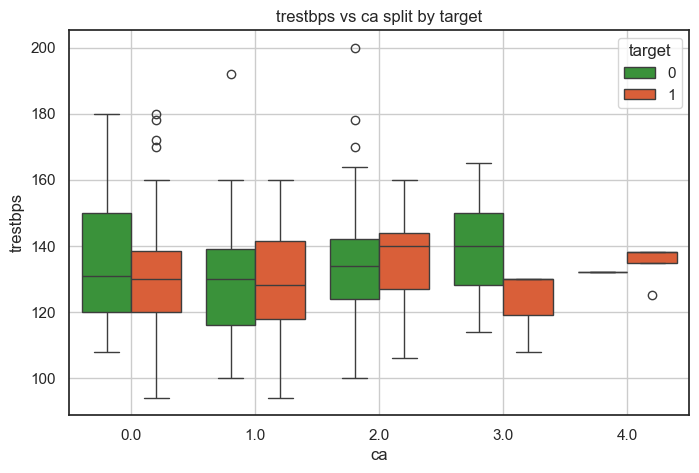

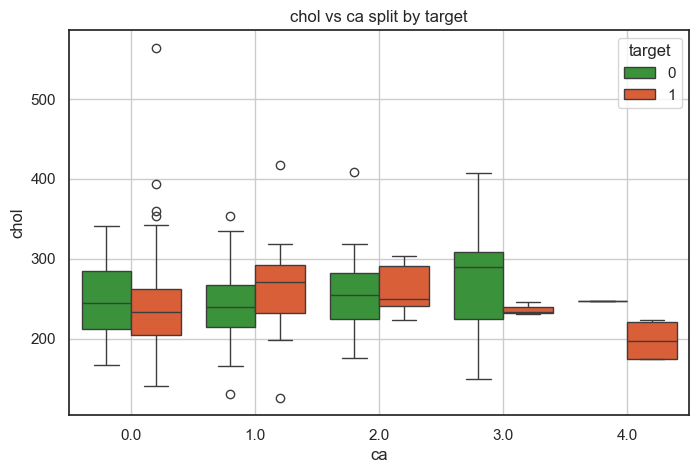

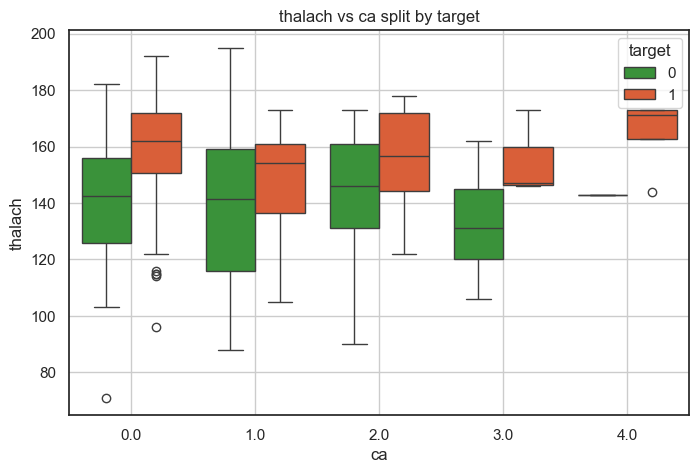

In [797]:
for feature in ['trestbps', 'chol', 'thalach']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x='ca', y=feature, hue='target', palette=palette)
    plt.grid(True)
    plt.title(f"{feature} vs ca split by target")
    plt.show()

Resting blood pressure (trestbps) does not demonstrate a stable relationship with the number of calcified vessels (ca).  In some subgroups ($ca=2, ca=4$), it is higher in sick individuals, which may indicate hypertension as a risk factor, whereas at $ca=3$, blood pressure in sick individuals is lower, likely due to treatment. In the $ca=0$ and $ca=1$ groups, the differences are insignificant. This makes trestbps an unstable marker requiring additional context.Cholesterol level (chol) also fluctuates without a clear pattern: at $ca=1$, it is significantly higher in sick individuals, which may reflect early signs of atherosclerosis, but at $ca=3–4$ it is lower, most likely due to therapy and the small number of observations. Consequently, chol is a moderately sensitive, but not a universal marker.In contrast, maximum heart rate achieved (thalach) is consistently higher in sick individuals across all ca subgroups, especially at $ca=0, 1, 4$. This may be a consequence of compensatory tachycardia, age differences, or other regulatory disorders in sick individuals. Despite the unexpected nature of this result, it makes thalach an informative, but complex-to-interpret feature.

#### The Thal Variable

The variable thal (an abbreviation for Thallium Stress Test or Thalassemia, depending on the dataset version) is a variable reflecting the result of a cardiac stress test using the radioisotope thallium. In the classic Cleveland Heart Disease Dataset, it indicates the type of myocardial perfusion defect identified by scintigraphy or angiography.

Most Common Numerical Values for the thal Variable:
* 1 — Normal: normal blood supply to the heart muscle; no defects detected.
* 2 — Fixed defect: a constant filling defect—an area of the heart muscle that does not receive sufficient blood supply even at rest. This is most often scar tissue after a myocardial infarction or a persistent consequence of atherosclerosis.
* 3 — Reversible defect: a reversible defect—blood flow disturbances appear only during stress and disappear at rest. This indicates temporary ischemia, typical of coronary artery stenosis (IHD, vasospasm, hypoxia).

Clinical Significance
thal is one of the most informative variables in the diagnosis of Ischemic Heart Disease (IHD).
* The value of $2$ (fixed defect) is often associated with a chronic form of ischemia or a previous myocardial infarction, and it strongly correlates with a positive diagnosis ($target = 1$).
* The value of $3$ (reversible defect) indicates active ischemia, which can potentially be eliminated with treatment—either medical or surgical (e.g., stenting).
* The value of $1$ (normal) suggests a low risk of ischemia, especially in the absence of other negative signs.

In [799]:
data['thal'].describe()

count    300.000000
mean       2.310000
std        0.612495
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: thal, dtype: float64

The majority of patients have values of $2$ or $3$, corresponding to a fixed or reversible defect.
* The value $0$ is an anomaly (likely an incorrectly coded missing value) that probably needs to be treated as a missing value.
* The median $= 2$ indicates that fixed defects ($thal = 2$) are the most frequent in this sample.

##### Missing Values

===== Missing Values Analysis for: thal =====
Missing in thal: 3 (0.99%)
Percentage is calculated relative to the total number of rows in the dataset.

Percentage of missing values by target class target (%):
        No Missing  Missing
target                     
0             99.3      0.7
1             98.8      1.2
Percentages are calculated relative to the number of rows in each target class.

Chi-square p-value (missing ~ target): 1.00000

Missing values may be MCAR (no significant relation to target).


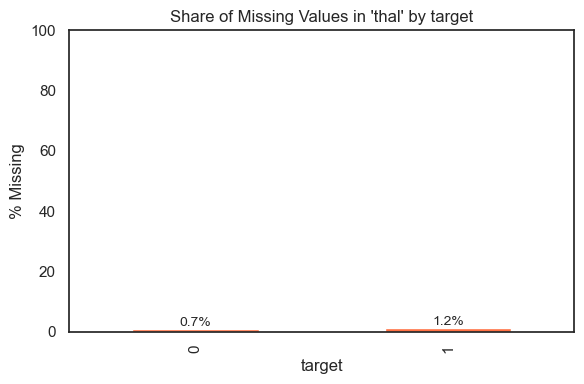

In [800]:
missing_values_report_plot(data, 'thal')

The variable thal has 3 missing values ($0.99\%$ of the sample).  Analyzing the distribution of these missing values across the target classes shows that they occur in both healthy and sick patients ($0.7\%$ and $1.2\%$ respectively). Furthermore, the $p$-value of the $\chi^2$-test is $1.0$, which does not reveal a statistically significant association between the missing values and the target variable.This suggests that the missing values may be random (MCAR — Missing Completely At Random) and are not directly dependent on the presence or absence of the disease.

##### Distribution

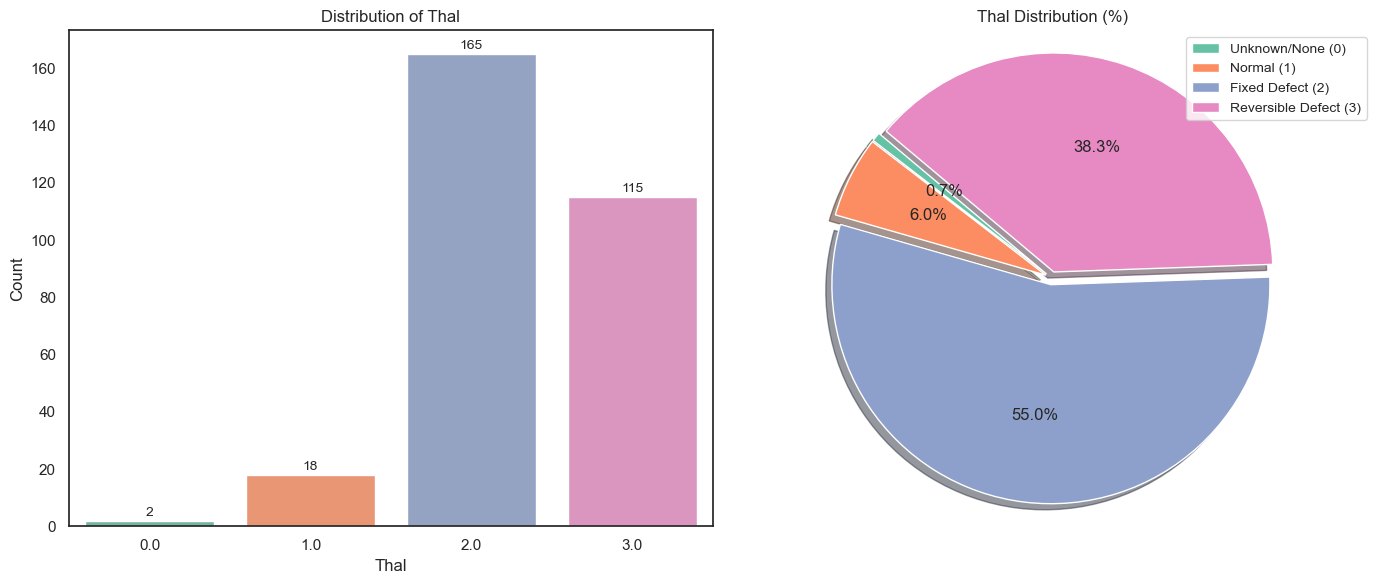

In [801]:
plot_target_distribution(data, 'thal', legend_labels = legend_dict['thal'])

The majority of patients had a fixed defect ($Fixed \ Defect$, code $2$) — $165$ people ($55\%$), which indicates permanent damage to the heart tissue.  The second most common type is a reversible defect ($Reversible \ Defect$, code $3$) — $115$ people ($38.3\%$), associated with ischemia, i.e., reversible blood flow impairment. The normal value (code $1$) is less common — $18$ people ($6\%$), and unknown or missing data (code $0$) were recorded for only $2$ patients ($0.7\%$). Thus, almost $93\%$ of the sample have abnormalities, making this feature an important indicator in predicting cardiovascular diseases.

##### Target Rate by Fbs

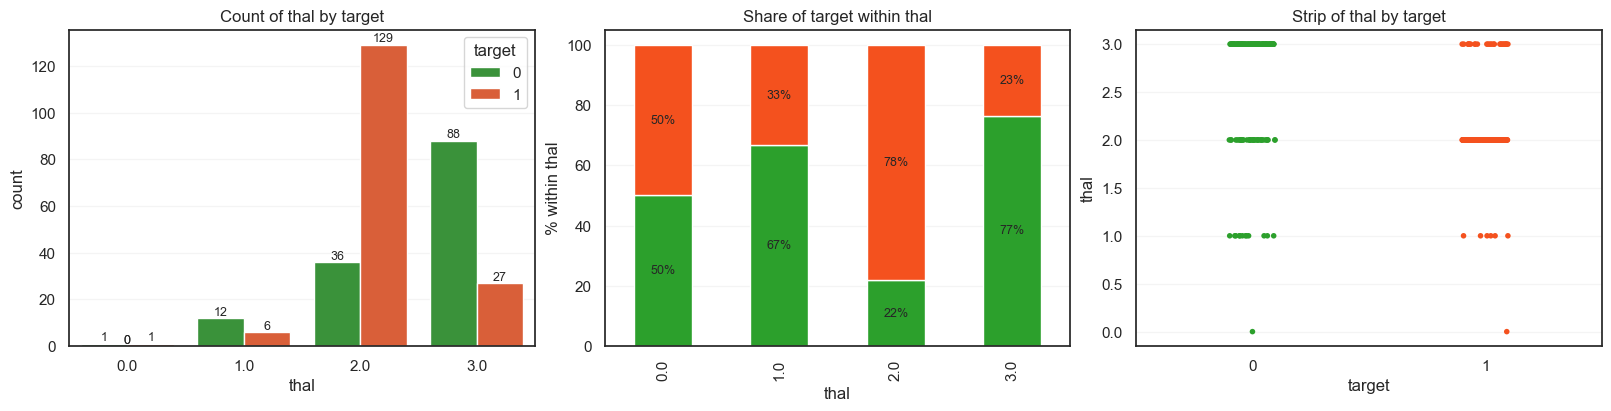

In [802]:
analyze_feature_vs_target(data, 'thal')

The analysis of the thal variable shows that it is potentially important for predicting heart disease. The most common categories are $thal = 2$ (fixed defect) and $thal = 3$ (reversible defect), which together constitute the majority of the sample.
* Notably, $thal = 2$ is significantly more common in sick individuals ($target = 1$), whereas $thal = 3$ is more common in healthy individuals ($target = 0$).
* The value $thal = 1$ (normal result) occurs much less frequently, but the majority of these observations are healthy.
* $thal = 0$, as mentioned earlier, likely needs to be treated as a missing value.

Visual analysis and counting of proportions by target groups confirm that there is a clear relationship between the value of thal and the presence of the disease, especially for $thal = 2$. This makes the variable promising for further analysis and inclusion in the model.

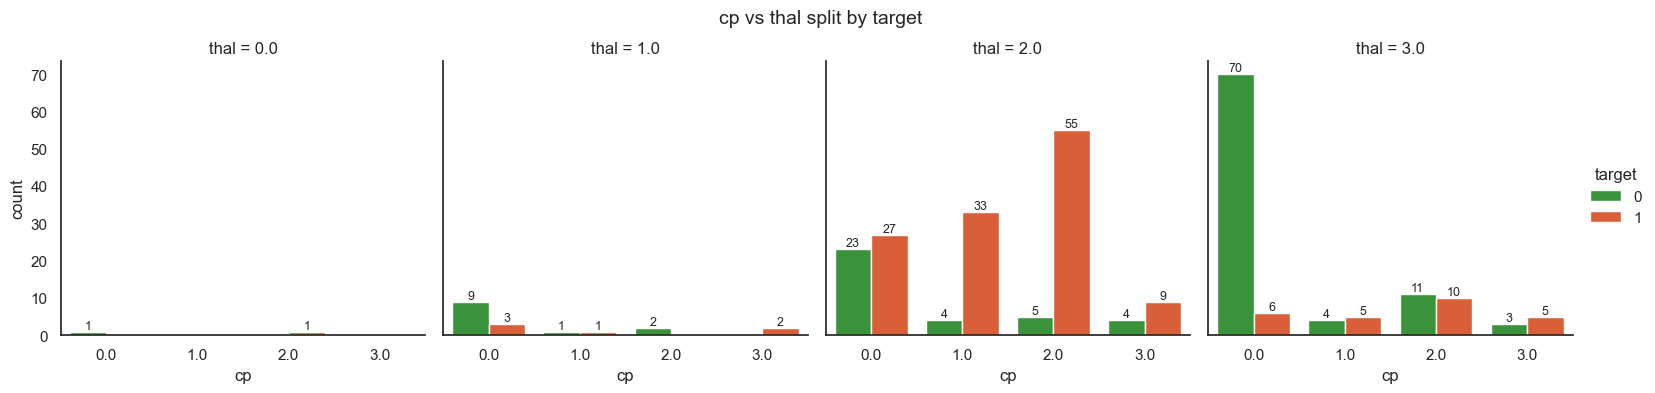

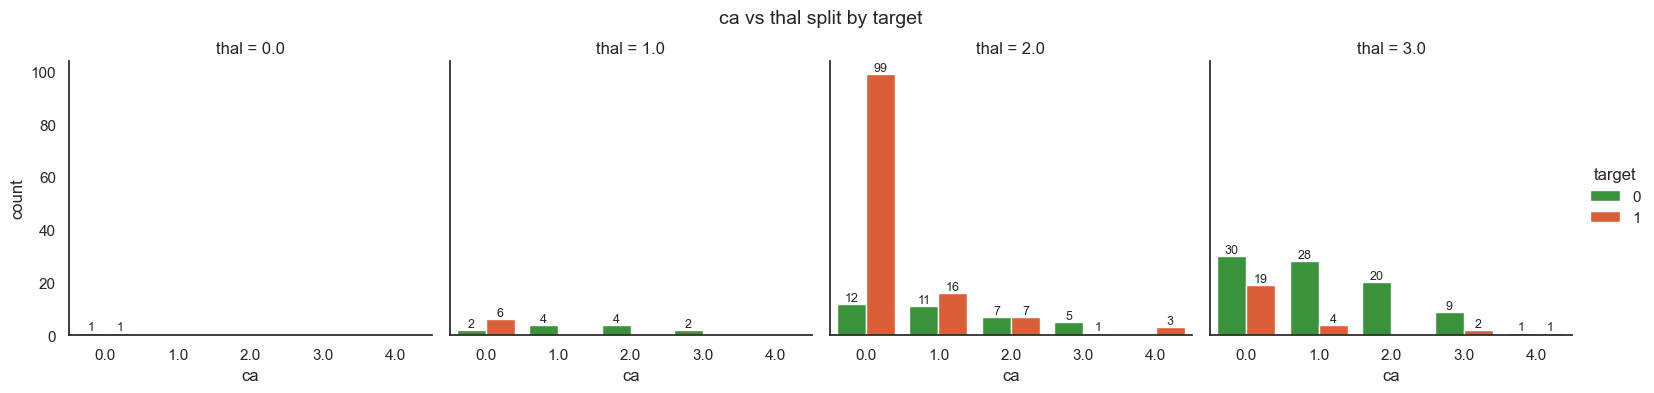

In [803]:
palette = {0: '#2CA02C', 1: '#F4511E'}
for feature in ['cp', 'ca']:
    g = sns.catplot(
        data=data, x=feature, hue='target', col='thal',
        kind='count', height=4, aspect=1, palette=palette
    )

    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{feature} vs thal split by target", fontsize=14)
    plt.show()

The analysis of the charts showed that combinations of the features thal, cp, and ca provide important signals about the probability of heart disease.The most alarming situation is when $thal = 2.0$ (fixed defect) is combined with chest pain types of $cp = 1.0$ or $2.0$ and especially with the number of major vessels colored $ca = 0.0$ — this combination is characteristic of the vast majority of sick individuals.Conversely, with $thal = 3.0$ (reversible defect) and $cp = 0.0$ (absence of pain), or with $ca = 1.0–2.0$, the disease is encountered significantly less often, and such combinations are characteristic of healthy patients.The values of $thal = 1.0$ are extremely rare and do not provide reliable information.Thus, $thal = 2.0$ in combination with low $ca$ values and active pain is a strong indicator of the disease, whereas $thal = 3.0$ with absence of pain and moderate $ca$ values is a sign of relative health.

## EDA Report

## Analysis and Data Preparation for Heart Disease Modeling

**1. Analysis Goal.**
Identify key risk factors for heart disease and build an interpretable model for clinical application.

**2. Data Characteristics.**
Only numerical features (discrete and continuous).
Target variable: `target` (0 = healthy, 1 = disease).
Critical features: `cp` (chest pain type), `thal` (defect type), `oldpeak` (ST depression).

---

### 3. Missing Values

Recommendations for handling missing values:

| Feature | Type | % Missing | Imputation |
| :--- | :--- | :--- | :--- |
| `thalach` | Continuous | 3.96% | Median, alternative: `KNNImputer` with `age`, `sex`, `cp`, `exang` |
| `age` | Continuous | 2.97% | Median, alternative: `IterativeImputer` |
| `cp` | Discrete | 1.98% | Mode |
| `chol` | Continuous | 1.98% | Median, alternative: `KNNImputer` |
| `slope` | Discrete | 1.98% | Mode |
| `exang` | Discrete | 1.65% | Mode |
| `ca` | Discrete | 1.65% | Mode + indicator `ca_missing` |
| `trestbps` | Continuous | 1.32% | Median |
| `fbs` | Discrete | 1.32% | Mode |
| `sex` | Discrete | 0.99% | Mode |
| `restecg` | Discrete | 0.99% | Mode |
| `oldpeak` | Continuous | 0.99% | Median |
| `thal` | Discrete | 0.99% | Mode + indicator `thal_missing`, alternative: `KNNImputer` |

---

### 4. Outliers

Outliers were found in the following continuous features: `trestbps`, `chol`, `thalach`, `oldpeak`.

Since the dataset is medical, outliers must be approached with extreme caution. Some values may reflect rare but clinically significant conditions, and their removal or replacement must be justified.

Proposed methods for handling outliers:

| Feature | Recommendations |
| :--- | :--- |
| `trestbps` | Winsorization or logarithmic transformation. |
| `chol` | Possible trimming (Winsorization) at the 1st and 99th percentiles or log transformation. |
| `thalach` | Can be kept if medically confirmed. Alternative: Winsorization. |
| `oldpeak` | Possible replacement with the upper percentile or application of square root/logarithmic transformation. |

---

### 5. Medical-Based Binning

To improve interpretability and adhere to medical standards, it is recommended to perform binning (discretization) of continuous features based on clinically significant boundaries. This is especially important in tasks requiring an explainable model (e.g., Logistic Regression) and decision-making by physicians.

| Feature | Bin Boundaries | Clinical Interpretation |
| :--- | :--- | :--- |
| `age` | <50, 50–59, $\ge 60$ | Age risk groups: young, middle-aged, elderly |
| `trestbps` | <120 (Normal), 120–139, $\ge 140$ | AHA: Normal, Prehypertension, Hypertension |
| `chol` | <200, 200–239, $\ge 240$ | NIH: Normal, Borderline High, High Cholesterol Level |
| `thalach` | <100, 100–140, >140 | Low, Normal, High Heart Rate during Exercise |
| `oldpeak` | 0, 0.1–2, >2 | Normal, Moderate ST Depression, Severe ST Depression |

**Why this is needed:**
* Improves **medical interpretability**: physicians think in ranges, not precise values.
* Increases **model stability**, especially for linear models.
* Helps detect **non-linear relationships** between features and the target variable.
* Simplifies **visualization and analysis** of categorical relationships.

After binning, one-hot or ordinal encoding should be performed (if a non-interpretable model is used).
For models robust to scale and outliers (e.g., XGBoost), binning is not mandatory but can improve the interpretation of feature importance.

---

### 6. Feature Importance

Top features based on analysis:

* `cp` **Chest Pain Type.** Very strong dependency on `target`; especially $cp=0$ is almost always associated with the disease, $cp=3$ with absence. Categorical, but key.
* `thalach` **Maximum Heart Rate Achieved.** Lower in sick individuals; visualizations and boxplots show significant differences between classes.
* `oldpeak` **ST Segment Depression during Exercise.** Significantly higher in sick individuals; one of the best continuous indicators by distribution and significance.
* `exang` **Exercise Induced Angina.** Healthy individuals almost always have $exang=0$, sick individuals often have $1$. Very clear contrast.
* `ca` **Number of Major Vessels Colored.** The higher $ca$, the higher the probability of disease. Especially $ca=3,4$ are almost always associated with the disease.
* `thal` **Thallium Perfusion Defect.** Sick individuals more often have values of $7$ (Note: value 7 is unusual in standard datasets, often refers to reversible defect, check source), healthy individuals — $3$. Categorical, but significant.
* `slope` **Slope of the Peak Exercise ST Segment.** Sick individuals more often have $slope=2$, healthy individuals — $0$.

---

### 7. Interpretable Models

In medicine, not only accuracy but also model interpretability is important. Physicians must understand why a model made a certain decision, especially when dealing with disease risk. Below are 4 models suitable for such tasks:

| Model | Rationale for Selection | Interpretability |
| :--- | :--- | :--- |
| Logistic Regression | Simple, easily interpretable model. Coefficients show the influence of features on risk | High |
| Decision Tree | Rules like "if $thal=3$ and $cp>1 \to$ risk $80\%$" are understandable even without technical background | High |
| Explainable Boosting Machine (EBM) | Combines the power of boosting with interpretability. Visualizes risk-feature dependence curves | High |
| Random Forest | Robust to outliers and overfitting. Feature importance can be estimated. Does not strictly require preprocessing | Moderate, but acceptable (via feature importance, SHAP) |

**Why these models were chosen?**
* All models prioritize **explainability** — this is vital in healthcare where the clinical legitimacy of a decision must be demonstrated.
* **Logistic Regression** allows easy interpretation of coefficients in terms of “risk increase by X%.”
* **Decision Trees** enable the construction of clear rules that can be understood even without a technical background.
* **EBM (Explainable Boosting)** combines boosting accuracy and explainability through individual feature influence plots.
* **Random Forest** is added as a more stable tree-based option that can be used to assess the importance of features in complex, even if the rules themselves are not obvious.